## RNN for Human Activity Recognition - 2D Pose Input

This experiment is the classification of human activities using a 2D pose time series dataset and an LSTM RNN.
The idea is to prove the concept that using a series of 2D poses, rather than 3D poses or a raw 2D images, can produce an accurate estimation of the behaviour of a person or animal.
This is a step towards creating a method of classifying an animal's current behaviour state and predicting it's likely next state, allowing for better interaction with an autonomous mobile robot.

## Objectives

The aims of this experiment are:

-  To determine if 2D pose has comparable accuracy to 3D pose for use in activity recognition. This would allow the use of RGB only cameras for human and animal pose estimation, as opposed to RGBD or a large motion capture dataset.


- To determine if  2D pose has comparable accuracy to using raw RGB images for use in activity recognition. This is based on the idea that limiting the input feature vector can help to deal with a limited dataset, as is likely to occur in animal activity recognition, by allowing for a smaller model to be used (citation required).


- To verify the concept for use in future works involving behaviour prediction from motion in 2D images.

The network used in this experiment is based on that of Guillaume Chevalier, 'LSTMs for Human Activity Recognition, 2016'  https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition, available under the MIT License.
Notable changes that have been made (other than accounting for dataset sizes) are:
 - Adapting for use with a large dataset ordered by class, using random sampling without replacement for mini-batch.  
 This allows for use of smaller batch sizes when using a dataset ordered by class. "It has been observed in practice that when using a larger batch there is a significant degradation in the quality of the model, as measured by its ability to generalize"  
      _N.S Keskar, D. Mudigere, et al, 'On Large-Batch Training for Deep Learning: Generalization Gap and Sharp 
      Minima', ICLR 2017_ https://arxiv.org/abs/1609.04836
      
 - Exponentially decaying learning rate implemented



## Dataset overview

The dataset consists of pose estimations, made using the software OpenPose (https://github.com/CMU-Perceptual-Computing-Lab/openpose's) on a subset of the Berkeley Multimodal Human Action Database (MHAD) dataset http://tele-immersion.citris-uc.org/berkeley_mhad.

This dataset is comprised of 12 subjects doing the following 6 actions for 5 repetitions, filmed from 4 angles, repeated 5 times each.  

- JUMPING,
- JUMPING_JACKS,
- BOXING,
- WAVING_2HANDS,
- WAVING_1HAND,
- CLAPPING_HANDS.

In total, there are 1438 videos (2 were missing) made up of 211200 individual frames.

The below image is an example of the 4 camera views during the 'boxing' action for subject 1

![alt text](images/boxing_all_views.gif.png "Title")

The input for the LSTM is the 2D position of 18 joints across a timeseries of frames numbering n_steps (window-width), with an associated class label for the frame series.  
A single frame's input (where j refers to a joint) is stored as:

[  j0_x,  j0_y, j1_x, j1_y , j2_x, j2_y, j3_x, j3_y, j4_x, j4_y, j5_x, j5_y, j6_x, j6_y, j7_x, j7_y, j8_x, j8_y, j9_x, j9_y, j10_x, j10_y, j11_x, j11_y, j12_x, j12_y, j13_x, j13_y, j14_x, j14_y, j15_x, j15_y, j16_x, j16_y, j17_x, j17_y ]

For the following experiment, very little preprocessing has been done to the dataset.  
The following steps were taken:
1. openpose run on individual frames, for each subject, action and view, outputting JSON of 18 joint x and y position keypoints and accuracies per frame
2. JSONs converted into txt format, keeping only x and y positions of each frame, action being performed during frame, and order of frames. This is used to create a database of associated activity class number and corresponding series of joint 2D positions
3. No further prepossessing was performed.  

In some cases, multiple people were detected in each frame, in which only the first detection was used.

The data has not been normalised with regards to subject position in the frame, motion across frame (if any), size of the subject, speed of action etc. It is essentially the raw 2D position of each joint viewed from a stationary camera.  
In many cases, individual joints were not located and a position of [0.0,0.0] was given for that joint

A summary of the dataset used for input is:

 - 211200 individual images 
 - n_steps = 32 frames (~=1.5s at 22Hz)
 - Images with noisy pose detection (detection of >=2 people) = 5132  
 - Training_split = 0.8
 - Overlap = 0.8125 (26 / 32) ie 26 frame overlap
   - Length X_train = 22625 * 32 frames
   - Length X_test = 5751 * 32 frames
   
Note that their is no overlap between test and train sets, which were seperated by activity repetition entirely, before creating the 26 of 32 frame overlap.




## Training and Results below: 
Training took approximately 4 mins running on a single GTX1080Ti, and was run for 22,000,000ish iterations with a batch size of 5000  (600 epochs)


In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf  # Version 1.0.0 (some previous versions are used in past commits)
from sklearn import metrics
import random
from random import randint
import time
import os

## Preparing dataset:

In [2]:
# Useful Constants

# Output classes to learn how to classify
# LABELS = [    
#     "JUMPING",
#     "JUMPING_JACKS",
# #     "BOXING",
#     "WAVING_2HANDS",
#     "WAVING_1HAND",
#     "CLAPPING_HANDS"
# ] 

# LABELS = [    
#     "GO_IN",
#     "GO_OUT",
#     "WALK_LEFT",
#     "WALK_RIGHT"
# ] 

# LABELS = [    
#     "normal", "anomaly"
# ] 

# LABELS = [
#     "jalan_UL", "jalan_DR", "jalan_UR", "jalan_DL",
#     "sapu_UL", "sapu_DR", "sapu_UR", "sapu_DL",
#     # "barang_UL", "barang_DR", "barang_UR", "barang_DL",
#     # "out_door_SE", "out_door_SW", "in_door_SE", "in_door_SW",
#     "idle"
# ]

LABELS = [
    "jalan_DR", "jalan_UR", "jalan_DL", "jalan_UL",
    "barang2_DR", "barang2_UR", "barang2_DL", "barang2_UL",
    "barang1l_DR", "barang1l_UR", "barang1l_DL", "barang1l_UL",
    "barang1r_DR", "barang1r_UR", "barang1r_DL", "barang1r_UL",
    "idle_ND"
]

# LABELS = [    
#     "jalan_NE", "jalan_NW", "jalan_SE", "jalan_SW",
#     "menyapu_NE", "menyapu_NW", "menyapu_SE", "menyapu_SW",
#     "barang_NE", "barang_NW", "barang_SE", "barang_SW",
#     "diam_NE", "diam_NW", "diam_SE", "diam_SW"
# ] 

# DATASET_PATH = "data/HAR_pose_activities/database/"
# DATASET_PATH = "data/HAR_pose_activities/database/Training Default/"

# DATASET_PATH = "data/Overlap_fixed4_separated/"

# DATASET_PATH = "data/2a_Amplify/"

DATASET_PATH = "data/Direct2a/NormalizePoint/"

n_steps = 5
# n_steps = 8


X_train_path = DATASET_PATH + "X_train.txt"
X_test_path = DATASET_PATH + "X_test.txt"
# X_test_path = "utilities/something/something.txt"

y_train_path = DATASET_PATH + "Y_train.txt"
y_test_path = DATASET_PATH + "Y_test.txt"

# n_steps = 32 # 32 timesteps per series
# n_steps = 1

In [3]:

# Load the networks inputs

def load_X(X_path):
    file = open(X_path, 'r')
    X_ = np.array(
        [elem for elem in [
            row.split(',') for row in file
        ]], 
        dtype=np.float32
    )
    file.close()
    blocks = int(len(X_) / n_steps)
    
    X_ = np.array(np.split(X_,blocks))

    return X_ 

# Load the networks outputs

def load_y(y_path):
    file = open(y_path, 'r')
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]], 
        dtype=np.int32
    )
    file.close()
    
    # for 0-based indexing 
    return y_ - 1

X_train = load_X(X_train_path)
X_test = load_X(X_test_path)
#print X_test

y_train = load_y(y_train_path)
y_test = load_y(y_test_path)
# proof that it actually works for the skeptical: replace labelled classes with random classes to train on
#for i in range(len(y_train)):
#    y_train[i] = randint(0, 5)


## Set Parameters:


In [4]:
# Input Data 

training_data_count = len(X_train)  # 4519 training series (with 50% overlap between each serie)
test_data_count = len(X_test)  # 1197 test series
n_input = len(X_train[0][0])  # num input parameters per timestep

n_hidden = 36 # Hidden layer num of features
# n_classes = 6 
n_classes = len(LABELS)

#updated for learning-rate decay
# calculated as: decayed_learning_rate = init_learning_rate * decay_rate ^ (global_step / decay_steps)
decaying_learning_rate = True
learning_rate = 0.0025 #used if decaying_learning_rate set to False

init_learning_rate = 0.005
# init_learning_rate = 0.00015

decay_rate = 0.96 #the base of the exponential in the decay
decay_steps = 100000 #used in decay every 60000 steps with a base of 0.96

global_step = tf.Variable(0, trainable=False)
lambda_loss_amount = 0.0015

# training_iters = training_data_count *300  # Loop 300 times on the dataset, ie 300 epochs
# training_iters = training_data_count *60
# training_iters = training_data_count *120
# training_iters = training_data_count *1
# batch_size = 5
batch_size = 64
# batch_size = 512
display_iter = batch_size*8  # To show test set accuracy during training

print(training_data_count, test_data_count, n_input, n_classes)
print("(X shape, y shape, every X's mean, every X's standard deviation)")
print(X_train.shape, y_test.shape, np.mean(X_test), np.std(X_test))
print("\nThe dataset has not been preprocessed, is not normalised etc")




5270 5270 36 17
(X shape, y shape, every X's mean, every X's standard deviation)
(5270, 5, 36) (5270, 1) 21.505436 99.80832

The dataset has not been preprocessed, is not normalised etc


## Utility functions for training:

In [5]:
def LSTM_RNN(_X, _weights, _biases):
    # model architecture based on "guillaume-chevalier" and "aymericdamien" under the MIT license.

    _X = tf.transpose(_X, [1, 0, 2])  # permute n_steps and batch_size
    _X = tf.reshape(_X, [-1, n_input])   
    # Rectifies Linear Unit activation function used
    _X = tf.nn.relu(tf.matmul(_X, _weights['hidden']) + _biases['hidden'])
    # Split data because rnn cell needs a list of inputs for the RNN inner loop
    _X = tf.split(_X, n_steps, 0) 

    # Define two stacked LSTM cells (two recurrent layers deep) with tensorflow
#     lstm_cell_1 = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
#     lstm_cell_2 = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
#     lstm_cells = tf.contrib.rnn.MultiRNNCell([lstm_cell_1, lstm_cell_2], state_is_tuple=True)

    lstm_cell_1 = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
    lstm_cells = tf.contrib.rnn.MultiRNNCell([lstm_cell_1], state_is_tuple=True)

#     lstm_cell_1 = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
#     lstm_cell_2 = tf.contrib.rnn.BasicLSTMCell(n_hidden*2, forget_bias=1.0, state_is_tuple=True)
#     lstm_cell_3 = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
#     lstm_cells = tf.contrib.rnn.MultiRNNCell([lstm_cell_1, lstm_cell_2, lstm_cell_3], state_is_tuple=True)
    
    outputs, states = tf.contrib.rnn.static_rnn(lstm_cells, _X, dtype=tf.float32)

    # A single output is produced, in style of "many to one" classifier, refer to http://karpathy.github.io/2015/05/21/rnn-effectiveness/ for details
    lstm_last_output = outputs[-1]
    
    # Linear activation
    return tf.matmul(lstm_last_output, _weights['out']) + _biases['out']


def extract_batch_size(_train, _labels, _unsampled, batch_size):
    # Fetch a "batch_size" amount of data and labels from "(X|y)_train" data. 
    # Elements of each batch are chosen randomly, without replacement, from X_train with corresponding label from Y_train
    # unsampled_indices keeps track of sampled data ensuring non-replacement. Resets when remaining datapoints < batch_size    
    
    shape = list(_train.shape)
    shape[0] = batch_size
    batch_s = np.empty(shape)
    batch_labels = np.empty((batch_size,1)) 

    for i in range(batch_size):
        # Loop index
        # index = random sample from _unsampled (indices)
        index = random.choice(_unsampled)
        batch_s[i] = _train[index] 
        batch_labels[i] = _labels[index]
        
        _unsampled = list(_unsampled)
        
        _unsampled.remove(index)


    return batch_s, batch_labels, _unsampled


def one_hot(y_):
    # One hot encoding of the network outputs
    # e.g.: [[5], [0], [3]] --> [[0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0]]
    
    y_ = y_.reshape(len(y_))
    n_values = int(np.max(y_)) + 1
    return np.eye(n_values)[np.array(y_, dtype=np.int32)]  # Returns FLOATS



## Build the network:

In [6]:
# for _ in range(3):
#     tf.reset_default_graph()
#     var = tf.Variable(0)
#     with tf.Session() as session:
#         session.run(tf.global_variables_initializer())
#         print(len(session.graph._nodes_by_name.keys()))

In [7]:

# Graph input/output
x = tf.placeholder(tf.float32, [None, n_steps, n_input])
y = tf.placeholder(tf.float32, [None, n_classes])

# Graph weights
weights = {
    'hidden': tf.Variable(tf.random_normal([n_input, n_hidden])), # Hidden layer weights
    'out': tf.Variable(tf.random_normal([n_hidden, n_classes], mean=1.0))
}
biases = {
    'hidden': tf.Variable(tf.random_normal([n_hidden])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

pred = LSTM_RNN(x, weights, biases)

# Loss, optimizer and evaluation
l2 = lambda_loss_amount * sum(
    tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables()
) # L2 loss prevents this overkill neural network to overfit the data
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=pred)) + l2 # Softmax loss
if decaying_learning_rate:
    learning_rate = tf.train.exponential_decay(init_learning_rate, global_step*batch_size, decay_steps, decay_rate, staircase=True)


#decayed_learning_rate = learning_rate * decay_rate ^ (global_step / decay_steps) #exponentially decayed learning rate
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost,global_step=global_step) # Adam Optimizer

# correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
# accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))



Instructions for updating:
This class is deprecated, please use tf.nn.rnn_cell.LSTMCell, which supports all the feature this cell currently has. Please replace the existing code with tf.nn.rnn_cell.LSTMCell(name='basic_lstm_cell').
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [8]:
print(biases)
print(weights)
print(weights['hidden'])

{'hidden': <tf.Variable 'Variable_3:0' shape=(36,) dtype=float32_ref>, 'out': <tf.Variable 'Variable_4:0' shape=(17,) dtype=float32_ref>}
{'hidden': <tf.Variable 'Variable_1:0' shape=(36, 36) dtype=float32_ref>, 'out': <tf.Variable 'Variable_2:0' shape=(36, 17) dtype=float32_ref>}
<tf.Variable 'Variable_1:0' shape=(36, 36) dtype=float32_ref>


In [9]:
# if decaying_learning_rate:
#     learning_rate = tf.train.exponential_decay(init_learning_rate, global_step*batch_size, decay_steps, decay_rate, staircase=True)

## Train the network:

In [10]:
test_losses = []
test_accuracies = []
train_losses = []
train_accuracies = []
sess = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=True))
init = tf.global_variables_initializer()

sess.run(init)

In [11]:
# training_iters = training_data_count *120
# training_iters = training_data_count *5120
# training_iters = training_data_count *2560

# training_iters = training_data_count *512
training_iters = training_data_count *1024
# training_iters = training_data_count *2048
# training_iters = training_data_count *3072
# training_iters = training_data_count *5120

#create saver before training
saver = tf.train.Saver()
# saver = tf.train.Saver(var_list={'wh':weights['hidden'], 'wo':weights['out'], 'bh':biases['hidden'], 'bo':biases['out']})
load = False
train = True
update = True

#check if you want to retrain or import a saved model
if load:
    saver.restore(sess, DATASET_PATH + "model.ckpt")
    print("Model restored.")

correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [12]:
if load:
    # import the inspect_checkpoint library
    from tensorflow.python.tools import inspect_checkpoint as chkp

    # print all tensors in checkpoint file
    chkp.print_tensors_in_checkpoint_file(DATASET_PATH + "model.ckpt", tensor_name='', all_tensors=True)

In [13]:
# Perform Training steps with "batch_size" amount of data at each loop. 
# Elements of each batch are chosen randomly, without replacement, from X_train, 
# restarting when remaining datapoints < batch_size
step = 1
time_start = time.time()
unsampled_indices = range(0,len(X_train))

if not train:
    
    # only perform testing - on training set
    loss, acc = sess.run(
        [cost, accuracy], 
        feed_dict={
            x: X_train,
            y: one_hot(y_train)
        }
    )
    
    print("PERFORMANCE ON TRAIN SET:             " + \
          "Batch Loss = {}".format(loss) + \
          ", Accuracy = {}".format(acc))
    
    # only perform testing - on test set
    loss, acc = sess.run(
        [cost, accuracy], 
        feed_dict={
            x: X_test,
            y: one_hot(y_test)
        }
    )
    
    print("PERFORMANCE ON TEST SET:             " + \
          "Batch Loss = {}".format(loss) + \
          ", Accuracy = {}".format(acc))

while train and (step * batch_size <= training_iters):
    #print (sess.run(learning_rate)) #decaying learning rate
    #print (sess.run(global_step)) # global number of iterations
    if len(unsampled_indices) < batch_size:
        unsampled_indices = range(0,len(X_train)) 
    batch_xs, raw_labels, unsampled_indicies = extract_batch_size(X_train, y_train, unsampled_indices, batch_size)
    batch_ys = one_hot(raw_labels)
    # check that encoded output is same length as num_classes, if not, pad it 
    if len(batch_ys[0]) < n_classes:
        temp_ys = np.zeros((batch_size, n_classes))
        temp_ys[:batch_ys.shape[0],:batch_ys.shape[1]] = batch_ys
        batch_ys = temp_ys
       
    # Fit training using batch data
    _, loss, acc = sess.run(
        [optimizer, cost, accuracy],
        feed_dict={
            x: batch_xs, 
            y: batch_ys
        }
    )
    train_losses.append(loss)
    train_accuracies.append(acc)
    
    # Evaluate network only at some steps for faster training: 
    if (step*batch_size % display_iter == 0) or (step == 1) or (step * batch_size > training_iters):
        
        # To not spam console, show training accuracy/loss in this "if"
        print("Iter #" + str(step*batch_size) + \
              ":  Learning rate = " + "{:.6f}".format(sess.run(learning_rate)) + \
              ":   Batch Loss = " + "{:.6f}".format(loss) + \
              ", Accuracy = {}".format(acc))
        
        # Evaluation on the test set (no learning made here - just evaluation for diagnosis)
        loss, acc = sess.run(
            [cost, accuracy], 
            feed_dict={
                x: X_test,
                y: one_hot(y_test)
            }
        )
        test_losses.append(loss)
        test_accuracies.append(acc)
        print("PERFORMANCE ON TEST SET:             " + \
              "Batch Loss = {}".format(loss) + \
              ", Accuracy = {}".format(acc))

    step += 1

print("Optimization Finished!")

# Accuracy for test data

one_hot_predictions, accuracy_fin, final_loss = sess.run(
    [pred, accuracy, cost],
    feed_dict={
        x: X_test,
        y: one_hot(y_test)
    }
)

test_losses.append(final_loss)
test_accuracies.append(accuracy_fin)

print("FINAL RESULT: " + \
      "Batch Loss = {}".format(final_loss) + \
      ", Accuracy = {}".format(accuracy_fin))
time_stop = time.time()
print("TOTAL TIME:  {}".format(time_stop - time_start))

Iter #64:  Learning rate = 0.005000:   Batch Loss = 7.126491, Accuracy = 0.0625
PERFORMANCE ON TEST SET:             Batch Loss = 6.9569549560546875, Accuracy = 0.05711574852466583
Iter #512:  Learning rate = 0.005000:   Batch Loss = 5.952976, Accuracy = 0.125
PERFORMANCE ON TEST SET:             Batch Loss = 5.919719219207764, Accuracy = 0.09734345227479935
Iter #1024:  Learning rate = 0.005000:   Batch Loss = 5.057403, Accuracy = 0.15625
PERFORMANCE ON TEST SET:             Batch Loss = 5.216989994049072, Accuracy = 0.13776090741157532
Iter #1536:  Learning rate = 0.005000:   Batch Loss = 5.266530, Accuracy = 0.09375
PERFORMANCE ON TEST SET:             Batch Loss = 4.965327262878418, Accuracy = 0.1390891820192337
Iter #2048:  Learning rate = 0.005000:   Batch Loss = 4.904036, Accuracy = 0.078125
PERFORMANCE ON TEST SET:             Batch Loss = 4.768304824829102, Accuracy = 0.15199241042137146
Iter #2560:  Learning rate = 0.005000:   Batch Loss = 4.414285, Accuracy = 0.1875
PERFORMA

Iter #23552:  Learning rate = 0.005000:   Batch Loss = 3.499374, Accuracy = 0.296875
PERFORMANCE ON TEST SET:             Batch Loss = 3.3108625411987305, Accuracy = 0.2984819710254669
Iter #24064:  Learning rate = 0.005000:   Batch Loss = 3.383287, Accuracy = 0.265625
PERFORMANCE ON TEST SET:             Batch Loss = 3.3441197872161865, Accuracy = 0.2994307279586792
Iter #24576:  Learning rate = 0.005000:   Batch Loss = 3.291403, Accuracy = 0.359375
PERFORMANCE ON TEST SET:             Batch Loss = 3.2994260787963867, Accuracy = 0.30891841650009155
Iter #25088:  Learning rate = 0.005000:   Batch Loss = 3.222685, Accuracy = 0.34375
PERFORMANCE ON TEST SET:             Batch Loss = 3.2680909633636475, Accuracy = 0.3155597746372223
Iter #25600:  Learning rate = 0.005000:   Batch Loss = 3.207359, Accuracy = 0.3125
PERFORMANCE ON TEST SET:             Batch Loss = 3.3529598712921143, Accuracy = 0.28728652000427246
Iter #26112:  Learning rate = 0.005000:   Batch Loss = 3.382937, Accuracy = 

Iter #46592:  Learning rate = 0.005000:   Batch Loss = 2.812855, Accuracy = 0.421875
PERFORMANCE ON TEST SET:             Batch Loss = 2.8235220909118652, Accuracy = 0.3461100459098816
Iter #47104:  Learning rate = 0.005000:   Batch Loss = 2.916018, Accuracy = 0.296875
PERFORMANCE ON TEST SET:             Batch Loss = 2.806107997894287, Accuracy = 0.3512333929538727
Iter #47616:  Learning rate = 0.005000:   Batch Loss = 2.802101, Accuracy = 0.359375
PERFORMANCE ON TEST SET:             Batch Loss = 2.8021185398101807, Accuracy = 0.3533206880092621
Iter #48128:  Learning rate = 0.005000:   Batch Loss = 2.765222, Accuracy = 0.34375
PERFORMANCE ON TEST SET:             Batch Loss = 2.7996044158935547, Accuracy = 0.34117648005485535
Iter #48640:  Learning rate = 0.005000:   Batch Loss = 2.772796, Accuracy = 0.28125
PERFORMANCE ON TEST SET:             Batch Loss = 2.7855381965637207, Accuracy = 0.35256168246269226
Iter #49152:  Learning rate = 0.005000:   Batch Loss = 2.812536, Accuracy = 

Iter #69632:  Learning rate = 0.005000:   Batch Loss = 2.387543, Accuracy = 0.390625
PERFORMANCE ON TEST SET:             Batch Loss = 2.54563307762146, Accuracy = 0.3595825433731079
Iter #70144:  Learning rate = 0.005000:   Batch Loss = 2.470009, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 2.5372769832611084, Accuracy = 0.3656546473503113
Iter #70656:  Learning rate = 0.005000:   Batch Loss = 2.431980, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 2.568101644515991, Accuracy = 0.34535104036331177
Iter #71168:  Learning rate = 0.005000:   Batch Loss = 2.441812, Accuracy = 0.375
PERFORMANCE ON TEST SET:             Batch Loss = 2.536651372909546, Accuracy = 0.3567362427711487
Iter #71680:  Learning rate = 0.005000:   Batch Loss = 2.776947, Accuracy = 0.296875
PERFORMANCE ON TEST SET:             Batch Loss = 2.530174732208252, Accuracy = 0.36489564180374146
Iter #72192:  Learning rate = 0.005000:   Batch Loss = 2.551744, Accuracy = 0.328

Iter #92672:  Learning rate = 0.005000:   Batch Loss = 2.346931, Accuracy = 0.34375
PERFORMANCE ON TEST SET:             Batch Loss = 2.347003221511841, Accuracy = 0.37893739342689514
Iter #93184:  Learning rate = 0.005000:   Batch Loss = 2.127551, Accuracy = 0.390625
PERFORMANCE ON TEST SET:             Batch Loss = 2.34216046333313, Accuracy = 0.38026565313339233
Iter #93696:  Learning rate = 0.005000:   Batch Loss = 2.412647, Accuracy = 0.359375
PERFORMANCE ON TEST SET:             Batch Loss = 2.344111442565918, Accuracy = 0.3791271448135376
Iter #94208:  Learning rate = 0.005000:   Batch Loss = 2.287778, Accuracy = 0.375
PERFORMANCE ON TEST SET:             Batch Loss = 2.3288166522979736, Accuracy = 0.3935483992099762
Iter #94720:  Learning rate = 0.005000:   Batch Loss = 2.336882, Accuracy = 0.359375
PERFORMANCE ON TEST SET:             Batch Loss = 2.3180148601531982, Accuracy = 0.3880455493927002
Iter #95232:  Learning rate = 0.005000:   Batch Loss = 2.025523, Accuracy = 0.406

Iter #115712:  Learning rate = 0.004800:   Batch Loss = 1.950336, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 2.2195053100585938, Accuracy = 0.3838709592819214
Iter #116224:  Learning rate = 0.004800:   Batch Loss = 2.283035, Accuracy = 0.34375
PERFORMANCE ON TEST SET:             Batch Loss = 2.233018398284912, Accuracy = 0.37722960114479065
Iter #116736:  Learning rate = 0.004800:   Batch Loss = 2.185862, Accuracy = 0.390625
PERFORMANCE ON TEST SET:             Batch Loss = 2.22489595413208, Accuracy = 0.38235294818878174
Iter #117248:  Learning rate = 0.004800:   Batch Loss = 2.175510, Accuracy = 0.359375
PERFORMANCE ON TEST SET:             Batch Loss = 2.2264976501464844, Accuracy = 0.3880455493927002
Iter #117760:  Learning rate = 0.004800:   Batch Loss = 2.236336, Accuracy = 0.3125
PERFORMANCE ON TEST SET:             Batch Loss = 2.2271580696105957, Accuracy = 0.3876660466194153
Iter #118272:  Learning rate = 0.004800:   Batch Loss = 2.147563, Accuracy

Iter #138752:  Learning rate = 0.004800:   Batch Loss = 2.020777, Accuracy = 0.390625
PERFORMANCE ON TEST SET:             Batch Loss = 2.1236135959625244, Accuracy = 0.39259961247444153
Iter #139264:  Learning rate = 0.004800:   Batch Loss = 2.007054, Accuracy = 0.390625
PERFORMANCE ON TEST SET:             Batch Loss = 2.1240196228027344, Accuracy = 0.3939279019832611
Iter #139776:  Learning rate = 0.004800:   Batch Loss = 2.148027, Accuracy = 0.40625
PERFORMANCE ON TEST SET:             Batch Loss = 2.1085450649261475, Accuracy = 0.4072106182575226
Iter #140288:  Learning rate = 0.004800:   Batch Loss = 2.229331, Accuracy = 0.265625
PERFORMANCE ON TEST SET:             Batch Loss = 2.1035032272338867, Accuracy = 0.4110057055950165
Iter #140800:  Learning rate = 0.004800:   Batch Loss = 1.877939, Accuracy = 0.40625
PERFORMANCE ON TEST SET:             Batch Loss = 2.1187334060668945, Accuracy = 0.40607210993766785
Iter #141312:  Learning rate = 0.004800:   Batch Loss = 2.125281, Accu

Iter #161792:  Learning rate = 0.004800:   Batch Loss = 2.316577, Accuracy = 0.3125
PERFORMANCE ON TEST SET:             Batch Loss = 2.0707197189331055, Accuracy = 0.4178368151187897
Iter #162304:  Learning rate = 0.004800:   Batch Loss = 2.170372, Accuracy = 0.359375
PERFORMANCE ON TEST SET:             Batch Loss = 2.0756959915161133, Accuracy = 0.42220112681388855
Iter #162816:  Learning rate = 0.004800:   Batch Loss = 2.070009, Accuracy = 0.328125
PERFORMANCE ON TEST SET:             Batch Loss = 2.06453800201416, Accuracy = 0.42428842186927795
Iter #163328:  Learning rate = 0.004800:   Batch Loss = 2.200052, Accuracy = 0.390625
PERFORMANCE ON TEST SET:             Batch Loss = 2.054039239883423, Accuracy = 0.4305502772331238
Iter #163840:  Learning rate = 0.004800:   Batch Loss = 2.039369, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 2.049731731414795, Accuracy = 0.433396577835083
Iter #164352:  Learning rate = 0.004800:   Batch Loss = 1.981250, Accuracy = 0.4

Iter #185344:  Learning rate = 0.004800:   Batch Loss = 1.940635, Accuracy = 0.40625
PERFORMANCE ON TEST SET:             Batch Loss = 1.9894161224365234, Accuracy = 0.42732447385787964
Iter #185856:  Learning rate = 0.004800:   Batch Loss = 2.026500, Accuracy = 0.40625
PERFORMANCE ON TEST SET:             Batch Loss = 1.9924468994140625, Accuracy = 0.4288425147533417
Iter #186368:  Learning rate = 0.004800:   Batch Loss = 1.973805, Accuracy = 0.421875
PERFORMANCE ON TEST SET:             Batch Loss = 1.986086130142212, Accuracy = 0.427893728017807
Iter #186880:  Learning rate = 0.004800:   Batch Loss = 1.884039, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 1.976481556892395, Accuracy = 0.42561671137809753
Iter #187392:  Learning rate = 0.004800:   Batch Loss = 1.904795, Accuracy = 0.4375
PERFORMANCE ON TEST SET:             Batch Loss = 1.9727931022644043, Accuracy = 0.4364326298236847
Iter #187904:  Learning rate = 0.004800:   Batch Loss = 1.898720, Accuracy 

Iter #208896:  Learning rate = 0.004608:   Batch Loss = 1.925537, Accuracy = 0.4375
PERFORMANCE ON TEST SET:             Batch Loss = 1.9549682140350342, Accuracy = 0.4351043701171875
Iter #209408:  Learning rate = 0.004608:   Batch Loss = 1.949001, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 1.956587553024292, Accuracy = 0.4324478209018707
Iter #209920:  Learning rate = 0.004608:   Batch Loss = 2.043434, Accuracy = 0.390625
PERFORMANCE ON TEST SET:             Batch Loss = 1.9615287780761719, Accuracy = 0.4227704107761383
Iter #210432:  Learning rate = 0.004608:   Batch Loss = 1.992718, Accuracy = 0.359375
PERFORMANCE ON TEST SET:             Batch Loss = 1.963371753692627, Accuracy = 0.4250474274158478
Iter #210944:  Learning rate = 0.004608:   Batch Loss = 1.886819, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 1.9734090566635132, Accuracy = 0.4134724736213684
Iter #211456:  Learning rate = 0.004608:   Batch Loss = 2.136043, Accuracy = 0.

PERFORMANCE ON TEST SET:             Batch Loss = 1.9412336349487305, Accuracy = 0.43074002861976624
Iter #231936:  Learning rate = 0.004608:   Batch Loss = 1.976059, Accuracy = 0.375
PERFORMANCE ON TEST SET:             Batch Loss = 1.9314196109771729, Accuracy = 0.4368121325969696
Iter #232448:  Learning rate = 0.004608:   Batch Loss = 1.830871, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 1.9207053184509277, Accuracy = 0.43320682644844055
Iter #232960:  Learning rate = 0.004608:   Batch Loss = 1.966810, Accuracy = 0.390625
PERFORMANCE ON TEST SET:             Batch Loss = 1.920715570449829, Accuracy = 0.44079697132110596
Iter #233472:  Learning rate = 0.004608:   Batch Loss = 1.816125, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 1.9258592128753662, Accuracy = 0.44592031836509705
Iter #233984:  Learning rate = 0.004608:   Batch Loss = 1.722035, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 1.9311280250549316, 

PERFORMANCE ON TEST SET:             Batch Loss = 1.8940935134887695, Accuracy = 0.44421252608299255
Iter #254464:  Learning rate = 0.004608:   Batch Loss = 1.855877, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 1.899603009223938, Accuracy = 0.44174572825431824
Iter #254976:  Learning rate = 0.004608:   Batch Loss = 1.843910, Accuracy = 0.4375
PERFORMANCE ON TEST SET:             Batch Loss = 1.8929603099822998, Accuracy = 0.448387086391449
Iter #255488:  Learning rate = 0.004608:   Batch Loss = 1.792958, Accuracy = 0.46875
PERFORMANCE ON TEST SET:             Batch Loss = 1.8744287490844727, Accuracy = 0.4571157395839691
Iter #256000:  Learning rate = 0.004608:   Batch Loss = 2.051980, Accuracy = 0.390625
PERFORMANCE ON TEST SET:             Batch Loss = 1.882993221282959, Accuracy = 0.44345352053642273
Iter #256512:  Learning rate = 0.004608:   Batch Loss = 1.798570, Accuracy = 0.40625
PERFORMANCE ON TEST SET:             Batch Loss = 1.8937957286834717, Accu

PERFORMANCE ON TEST SET:             Batch Loss = 1.905379295349121, Accuracy = 0.41631877422332764
Iter #278016:  Learning rate = 0.004608:   Batch Loss = 1.977920, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 1.8893711566925049, Accuracy = 0.42182162404060364
Iter #278528:  Learning rate = 0.004608:   Batch Loss = 1.942999, Accuracy = 0.359375
PERFORMANCE ON TEST SET:             Batch Loss = 1.8930268287658691, Accuracy = 0.4292220175266266
Iter #279040:  Learning rate = 0.004608:   Batch Loss = 1.835649, Accuracy = 0.421875
PERFORMANCE ON TEST SET:             Batch Loss = 1.8887842893600464, Accuracy = 0.43225806951522827
Iter #279552:  Learning rate = 0.004608:   Batch Loss = 2.029796, Accuracy = 0.359375
PERFORMANCE ON TEST SET:             Batch Loss = 1.887388825416565, Accuracy = 0.4326375722885132
Iter #280064:  Learning rate = 0.004608:   Batch Loss = 1.840753, Accuracy = 0.4375
PERFORMANCE ON TEST SET:             Batch Loss = 1.8744275569915771, Accura

PERFORMANCE ON TEST SET:             Batch Loss = 1.8312594890594482, Accuracy = 0.4533206820487976
Iter #301056:  Learning rate = 0.004424:   Batch Loss = 1.947526, Accuracy = 0.46875
PERFORMANCE ON TEST SET:             Batch Loss = 1.8329689502716064, Accuracy = 0.44762808084487915
Iter #301568:  Learning rate = 0.004424:   Batch Loss = 1.631786, Accuracy = 0.546875
PERFORMANCE ON TEST SET:             Batch Loss = 1.8339438438415527, Accuracy = 0.44174572825431824
Iter #302080:  Learning rate = 0.004424:   Batch Loss = 1.770259, Accuracy = 0.4375
PERFORMANCE ON TEST SET:             Batch Loss = 1.8318129777908325, Accuracy = 0.4571157395839691
Iter #302592:  Learning rate = 0.004424:   Batch Loss = 1.830855, Accuracy = 0.46875
PERFORMANCE ON TEST SET:             Batch Loss = 1.8230595588684082, Accuracy = 0.45521822571754456
Iter #303104:  Learning rate = 0.004424:   Batch Loss = 1.857867, Accuracy = 0.4375
PERFORMANCE ON TEST SET:             Batch Loss = 1.817025065422058, Accu

Iter #324096:  Learning rate = 0.004424:   Batch Loss = 1.663053, Accuracy = 0.46875
PERFORMANCE ON TEST SET:             Batch Loss = 1.820902705192566, Accuracy = 0.45351043343544006
Iter #324608:  Learning rate = 0.004424:   Batch Loss = 1.805954, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 1.8076672554016113, Accuracy = 0.45863378047943115
Iter #325120:  Learning rate = 0.004424:   Batch Loss = 1.769289, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 1.8012259006500244, Accuracy = 0.4628083407878876
Iter #325632:  Learning rate = 0.004424:   Batch Loss = 1.754805, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 1.8011397123336792, Accuracy = 0.45863378047943115
Iter #326144:  Learning rate = 0.004424:   Batch Loss = 1.722880, Accuracy = 0.40625
PERFORMANCE ON TEST SET:             Batch Loss = 1.8163235187530518, Accuracy = 0.46508538722991943
Iter #326656:  Learning rate = 0.004424:   Batch Loss = 1.779886, Accuracy 

Iter #347136:  Learning rate = 0.004424:   Batch Loss = 1.891960, Accuracy = 0.421875
PERFORMANCE ON TEST SET:             Batch Loss = 1.778297781944275, Accuracy = 0.4673624336719513
Iter #347648:  Learning rate = 0.004424:   Batch Loss = 2.037380, Accuracy = 0.296875
PERFORMANCE ON TEST SET:             Batch Loss = 1.7754695415496826, Accuracy = 0.46508538722991943
Iter #348160:  Learning rate = 0.004424:   Batch Loss = 1.688019, Accuracy = 0.4375
PERFORMANCE ON TEST SET:             Batch Loss = 1.7800604104995728, Accuracy = 0.46375712752342224
Iter #348672:  Learning rate = 0.004424:   Batch Loss = 1.592928, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 1.7788430452346802, Accuracy = 0.46413663029670715
Iter #349184:  Learning rate = 0.004424:   Batch Loss = 1.663992, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 1.776658058166504, Accuracy = 0.4647058844566345
Iter #349696:  Learning rate = 0.004424:   Batch Loss = 1.619618, Accurac

Iter #370176:  Learning rate = 0.004424:   Batch Loss = 1.864178, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 1.8184006214141846, Accuracy = 0.4512333869934082
Iter #370688:  Learning rate = 0.004424:   Batch Loss = 1.890496, Accuracy = 0.40625
PERFORMANCE ON TEST SET:             Batch Loss = 1.8465137481689453, Accuracy = 0.43795067071914673
Iter #371200:  Learning rate = 0.004424:   Batch Loss = 1.877910, Accuracy = 0.3125
PERFORMANCE ON TEST SET:             Batch Loss = 1.8369543552398682, Accuracy = 0.44554078578948975
Iter #371712:  Learning rate = 0.004424:   Batch Loss = 1.789392, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 1.8272126913070679, Accuracy = 0.4419354796409607
Iter #372224:  Learning rate = 0.004424:   Batch Loss = 1.657829, Accuracy = 0.515625
PERFORMANCE ON TEST SET:             Batch Loss = 1.8229871988296509, Accuracy = 0.453889936208725
Iter #372736:  Learning rate = 0.004424:   Batch Loss = 1.741746, Accura

Iter #393216:  Learning rate = 0.004424:   Batch Loss = 1.643928, Accuracy = 0.546875
PERFORMANCE ON TEST SET:             Batch Loss = 1.7986314296722412, Accuracy = 0.45863378047943115
Iter #393728:  Learning rate = 0.004424:   Batch Loss = 1.628042, Accuracy = 0.515625
PERFORMANCE ON TEST SET:             Batch Loss = 1.7998714447021484, Accuracy = 0.46204933524131775
Iter #394240:  Learning rate = 0.004424:   Batch Loss = 1.873828, Accuracy = 0.421875
PERFORMANCE ON TEST SET:             Batch Loss = 1.7859336137771606, Accuracy = 0.4719164967536926
Iter #394752:  Learning rate = 0.004424:   Batch Loss = 1.817251, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 1.781280517578125, Accuracy = 0.4817836880683899
Iter #395264:  Learning rate = 0.004424:   Batch Loss = 1.604667, Accuracy = 0.46875
PERFORMANCE ON TEST SET:             Batch Loss = 1.781443476676941, Accuracy = 0.4800758957862854
Iter #395776:  Learning rate = 0.004424:   Batch Loss = 1.733211, Accura

Iter #416256:  Learning rate = 0.004247:   Batch Loss = 1.732156, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 1.831891417503357, Accuracy = 0.46166983246803284
Iter #416768:  Learning rate = 0.004247:   Batch Loss = 1.519932, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 1.8324952125549316, Accuracy = 0.4639468789100647
Iter #417280:  Learning rate = 0.004247:   Batch Loss = 1.736609, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 1.8342931270599365, Accuracy = 0.4639468789100647
Iter #417792:  Learning rate = 0.004247:   Batch Loss = 1.854844, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 1.8186442852020264, Accuracy = 0.47058823704719543
Iter #418304:  Learning rate = 0.004247:   Batch Loss = 1.887139, Accuracy = 0.40625
PERFORMANCE ON TEST SET:             Batch Loss = 1.8130403757095337, Accuracy = 0.46508538722991943
Iter #418816:  Learning rate = 0.004247:   Batch Loss = 1.695550, Accura

Iter #439296:  Learning rate = 0.004247:   Batch Loss = 1.602636, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 1.7556142807006836, Accuracy = 0.4698292315006256
Iter #439808:  Learning rate = 0.004247:   Batch Loss = 1.765263, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 1.7483433485031128, Accuracy = 0.4728652834892273
Iter #440320:  Learning rate = 0.004247:   Batch Loss = 1.797561, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 1.7497789859771729, Accuracy = 0.4762808382511139
Iter #440832:  Learning rate = 0.004247:   Batch Loss = 1.609292, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 1.7467881441116333, Accuracy = 0.49051234126091003
Iter #441344:  Learning rate = 0.004247:   Batch Loss = 1.868488, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 1.7678231000900269, Accuracy = 0.4749525487422943
Iter #441856:  Learning rate = 0.004247:   Batch Loss = 1.805039, Accurac

Iter #462336:  Learning rate = 0.004247:   Batch Loss = 1.585353, Accuracy = 0.515625
PERFORMANCE ON TEST SET:             Batch Loss = 1.7754685878753662, Accuracy = 0.47400379180908203
Iter #462848:  Learning rate = 0.004247:   Batch Loss = 1.574277, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 1.7718822956085205, Accuracy = 0.47400379180908203
Iter #463360:  Learning rate = 0.004247:   Batch Loss = 1.800383, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 1.7721660137176514, Accuracy = 0.4711574912071228
Iter #463872:  Learning rate = 0.004247:   Batch Loss = 1.445307, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 1.7805442810058594, Accuracy = 0.4622390866279602
Iter #464384:  Learning rate = 0.004247:   Batch Loss = 1.561552, Accuracy = 0.59375
PERFORMANCE ON TEST SET:             Batch Loss = 1.772474765777588, Accuracy = 0.4683111906051636
Iter #464896:  Learning rate = 0.004247:   Batch Loss = 1.767781, Accu

Iter #485376:  Learning rate = 0.004247:   Batch Loss = 1.709221, Accuracy = 0.46875
PERFORMANCE ON TEST SET:             Batch Loss = 1.7080049514770508, Accuracy = 0.4979127049446106
Iter #485888:  Learning rate = 0.004247:   Batch Loss = 1.754187, Accuracy = 0.40625
PERFORMANCE ON TEST SET:             Batch Loss = 1.7062839269638062, Accuracy = 0.49810245633125305
Iter #486400:  Learning rate = 0.004247:   Batch Loss = 1.772089, Accuracy = 0.421875
PERFORMANCE ON TEST SET:             Batch Loss = 1.7091517448425293, Accuracy = 0.5007590055465698
Iter #486912:  Learning rate = 0.004247:   Batch Loss = 1.533345, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 1.7112114429473877, Accuracy = 0.5032258033752441
Iter #487424:  Learning rate = 0.004247:   Batch Loss = 1.717148, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 1.7083595991134644, Accuracy = 0.49810245633125305
Iter #487936:  Learning rate = 0.004247:   Batch Loss = 1.724125, Accuracy = 

Iter #508416:  Learning rate = 0.004077:   Batch Loss = 1.835763, Accuracy = 0.421875
PERFORMANCE ON TEST SET:             Batch Loss = 1.716759204864502, Accuracy = 0.4990512430667877
Iter #508928:  Learning rate = 0.004077:   Batch Loss = 1.701255, Accuracy = 0.40625
PERFORMANCE ON TEST SET:             Batch Loss = 1.7218499183654785, Accuracy = 0.49639469385147095
Iter #509440:  Learning rate = 0.004077:   Batch Loss = 1.757467, Accuracy = 0.515625
PERFORMANCE ON TEST SET:             Batch Loss = 1.7098901271820068, Accuracy = 0.49335864186286926
Iter #509952:  Learning rate = 0.004077:   Batch Loss = 1.576182, Accuracy = 0.59375
PERFORMANCE ON TEST SET:             Batch Loss = 1.7177345752716064, Accuracy = 0.49297913908958435
Iter #510464:  Learning rate = 0.004077:   Batch Loss = 1.603868, Accuracy = 0.59375
PERFORMANCE ON TEST SET:             Batch Loss = 1.7277668714523315, Accuracy = 0.4897533059120178
Iter #510976:  Learning rate = 0.004077:   Batch Loss = 1.751214, Accur

Iter #531456:  Learning rate = 0.004077:   Batch Loss = 1.666659, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 1.702623963356018, Accuracy = 0.5066413879394531
Iter #531968:  Learning rate = 0.004077:   Batch Loss = 1.528151, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 1.69637930393219, Accuracy = 0.5017077922821045
Iter #532480:  Learning rate = 0.004077:   Batch Loss = 1.663154, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 1.7024143934249878, Accuracy = 0.4990512430667877
Iter #532992:  Learning rate = 0.004077:   Batch Loss = 1.735433, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 1.7048574686050415, Accuracy = 0.5011385083198547
Iter #533504:  Learning rate = 0.004077:   Batch Loss = 1.769462, Accuracy = 0.46875
PERFORMANCE ON TEST SET:             Batch Loss = 1.705371379852295, Accuracy = 0.5009487867355347
Iter #534016:  Learning rate = 0.004077:   Batch Loss = 1.399289, Accuracy = 0.593

Iter #555008:  Learning rate = 0.004077:   Batch Loss = 1.597851, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 1.6978570222854614, Accuracy = 0.4965844452381134
Iter #555520:  Learning rate = 0.004077:   Batch Loss = 1.816794, Accuracy = 0.46875
PERFORMANCE ON TEST SET:             Batch Loss = 1.693511724472046, Accuracy = 0.503415584564209
Iter #556032:  Learning rate = 0.004077:   Batch Loss = 1.698230, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 1.687178134918213, Accuracy = 0.4992409944534302
Iter #556544:  Learning rate = 0.004077:   Batch Loss = 1.452123, Accuracy = 0.546875
PERFORMANCE ON TEST SET:             Batch Loss = 1.7031056880950928, Accuracy = 0.4969639480113983
Iter #557056:  Learning rate = 0.004077:   Batch Loss = 1.598570, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 1.7200055122375488, Accuracy = 0.4979127049446106
Iter #557568:  Learning rate = 0.004077:   Batch Loss = 1.617663, Accuracy = 0.57

Iter #578048:  Learning rate = 0.004077:   Batch Loss = 1.752340, Accuracy = 0.4375
PERFORMANCE ON TEST SET:             Batch Loss = 1.6610438823699951, Accuracy = 0.503415584564209
Iter #578560:  Learning rate = 0.004077:   Batch Loss = 1.811767, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 1.6595458984375, Accuracy = 0.5208728909492493
Iter #579072:  Learning rate = 0.004077:   Batch Loss = 1.452200, Accuracy = 0.59375
PERFORMANCE ON TEST SET:             Batch Loss = 1.6640794277191162, Accuracy = 0.5157495141029358
Iter #579584:  Learning rate = 0.004077:   Batch Loss = 1.807814, Accuracy = 0.546875
PERFORMANCE ON TEST SET:             Batch Loss = 1.6744452714920044, Accuracy = 0.5108159184455872
Iter #580096:  Learning rate = 0.004077:   Batch Loss = 1.887770, Accuracy = 0.375
PERFORMANCE ON TEST SET:             Batch Loss = 1.6665027141571045, Accuracy = 0.5119544863700867
Iter #580608:  Learning rate = 0.004077:   Batch Loss = 1.890609, Accuracy = 0.40625


Iter #601088:  Learning rate = 0.003914:   Batch Loss = 1.759672, Accuracy = 0.59375
PERFORMANCE ON TEST SET:             Batch Loss = 1.68726646900177, Accuracy = 0.5108159184455872
Iter #601600:  Learning rate = 0.003914:   Batch Loss = 1.626466, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 1.672132134437561, Accuracy = 0.5111954212188721
Iter #602112:  Learning rate = 0.003914:   Batch Loss = 1.414274, Accuracy = 0.546875
PERFORMANCE ON TEST SET:             Batch Loss = 1.6691571474075317, Accuracy = 0.5159392952919006
Iter #602624:  Learning rate = 0.003914:   Batch Loss = 1.727888, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 1.666016936302185, Accuracy = 0.5134724974632263
Iter #603136:  Learning rate = 0.003914:   Batch Loss = 1.571477, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 1.6548582315444946, Accuracy = 0.5187855958938599
Iter #603648:  Learning rate = 0.003914:   Batch Loss = 1.505235, Accuracy = 0.59375

Iter #624128:  Learning rate = 0.003914:   Batch Loss = 1.660574, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 1.6360788345336914, Accuracy = 0.5212523937225342
Iter #624640:  Learning rate = 0.003914:   Batch Loss = 1.369709, Accuracy = 0.546875
PERFORMANCE ON TEST SET:             Batch Loss = 1.6302694082260132, Accuracy = 0.5275142192840576
Iter #625152:  Learning rate = 0.003914:   Batch Loss = 1.748971, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 1.6311659812927246, Accuracy = 0.5324478149414062
Iter #625664:  Learning rate = 0.003914:   Batch Loss = 1.715423, Accuracy = 0.421875
PERFORMANCE ON TEST SET:             Batch Loss = 1.641841173171997, Accuracy = 0.5313093066215515
Iter #626176:  Learning rate = 0.003914:   Batch Loss = 1.855129, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 1.630050539970398, Accuracy = 0.5354838967323303
Iter #626688:  Learning rate = 0.003914:   Batch Loss = 1.633315, Accura

Iter #647168:  Learning rate = 0.003914:   Batch Loss = 1.557519, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 1.6073896884918213, Accuracy = 0.525996208190918
Iter #647680:  Learning rate = 0.003914:   Batch Loss = 1.694711, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 1.596688151359558, Accuracy = 0.5314990282058716
Iter #648192:  Learning rate = 0.003914:   Batch Loss = 1.364309, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 1.5932393074035645, Accuracy = 0.5366224050521851
Iter #648704:  Learning rate = 0.003914:   Batch Loss = 1.505102, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 1.5840973854064941, Accuracy = 0.5366224050521851
Iter #649216:  Learning rate = 0.003914:   Batch Loss = 1.469611, Accuracy = 0.546875
PERFORMANCE ON TEST SET:             Batch Loss = 1.5784358978271484, Accuracy = 0.5434535145759583
Iter #649728:  Learning rate = 0.003914:   Batch Loss = 1.510582, Accuracy = 0.

Iter #670208:  Learning rate = 0.003914:   Batch Loss = 1.637504, Accuracy = 0.4375
PERFORMANCE ON TEST SET:             Batch Loss = 1.6196058988571167, Accuracy = 0.5263757109642029
Iter #670720:  Learning rate = 0.003914:   Batch Loss = 1.605664, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 1.6248500347137451, Accuracy = 0.5250474214553833
Iter #671232:  Learning rate = 0.003914:   Batch Loss = 1.487205, Accuracy = 0.640625
PERFORMANCE ON TEST SET:             Batch Loss = 1.6270380020141602, Accuracy = 0.5278937220573425
Iter #671744:  Learning rate = 0.003914:   Batch Loss = 1.721240, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 1.622038722038269, Accuracy = 0.5297912955284119
Iter #672256:  Learning rate = 0.003914:   Batch Loss = 1.607808, Accuracy = 0.515625
PERFORMANCE ON TEST SET:             Batch Loss = 1.6317858695983887, Accuracy = 0.5254269242286682
Iter #672768:  Learning rate = 0.003914:   Batch Loss = 1.463015, Accuracy

Iter #693248:  Learning rate = 0.003914:   Batch Loss = 1.429909, Accuracy = 0.546875
PERFORMANCE ON TEST SET:             Batch Loss = 1.569777011871338, Accuracy = 0.5474383234977722
Iter #693760:  Learning rate = 0.003914:   Batch Loss = 1.488840, Accuracy = 0.59375
PERFORMANCE ON TEST SET:             Batch Loss = 1.5655694007873535, Accuracy = 0.5415560007095337
Iter #694272:  Learning rate = 0.003914:   Batch Loss = 1.300858, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.5739202499389648, Accuracy = 0.5301707983016968
Iter #694784:  Learning rate = 0.003914:   Batch Loss = 1.456199, Accuracy = 0.609375
PERFORMANCE ON TEST SET:             Batch Loss = 1.577920913696289, Accuracy = 0.525996208190918
Iter #695296:  Learning rate = 0.003914:   Batch Loss = 1.488864, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 1.5768318176269531, Accuracy = 0.5324478149414062
Iter #695808:  Learning rate = 0.003914:   Batch Loss = 1.505971, Accuracy = 

Iter #716288:  Learning rate = 0.003757:   Batch Loss = 1.397835, Accuracy = 0.59375
PERFORMANCE ON TEST SET:             Batch Loss = 1.5628886222839355, Accuracy = 0.5519924163818359
Iter #716800:  Learning rate = 0.003757:   Batch Loss = 1.608284, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 1.5659602880477905, Accuracy = 0.5557875037193298
Iter #717312:  Learning rate = 0.003757:   Batch Loss = 1.494358, Accuracy = 0.609375
PERFORMANCE ON TEST SET:             Batch Loss = 1.563828945159912, Accuracy = 0.5569260120391846
Iter #717824:  Learning rate = 0.003757:   Batch Loss = 1.491638, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 1.5598779916763306, Accuracy = 0.5544592142105103
Iter #718336:  Learning rate = 0.003757:   Batch Loss = 1.367164, Accuracy = 0.546875
PERFORMANCE ON TEST SET:             Batch Loss = 1.5569370985031128, Accuracy = 0.5629981160163879
Iter #718848:  Learning rate = 0.003757:   Batch Loss = 1.465383, Accura

Iter #739328:  Learning rate = 0.003757:   Batch Loss = 1.713573, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 1.6291754245758057, Accuracy = 0.5278937220573425
Iter #739840:  Learning rate = 0.003757:   Batch Loss = 1.703104, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 1.6197588443756104, Accuracy = 0.5366224050521851
Iter #740352:  Learning rate = 0.003757:   Batch Loss = 1.474512, Accuracy = 0.640625
PERFORMANCE ON TEST SET:             Batch Loss = 1.6098887920379639, Accuracy = 0.53719162940979
Iter #740864:  Learning rate = 0.003757:   Batch Loss = 1.454070, Accuracy = 0.546875
PERFORMANCE ON TEST SET:             Batch Loss = 1.6047312021255493, Accuracy = 0.5396584272384644
Iter #741376:  Learning rate = 0.003757:   Batch Loss = 1.713555, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 1.5955250263214111, Accuracy = 0.5404174327850342
Iter #741888:  Learning rate = 0.003757:   Batch Loss = 1.572086, Accuracy = 

Iter #762368:  Learning rate = 0.003757:   Batch Loss = 1.606034, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 1.5458388328552246, Accuracy = 0.5601518154144287
Iter #762880:  Learning rate = 0.003757:   Batch Loss = 1.485520, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 1.5571091175079346, Accuracy = 0.5478178262710571
Iter #763392:  Learning rate = 0.003757:   Batch Loss = 1.479634, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 1.5568649768829346, Accuracy = 0.5497153997421265
Iter #763904:  Learning rate = 0.003757:   Batch Loss = 1.638145, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 1.5580377578735352, Accuracy = 0.5489563345909119
Iter #764416:  Learning rate = 0.003757:   Batch Loss = 1.373067, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 1.5442006587982178, Accuracy = 0.5569260120391846
Iter #764928:  Learning rate = 0.003757:   Batch Loss = 1.500335, Accuracy = 0.

Iter #785408:  Learning rate = 0.003757:   Batch Loss = 1.600037, Accuracy = 0.59375
PERFORMANCE ON TEST SET:             Batch Loss = 1.5358651876449585, Accuracy = 0.5726755261421204
Iter #785920:  Learning rate = 0.003757:   Batch Loss = 1.417101, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 1.5393669605255127, Accuracy = 0.5677419304847717
Iter #786432:  Learning rate = 0.003757:   Batch Loss = 1.644141, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 1.5475846529006958, Accuracy = 0.562618613243103
Iter #786944:  Learning rate = 0.003757:   Batch Loss = 1.451343, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 1.5607631206512451, Accuracy = 0.5557875037193298
Iter #787456:  Learning rate = 0.003757:   Batch Loss = 1.560053, Accuracy = 0.546875
PERFORMANCE ON TEST SET:             Batch Loss = 1.5489165782928467, Accuracy = 0.5647059082984924
Iter #787968:  Learning rate = 0.003757:   Batch Loss = 1.608848, Accuracy = 0.53

Iter #808448:  Learning rate = 0.003607:   Batch Loss = 1.258384, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 1.5491909980773926, Accuracy = 0.5635673403739929
Iter #808960:  Learning rate = 0.003607:   Batch Loss = 1.717857, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 1.5448507070541382, Accuracy = 0.5620493292808533
Iter #809472:  Learning rate = 0.003607:   Batch Loss = 1.581559, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 1.525833249092102, Accuracy = 0.5768501162528992
Iter #809984:  Learning rate = 0.003607:   Batch Loss = 1.314329, Accuracy = 0.640625
PERFORMANCE ON TEST SET:             Batch Loss = 1.5138782262802124, Accuracy = 0.5793169140815735
Iter #810496:  Learning rate = 0.003607:   Batch Loss = 1.494320, Accuracy = 0.59375
PERFORMANCE ON TEST SET:             Batch Loss = 1.5185041427612305, Accuracy = 0.5732448101043701
Iter #811008:  Learning rate = 0.003607:   Batch Loss = 1.600510, Accuracy = 0

Iter #831488:  Learning rate = 0.003607:   Batch Loss = 1.581717, Accuracy = 0.546875
PERFORMANCE ON TEST SET:             Batch Loss = 1.5596997737884521, Accuracy = 0.5607210397720337
Iter #832000:  Learning rate = 0.003607:   Batch Loss = 1.569907, Accuracy = 0.609375
PERFORMANCE ON TEST SET:             Batch Loss = 1.549246072769165, Accuracy = 0.5639468431472778
Iter #832512:  Learning rate = 0.003607:   Batch Loss = 1.397484, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 1.547431230545044, Accuracy = 0.5677419304847717
Iter #833024:  Learning rate = 0.003607:   Batch Loss = 1.450719, Accuracy = 0.59375
PERFORMANCE ON TEST SET:             Batch Loss = 1.5525221824645996, Accuracy = 0.5611005425453186
Iter #833536:  Learning rate = 0.003607:   Batch Loss = 1.373442, Accuracy = 0.59375
PERFORMANCE ON TEST SET:             Batch Loss = 1.5331506729125977, Accuracy = 0.5601518154144287
Iter #834048:  Learning rate = 0.003607:   Batch Loss = 1.365875, Accuracy = 

Iter #854528:  Learning rate = 0.003607:   Batch Loss = 1.523159, Accuracy = 0.546875
PERFORMANCE ON TEST SET:             Batch Loss = 1.5695470571517944, Accuracy = 0.5588235259056091
Iter #855040:  Learning rate = 0.003607:   Batch Loss = 1.518604, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 1.5642743110656738, Accuracy = 0.563187837600708
Iter #855552:  Learning rate = 0.003607:   Batch Loss = 1.412196, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 1.546705961227417, Accuracy = 0.5696394443511963
Iter #856064:  Learning rate = 0.003607:   Batch Loss = 1.417049, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.545619010925293, Accuracy = 0.5660341382026672
Iter #856576:  Learning rate = 0.003607:   Batch Loss = 1.427806, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 1.5434263944625854, Accuracy = 0.5753320455551147
Iter #857088:  Learning rate = 0.003607:   Batch Loss = 1.187700, Accuracy = 0.

Iter #877568:  Learning rate = 0.003607:   Batch Loss = 1.530334, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 1.5292994976043701, Accuracy = 0.5709677338600159
Iter #878080:  Learning rate = 0.003607:   Batch Loss = 1.401503, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 1.5299493074417114, Accuracy = 0.5688804388046265
Iter #878592:  Learning rate = 0.003607:   Batch Loss = 1.490748, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 1.5219473838806152, Accuracy = 0.5713472366333008
Iter #879104:  Learning rate = 0.003607:   Batch Loss = 1.447942, Accuracy = 0.59375
PERFORMANCE ON TEST SET:             Batch Loss = 1.526631236076355, Accuracy = 0.5700189471244812
Iter #879616:  Learning rate = 0.003607:   Batch Loss = 1.500704, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 1.542461633682251, Accuracy = 0.5601518154144287
Iter #880128:  Learning rate = 0.003607:   Batch Loss = 1.373708, Accuracy = 0.5

PERFORMANCE ON TEST SET:             Batch Loss = 1.5179808139801025, Accuracy = 0.5751423239707947
Iter #901120:  Learning rate = 0.003463:   Batch Loss = 1.401228, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 1.518088459968567, Accuracy = 0.5753320455551147
Iter #901632:  Learning rate = 0.003463:   Batch Loss = 1.487460, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 1.5222716331481934, Accuracy = 0.5711575150489807
Iter #902144:  Learning rate = 0.003463:   Batch Loss = 1.521465, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 1.5162049531936646, Accuracy = 0.5698292255401611
Iter #902656:  Learning rate = 0.003463:   Batch Loss = 1.494088, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 1.5089659690856934, Accuracy = 0.5722960233688354
Iter #903168:  Learning rate = 0.003463:   Batch Loss = 1.379599, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.5161081552505493, Accuracy = 0.

Iter #924672:  Learning rate = 0.003463:   Batch Loss = 1.466476, Accuracy = 0.609375
PERFORMANCE ON TEST SET:             Batch Loss = 1.5073387622833252, Accuracy = 0.5796964168548584
Iter #925184:  Learning rate = 0.003463:   Batch Loss = 1.506075, Accuracy = 0.515625
PERFORMANCE ON TEST SET:             Batch Loss = 1.4951910972595215, Accuracy = 0.5831119418144226
Iter #925696:  Learning rate = 0.003463:   Batch Loss = 1.371634, Accuracy = 0.640625
PERFORMANCE ON TEST SET:             Batch Loss = 1.4806652069091797, Accuracy = 0.5918406248092651
Iter #926208:  Learning rate = 0.003463:   Batch Loss = 1.310107, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.4777158498764038, Accuracy = 0.5971537232398987
Iter #926720:  Learning rate = 0.003463:   Batch Loss = 1.472842, Accuracy = 0.609375
PERFORMANCE ON TEST SET:             Batch Loss = 1.4738426208496094, Accuracy = 0.6011385321617126
Iter #927232:  Learning rate = 0.003463:   Batch Loss = 1.312696, Accur

Iter #948736:  Learning rate = 0.003463:   Batch Loss = 1.299326, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.4756683111190796, Accuracy = 0.596204936504364
Iter #949248:  Learning rate = 0.003463:   Batch Loss = 1.401201, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 1.4783884286880493, Accuracy = 0.5946869254112244
Iter #949760:  Learning rate = 0.003463:   Batch Loss = 1.462362, Accuracy = 0.609375
PERFORMANCE ON TEST SET:             Batch Loss = 1.4865074157714844, Accuracy = 0.5901328325271606
Iter #950272:  Learning rate = 0.003463:   Batch Loss = 1.490371, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 1.485331416130066, Accuracy = 0.5981024503707886
Iter #950784:  Learning rate = 0.003463:   Batch Loss = 1.428449, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 1.4885807037353516, Accuracy = 0.599620521068573
Iter #951296:  Learning rate = 0.003463:   Batch Loss = 1.267680, Accuracy = 0

Iter #972288:  Learning rate = 0.003463:   Batch Loss = 1.242266, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 1.483435034751892, Accuracy = 0.5827324390411377
Iter #972800:  Learning rate = 0.003463:   Batch Loss = 1.266390, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 1.4782919883728027, Accuracy = 0.5884250402450562
Iter #973312:  Learning rate = 0.003463:   Batch Loss = 1.677274, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 1.4697251319885254, Accuracy = 0.592789351940155
Iter #973824:  Learning rate = 0.003463:   Batch Loss = 1.501894, Accuracy = 0.59375
PERFORMANCE ON TEST SET:             Batch Loss = 1.4632034301757812, Accuracy = 0.592789351940155
Iter #974336:  Learning rate = 0.003463:   Batch Loss = 1.406960, Accuracy = 0.609375
PERFORMANCE ON TEST SET:             Batch Loss = 1.457709550857544, Accuracy = 0.592599630355835
Iter #974848:  Learning rate = 0.003463:   Batch Loss = 1.488414, Accuracy = 0.

Iter #996352:  Learning rate = 0.003463:   Batch Loss = 1.312160, Accuracy = 0.640625
PERFORMANCE ON TEST SET:             Batch Loss = 1.441772699356079, Accuracy = 0.6009487509727478
Iter #996864:  Learning rate = 0.003463:   Batch Loss = 1.470559, Accuracy = 0.640625
PERFORMANCE ON TEST SET:             Batch Loss = 1.4429045915603638, Accuracy = 0.6020872592926025
Iter #997376:  Learning rate = 0.003463:   Batch Loss = 1.304929, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 1.4362211227416992, Accuracy = 0.6138519644737244
Iter #997888:  Learning rate = 0.003463:   Batch Loss = 1.329519, Accuracy = 0.640625
PERFORMANCE ON TEST SET:             Batch Loss = 1.4359495639801025, Accuracy = 0.6134724617004395
Iter #998400:  Learning rate = 0.003463:   Batch Loss = 1.294260, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 1.4335923194885254, Accuracy = 0.61119544506073
Iter #998912:  Learning rate = 0.003463:   Batch Loss = 1.219682, Accuracy =

Iter #1019392:  Learning rate = 0.003324:   Batch Loss = 1.429427, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 1.4091267585754395, Accuracy = 0.6246679425239563
Iter #1019904:  Learning rate = 0.003324:   Batch Loss = 1.313190, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.406097650527954, Accuracy = 0.6185958385467529
Iter #1020416:  Learning rate = 0.003324:   Batch Loss = 1.271866, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 1.4223147630691528, Accuracy = 0.6161290407180786
Iter #1020928:  Learning rate = 0.003324:   Batch Loss = 1.409003, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 1.436398983001709, Accuracy = 0.6104364395141602
Iter #1021440:  Learning rate = 0.003324:   Batch Loss = 1.514248, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 1.425832986831665, Accuracy = 0.618785560131073
Iter #1021952:  Learning rate = 0.003324:   Batch Loss = 1.489243, Accuracy = 0.

Iter #1042432:  Learning rate = 0.003324:   Batch Loss = 1.417137, Accuracy = 0.59375
PERFORMANCE ON TEST SET:             Batch Loss = 1.4087368249893188, Accuracy = 0.6216318607330322
Iter #1042944:  Learning rate = 0.003324:   Batch Loss = 1.461733, Accuracy = 0.609375
PERFORMANCE ON TEST SET:             Batch Loss = 1.4138987064361572, Accuracy = 0.6168880462646484
Iter #1043456:  Learning rate = 0.003324:   Batch Loss = 1.418532, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 1.4219679832458496, Accuracy = 0.6121442317962646
Iter #1043968:  Learning rate = 0.003324:   Batch Loss = 1.189960, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 1.4162793159484863, Accuracy = 0.6172675490379333
Iter #1044480:  Learning rate = 0.003324:   Batch Loss = 1.310498, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.4170113801956177, Accuracy = 0.6166982650756836
Iter #1044992:  Learning rate = 0.003324:   Batch Loss = 1.476540, A

Iter #1065472:  Learning rate = 0.003324:   Batch Loss = 1.410908, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 1.4465364217758179, Accuracy = 0.614611029624939
Iter #1065984:  Learning rate = 0.003324:   Batch Loss = 1.570508, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 1.4457238912582397, Accuracy = 0.6110056638717651
Iter #1066496:  Learning rate = 0.003324:   Batch Loss = 1.132125, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.440293550491333, Accuracy = 0.6149905323982239
Iter #1067008:  Learning rate = 0.003324:   Batch Loss = 1.467975, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 1.4353337287902832, Accuracy = 0.614231526851654
Iter #1067520:  Learning rate = 0.003324:   Batch Loss = 1.523558, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 1.4318188428878784, Accuracy = 0.6136622428894043
Iter #1068032:  Learning rate = 0.003324:   Batch Loss = 1.254451, Ac

Iter #1088512:  Learning rate = 0.003324:   Batch Loss = 1.452026, Accuracy = 0.609375
PERFORMANCE ON TEST SET:             Batch Loss = 1.3927114009857178, Accuracy = 0.6296015381813049
Iter #1089024:  Learning rate = 0.003324:   Batch Loss = 1.325566, Accuracy = 0.59375
PERFORMANCE ON TEST SET:             Batch Loss = 1.3887543678283691, Accuracy = 0.6263757348060608
Iter #1089536:  Learning rate = 0.003324:   Batch Loss = 1.271811, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 1.3893405199050903, Accuracy = 0.6299810409545898
Iter #1090048:  Learning rate = 0.003324:   Batch Loss = 1.168209, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 1.3890283107757568, Accuracy = 0.6311195492744446
Iter #1090560:  Learning rate = 0.003324:   Batch Loss = 1.342266, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.388076901435852, Accuracy = 0.633206844329834
Iter #1091072:  Learning rate = 0.003324:   Batch Loss = 1.379927, Accur

Iter #1112064:  Learning rate = 0.003191:   Batch Loss = 1.187965, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.413881540298462, Accuracy = 0.6216318607330322
Iter #1112576:  Learning rate = 0.003191:   Batch Loss = 1.421620, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.4088804721832275, Accuracy = 0.6277039647102356
Iter #1113088:  Learning rate = 0.003191:   Batch Loss = 1.258029, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 1.390995979309082, Accuracy = 0.6296015381813049
Iter #1113600:  Learning rate = 0.003191:   Batch Loss = 1.302760, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.3732050657272339, Accuracy = 0.6387096643447876
Iter #1114112:  Learning rate = 0.003191:   Batch Loss = 1.432407, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 1.377431869506836, Accuracy = 0.6328273415565491
Iter #1114624:  Learning rate = 0.003191:   Batch Loss = 1.290243, Accura

PERFORMANCE ON TEST SET:             Batch Loss = 1.36710524559021, Accuracy = 0.6423149704933167
Iter #1135616:  Learning rate = 0.003191:   Batch Loss = 1.330109, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 1.355844259262085, Accuracy = 0.6430739760398865
Iter #1136128:  Learning rate = 0.003191:   Batch Loss = 1.184415, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.35153067111969, Accuracy = 0.644212543964386
Iter #1136640:  Learning rate = 0.003191:   Batch Loss = 1.386691, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.3473453521728516, Accuracy = 0.644781768321991
Iter #1137152:  Learning rate = 0.003191:   Batch Loss = 1.230503, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 1.3471065759658813, Accuracy = 0.6472485661506653
Iter #1137664:  Learning rate = 0.003191:   Batch Loss = 1.229388, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 1.3565516471862793, Accura

Iter #1158144:  Learning rate = 0.003191:   Batch Loss = 1.202339, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.3489305973052979, Accuracy = 0.6495256423950195
Iter #1158656:  Learning rate = 0.003191:   Batch Loss = 1.149735, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.3418347835540771, Accuracy = 0.6614800691604614
Iter #1159168:  Learning rate = 0.003191:   Batch Loss = 1.168673, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.3501826524734497, Accuracy = 0.6590132713317871
Iter #1159680:  Learning rate = 0.003191:   Batch Loss = 1.224465, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.3568881750106812, Accuracy = 0.6554079651832581
Iter #1160192:  Learning rate = 0.003191:   Batch Loss = 1.338432, Accuracy = 0.59375
PERFORMANCE ON TEST SET:             Batch Loss = 1.3349169492721558, Accuracy = 0.6626185774803162
Iter #1160704:  Learning rate = 0.003191:   Batch Loss = 1.159017, A

PERFORMANCE ON TEST SET:             Batch Loss = 1.3590911626815796, Accuracy = 0.6470588445663452
Iter #1181696:  Learning rate = 0.003191:   Batch Loss = 1.577383, Accuracy = 0.515625
PERFORMANCE ON TEST SET:             Batch Loss = 1.3712656497955322, Accuracy = 0.6481973528862
Iter #1182208:  Learning rate = 0.003191:   Batch Loss = 1.267165, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.3861479759216309, Accuracy = 0.6387096643447876
Iter #1182720:  Learning rate = 0.003191:   Batch Loss = 1.182054, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.3541285991668701, Accuracy = 0.659203052520752
Iter #1183232:  Learning rate = 0.003191:   Batch Loss = 1.512898, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 1.3562300205230713, Accuracy = 0.6576849818229675
Iter #1183744:  Learning rate = 0.003191:   Batch Loss = 1.152959, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 1.349355697631836, Accu

Iter #1204224:  Learning rate = 0.003064:   Batch Loss = 1.168585, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.3522136211395264, Accuracy = 0.6470588445663452
Iter #1204736:  Learning rate = 0.003064:   Batch Loss = 1.250862, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 1.348393440246582, Accuracy = 0.6485768556594849
Iter #1205248:  Learning rate = 0.003064:   Batch Loss = 1.301755, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.33438241481781, Accuracy = 0.6546489596366882
Iter #1205760:  Learning rate = 0.003064:   Batch Loss = 1.027839, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.3350712060928345, Accuracy = 0.6611005663871765
Iter #1206272:  Learning rate = 0.003064:   Batch Loss = 1.071266, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.330960750579834, Accuracy = 0.6601517796516418
Iter #1206784:  Learning rate = 0.003064:   Batch Loss = 1.457203, Accura

Iter #1227776:  Learning rate = 0.003064:   Batch Loss = 1.281518, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.3060353994369507, Accuracy = 0.6721062660217285
Iter #1228288:  Learning rate = 0.003064:   Batch Loss = 1.137475, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.3045034408569336, Accuracy = 0.6755218505859375
Iter #1228800:  Learning rate = 0.003064:   Batch Loss = 1.440798, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 1.300364375114441, Accuracy = 0.6728652715682983
Iter #1229312:  Learning rate = 0.003064:   Batch Loss = 1.161189, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.2982274293899536, Accuracy = 0.6736242771148682
Iter #1229824:  Learning rate = 0.003064:   Batch Loss = 1.327091, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 1.3027479648590088, Accuracy = 0.669829249382019
Iter #1230336:  Learning rate = 0.003064:   Batch Loss = 1.117244, Accur

Iter #1250816:  Learning rate = 0.003064:   Batch Loss = 1.296227, Accuracy = 0.59375
PERFORMANCE ON TEST SET:             Batch Loss = 1.3184382915496826, Accuracy = 0.6679316759109497
Iter #1251328:  Learning rate = 0.003064:   Batch Loss = 1.043416, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.3161160945892334, Accuracy = 0.6719164848327637
Iter #1251840:  Learning rate = 0.003064:   Batch Loss = 1.056366, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.3095595836639404, Accuracy = 0.6724857687950134
Iter #1252352:  Learning rate = 0.003064:   Batch Loss = 1.273724, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 1.3097634315490723, Accuracy = 0.662808358669281
Iter #1252864:  Learning rate = 0.003064:   Batch Loss = 1.055697, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.3029234409332275, Accuracy = 0.6713472604751587
Iter #1253376:  Learning rate = 0.003064:   Batch Loss = 1.339269, Acc

Iter #1273856:  Learning rate = 0.003064:   Batch Loss = 1.190855, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.302715539932251, Accuracy = 0.6755218505859375
Iter #1274368:  Learning rate = 0.003064:   Batch Loss = 1.097964, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.3089488744735718, Accuracy = 0.673814058303833
Iter #1274880:  Learning rate = 0.003064:   Batch Loss = 1.288036, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 1.301248550415039, Accuracy = 0.6768500804901123
Iter #1275392:  Learning rate = 0.003064:   Batch Loss = 1.226037, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 1.2864108085632324, Accuracy = 0.6781783699989319
Iter #1275904:  Learning rate = 0.003064:   Batch Loss = 1.298100, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.2945611476898193, Accuracy = 0.6787476539611816
Iter #1276416:  Learning rate = 0.003064:   Batch Loss = 1.137789, Accurac

Iter #1296896:  Learning rate = 0.003064:   Batch Loss = 1.152168, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.2849202156066895, Accuracy = 0.6713472604751587
Iter #1297408:  Learning rate = 0.003064:   Batch Loss = 1.195192, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.294790506362915, Accuracy = 0.6717267632484436
Iter #1297920:  Learning rate = 0.003064:   Batch Loss = 1.629056, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 1.2890901565551758, Accuracy = 0.6741935610771179
Iter #1298432:  Learning rate = 0.003064:   Batch Loss = 1.515589, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 1.291577696800232, Accuracy = 0.6741935610771179
Iter #1298944:  Learning rate = 0.003064:   Batch Loss = 1.361924, Accuracy = 0.640625
PERFORMANCE ON TEST SET:             Batch Loss = 1.2879366874694824, Accuracy = 0.6713472604751587
Iter #1299456:  Learning rate = 0.003064:   Batch Loss = 1.221903, Accura

Iter #1320448:  Learning rate = 0.002941:   Batch Loss = 0.967924, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.2552497386932373, Accuracy = 0.6920303702354431
Iter #1320960:  Learning rate = 0.002941:   Batch Loss = 1.268919, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.246687889099121, Accuracy = 0.692979097366333
Iter #1321472:  Learning rate = 0.002941:   Batch Loss = 1.104492, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.2443257570266724, Accuracy = 0.6994307637214661
Iter #1321984:  Learning rate = 0.002941:   Batch Loss = 1.141678, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.2556581497192383, Accuracy = 0.6891840696334839
Iter #1322496:  Learning rate = 0.002941:   Batch Loss = 1.265885, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 1.2595529556274414, Accuracy = 0.6863377690315247
Iter #1323008:  Learning rate = 0.002941:   Batch Loss = 1.183377, Ac

Iter #1344512:  Learning rate = 0.002941:   Batch Loss = 1.145683, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.2701976299285889, Accuracy = 0.6933586597442627
Iter #1345024:  Learning rate = 0.002941:   Batch Loss = 1.170460, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.2621649503707886, Accuracy = 0.6975331902503967
Iter #1345536:  Learning rate = 0.002941:   Batch Loss = 1.106127, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.266775369644165, Accuracy = 0.6895635724067688
Iter #1346048:  Learning rate = 0.002941:   Batch Loss = 1.034609, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.2753417491912842, Accuracy = 0.6861479878425598
Iter #1346560:  Learning rate = 0.002941:   Batch Loss = 1.031130, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.2846097946166992, Accuracy = 0.6791271567344666
Iter #1347072:  Learning rate = 0.002941:   Batch Loss = 1.376352, Accuracy = 0

Iter #1367552:  Learning rate = 0.002941:   Batch Loss = 1.020436, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 1.2356938123703003, Accuracy = 0.6990512609481812
Iter #1368064:  Learning rate = 0.002941:   Batch Loss = 1.075874, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.2278472185134888, Accuracy = 0.7106261849403381
Iter #1368576:  Learning rate = 0.002941:   Batch Loss = 0.937629, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.2510473728179932, Accuracy = 0.6956356763839722
Iter #1369088:  Learning rate = 0.002941:   Batch Loss = 1.228760, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.2407206296920776, Accuracy = 0.7032257914543152
Iter #1369600:  Learning rate = 0.002941:   Batch Loss = 1.156892, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.2271648645401, Accuracy = 0.7055028676986694
Iter #1370112:  Learning rate = 0.002941:   Batch Loss = 1.194135, Accurac

Iter #1391616:  Learning rate = 0.002941:   Batch Loss = 1.093291, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.2474324703216553, Accuracy = 0.6979126930236816
Iter #1392128:  Learning rate = 0.002941:   Batch Loss = 1.065456, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.2409168481826782, Accuracy = 0.7017077803611755
Iter #1392640:  Learning rate = 0.002941:   Batch Loss = 1.184577, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 1.2304023504257202, Accuracy = 0.7009487748146057
Iter #1393152:  Learning rate = 0.002941:   Batch Loss = 1.132206, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.2224438190460205, Accuracy = 0.703984797000885
Iter #1393664:  Learning rate = 0.002941:   Batch Loss = 1.055202, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.2352628707885742, Accuracy = 0.6975331902503967
Iter #1394176:  Learning rate = 0.002941:   Batch Loss = 1.151378, Accur

PERFORMANCE ON TEST SET:             Batch Loss = 1.1983331441879272, Accuracy = 0.7085388898849487
Iter #1414656:  Learning rate = 0.002823:   Batch Loss = 1.087384, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.1947803497314453, Accuracy = 0.714421272277832
Iter #1415168:  Learning rate = 0.002823:   Batch Loss = 0.981536, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1930818557739258, Accuracy = 0.7185958027839661
Iter #1415680:  Learning rate = 0.002823:   Batch Loss = 1.132017, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.202635645866394, Accuracy = 0.7163187861442566
Iter #1416192:  Learning rate = 0.002823:   Batch Loss = 1.135152, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.2095268964767456, Accuracy = 0.7123339772224426
Iter #1416704:  Learning rate = 0.002823:   Batch Loss = 0.864336, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 1.2137233018875122, A

Iter #1437184:  Learning rate = 0.002823:   Batch Loss = 1.196699, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.2288339138031006, Accuracy = 0.7022770643234253
Iter #1437696:  Learning rate = 0.002823:   Batch Loss = 0.931160, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 1.22982919216156, Accuracy = 0.7030360698699951
Iter #1438208:  Learning rate = 0.002823:   Batch Loss = 1.072730, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.223244309425354, Accuracy = 0.7037950754165649
Iter #1438720:  Learning rate = 0.002823:   Batch Loss = 1.120435, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.2085957527160645, Accuracy = 0.7129032015800476
Iter #1439232:  Learning rate = 0.002823:   Batch Loss = 0.995107, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.207571029663086, Accuracy = 0.7134724855422974
Iter #1439744:  Learning rate = 0.002823:   Batch Loss = 0.973477, Accura

Iter #1460224:  Learning rate = 0.002823:   Batch Loss = 0.986559, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1706006526947021, Accuracy = 0.7339658737182617
Iter #1460736:  Learning rate = 0.002823:   Batch Loss = 1.043015, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.1669511795043945, Accuracy = 0.7343453764915466
Iter #1461248:  Learning rate = 0.002823:   Batch Loss = 1.025365, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.1695185899734497, Accuracy = 0.7320683002471924
Iter #1461760:  Learning rate = 0.002823:   Batch Loss = 1.106622, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.1769354343414307, Accuracy = 0.7318785786628723
Iter #1462272:  Learning rate = 0.002823:   Batch Loss = 1.065614, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.1880974769592285, Accuracy = 0.7216318845748901
Iter #1462784:  Learning rate = 0.002823:   Batch Loss = 1.019044, Accura

Iter #1484288:  Learning rate = 0.002823:   Batch Loss = 0.910154, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 1.177789330482483, Accuracy = 0.7233396768569946
Iter #1484800:  Learning rate = 0.002823:   Batch Loss = 0.948093, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1773508787155151, Accuracy = 0.7250474095344543
Iter #1485312:  Learning rate = 0.002823:   Batch Loss = 1.238718, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1696962118148804, Accuracy = 0.7286527752876282
Iter #1485824:  Learning rate = 0.002823:   Batch Loss = 0.934501, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1751351356506348, Accuracy = 0.725426971912384
Iter #1486336:  Learning rate = 0.002823:   Batch Loss = 1.181990, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.181127667427063, Accuracy = 0.7212523818016052
Iter #1486848:  Learning rate = 0.002823:   Batch Loss = 1.150618, Ac

Iter #1508352:  Learning rate = 0.002710:   Batch Loss = 1.062306, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1857198476791382, Accuracy = 0.718406081199646
Iter #1508864:  Learning rate = 0.002710:   Batch Loss = 0.941826, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1957670450210571, Accuracy = 0.7148007750511169
Iter #1509376:  Learning rate = 0.002710:   Batch Loss = 1.033880, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.1935689449310303, Accuracy = 0.7083491683006287
Iter #1509888:  Learning rate = 0.002710:   Batch Loss = 1.080000, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.196334958076477, Accuracy = 0.711005687713623
Iter #1510400:  Learning rate = 0.002710:   Batch Loss = 1.189803, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.1959879398345947, Accuracy = 0.7132827043533325
Iter #1510912:  Learning rate = 0.002710:   Batch Loss = 1.104610, Accurac

Iter #1531392:  Learning rate = 0.002710:   Batch Loss = 1.100554, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1831319332122803, Accuracy = 0.7096773982048035
Iter #1531904:  Learning rate = 0.002710:   Batch Loss = 0.992146, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1802270412445068, Accuracy = 0.7222011089324951
Iter #1532416:  Learning rate = 0.002710:   Batch Loss = 1.026192, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.1949491500854492, Accuracy = 0.7148007750511169
Iter #1532928:  Learning rate = 0.002710:   Batch Loss = 1.193244, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.2113940715789795, Accuracy = 0.7085388898849487
Iter #1533440:  Learning rate = 0.002710:   Batch Loss = 1.056266, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1842211484909058, Accuracy = 0.7166982889175415
Iter #1533952:  Learning rate = 0.002710:   Batch Loss = 0.965329,

PERFORMANCE ON TEST SET:             Batch Loss = 1.1862980127334595, Accuracy = 0.7117646932601929
Iter #1555456:  Learning rate = 0.002710:   Batch Loss = 0.911720, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.1844520568847656, Accuracy = 0.7172675728797913
Iter #1555968:  Learning rate = 0.002710:   Batch Loss = 1.017208, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.1644794940948486, Accuracy = 0.7239089012145996
Iter #1556480:  Learning rate = 0.002710:   Batch Loss = 1.033844, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.1589137315750122, Accuracy = 0.7278937101364136
Iter #1556992:  Learning rate = 0.002710:   Batch Loss = 0.991687, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.146270513534546, Accuracy = 0.7347248792648315
Iter #1557504:  Learning rate = 0.002710:   Batch Loss = 0.890974, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 1.138086557388305

Iter #1578496:  Learning rate = 0.002710:   Batch Loss = 1.101357, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.1525037288665771, Accuracy = 0.733396589756012
Iter #1579008:  Learning rate = 0.002710:   Batch Loss = 0.927361, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1456232070922852, Accuracy = 0.7339658737182617
Iter #1579520:  Learning rate = 0.002710:   Batch Loss = 0.976670, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1513407230377197, Accuracy = 0.733017086982727
Iter #1580032:  Learning rate = 0.002710:   Batch Loss = 1.156061, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.1582612991333008, Accuracy = 0.7326375842094421
Iter #1580544:  Learning rate = 0.002710:   Batch Loss = 1.073532, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.1757621765136719, Accuracy = 0.7286527752876282
Iter #1581056:  Learning rate = 0.002710:   Batch Loss = 1.091565, Accura

PERFORMANCE ON TEST SET:             Batch Loss = 1.149019718170166, Accuracy = 0.7345350980758667
Iter #1602560:  Learning rate = 0.002602:   Batch Loss = 1.026395, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.1567296981811523, Accuracy = 0.7290322780609131
Iter #1603072:  Learning rate = 0.002602:   Batch Loss = 1.106500, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.1513595581054688, Accuracy = 0.7345350980758667
Iter #1603584:  Learning rate = 0.002602:   Batch Loss = 0.904420, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1462595462799072, Accuracy = 0.7347248792648315
Iter #1604096:  Learning rate = 0.002602:   Batch Loss = 1.150231, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.148075819015503, Accuracy = 0.7275142073631287
Iter #1604608:  Learning rate = 0.002602:   Batch Loss = 1.004870, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.1508350372314453, Ac

Iter #1625088:  Learning rate = 0.002602:   Batch Loss = 0.996765, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 1.1326658725738525, Accuracy = 0.7442125082015991
Iter #1625600:  Learning rate = 0.002602:   Batch Loss = 0.891441, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1372332572937012, Accuracy = 0.744971513748169
Iter #1626112:  Learning rate = 0.002602:   Batch Loss = 1.125576, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.1559693813323975, Accuracy = 0.7290322780609131
Iter #1626624:  Learning rate = 0.002602:   Batch Loss = 1.049947, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.1646265983581543, Accuracy = 0.7305502891540527
Iter #1627136:  Learning rate = 0.002602:   Batch Loss = 1.140704, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.1639026403427124, Accuracy = 0.7332068085670471
Iter #1627648:  Learning rate = 0.002602:   Batch Loss = 0.794635, Acc

Iter #1649152:  Learning rate = 0.002602:   Batch Loss = 0.963433, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.1394200325012207, Accuracy = 0.7313092947006226
Iter #1649664:  Learning rate = 0.002602:   Batch Loss = 0.889233, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1366686820983887, Accuracy = 0.7356736063957214
Iter #1650176:  Learning rate = 0.002602:   Batch Loss = 1.022437, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.138384222984314, Accuracy = 0.7343453764915466
Iter #1650688:  Learning rate = 0.002602:   Batch Loss = 1.001820, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 1.1463977098464966, Accuracy = 0.7316887974739075
Iter #1651200:  Learning rate = 0.002602:   Batch Loss = 1.084577, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.1526376008987427, Accuracy = 0.7297912836074829
Iter #1651712:  Learning rate = 0.002602:   Batch Loss = 1.104365, Ac

Iter #1672192:  Learning rate = 0.002602:   Batch Loss = 1.073406, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1144272089004517, Accuracy = 0.7400379776954651
Iter #1672704:  Learning rate = 0.002602:   Batch Loss = 0.970627, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1094626188278198, Accuracy = 0.744022786617279
Iter #1673216:  Learning rate = 0.002602:   Batch Loss = 1.013444, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1051609516143799, Accuracy = 0.7434535026550293
Iter #1673728:  Learning rate = 0.002602:   Batch Loss = 0.834325, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 1.1059857606887817, Accuracy = 0.7468690872192383
Iter #1674240:  Learning rate = 0.002602:   Batch Loss = 0.989280, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 1.1223291158676147, Accuracy = 0.744402289390564
Iter #1674752:  Learning rate = 0.002602:   Batch Loss = 1.037929, Accuracy

Iter #1695232:  Learning rate = 0.002602:   Batch Loss = 1.021894, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.103883981704712, Accuracy = 0.7533206939697266
Iter #1695744:  Learning rate = 0.002602:   Batch Loss = 1.090521, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.0986491441726685, Accuracy = 0.755407989025116
Iter #1696256:  Learning rate = 0.002602:   Batch Loss = 1.017079, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.1071698665618896, Accuracy = 0.7557874917984009
Iter #1696768:  Learning rate = 0.002602:   Batch Loss = 0.959367, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.1148239374160767, Accuracy = 0.7462998032569885
Iter #1697280:  Learning rate = 0.002602:   Batch Loss = 0.860628, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 1.1199191808700562, Accuracy = 0.7510436177253723
Iter #1697792:  Learning rate = 0.002602:   Batch Loss = 0.884050, Accu

Iter #1718272:  Learning rate = 0.002498:   Batch Loss = 0.832999, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 1.1085095405578613, Accuracy = 0.7451612949371338
Iter #1718784:  Learning rate = 0.002498:   Batch Loss = 1.051673, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.110947847366333, Accuracy = 0.7483870983123779
Iter #1719296:  Learning rate = 0.002498:   Batch Loss = 0.910744, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.1075570583343506, Accuracy = 0.7476280927658081
Iter #1719808:  Learning rate = 0.002498:   Batch Loss = 0.943707, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1029704809188843, Accuracy = 0.7508538961410522
Iter #1720320:  Learning rate = 0.002498:   Batch Loss = 0.941995, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.0967609882354736, Accuracy = 0.7535104155540466
Iter #1720832:  Learning rate = 0.002498:   Batch Loss = 0.988699, Acc

Iter #1741312:  Learning rate = 0.002498:   Batch Loss = 0.826845, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 1.0908514261245728, Accuracy = 0.7626186013221741
Iter #1741824:  Learning rate = 0.002498:   Batch Loss = 0.939601, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1088359355926514, Accuracy = 0.7512333989143372
Iter #1742336:  Learning rate = 0.002498:   Batch Loss = 0.974998, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1181930303573608, Accuracy = 0.7442125082015991
Iter #1742848:  Learning rate = 0.002498:   Batch Loss = 0.974331, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.1208064556121826, Accuracy = 0.7514231204986572
Iter #1743360:  Learning rate = 0.002498:   Batch Loss = 0.976848, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1059625148773193, Accuracy = 0.7571157217025757
Iter #1743872:  Learning rate = 0.002498:   Batch Loss = 0.976928, A

Iter #1764864:  Learning rate = 0.002498:   Batch Loss = 0.993017, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0860822200775146, Accuracy = 0.7542694211006165
Iter #1765376:  Learning rate = 0.002498:   Batch Loss = 0.941108, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 1.0759299993515015, Accuracy = 0.7614800930023193
Iter #1765888:  Learning rate = 0.002498:   Batch Loss = 0.861691, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 1.0772680044174194, Accuracy = 0.7618595957756042
Iter #1766400:  Learning rate = 0.002498:   Batch Loss = 0.989443, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0882372856140137, Accuracy = 0.7544592022895813
Iter #1766912:  Learning rate = 0.002498:   Batch Loss = 0.897851, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0925102233886719, Accuracy = 0.7500948905944824
Iter #1767424:  Learning rate = 0.002498:   Batch Loss = 0.777100, Accu

Iter #1787904:  Learning rate = 0.002498:   Batch Loss = 1.104474, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.1455211639404297, Accuracy = 0.7402276992797852
Iter #1788416:  Learning rate = 0.002498:   Batch Loss = 1.253158, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1316214799880981, Accuracy = 0.7430739998817444
Iter #1788928:  Learning rate = 0.002498:   Batch Loss = 0.995447, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1091670989990234, Accuracy = 0.7527514100074768
Iter #1789440:  Learning rate = 0.002498:   Batch Loss = 1.116226, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.0963062047958374, Accuracy = 0.7614800930023193
Iter #1789952:  Learning rate = 0.002498:   Batch Loss = 0.878698, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.0981999635696411, Accuracy = 0.7487666010856628
Iter #1790464:  Learning rate = 0.002498:   Batch Loss = 0.971338, 

Iter #1810944:  Learning rate = 0.002398:   Batch Loss = 0.769492, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 1.0651029348373413, Accuracy = 0.7715370059013367
Iter #1811456:  Learning rate = 0.002398:   Batch Loss = 0.903800, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 1.0573171377182007, Accuracy = 0.7707780003547668
Iter #1811968:  Learning rate = 0.002398:   Batch Loss = 0.976327, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0638145208358765, Accuracy = 0.766603410243988
Iter #1812480:  Learning rate = 0.002398:   Batch Loss = 0.989078, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0722665786743164, Accuracy = 0.7656546235084534
Iter #1812992:  Learning rate = 0.002398:   Batch Loss = 1.052194, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0913183689117432, Accuracy = 0.7552182078361511
Iter #1813504:  Learning rate = 0.002398:   Batch Loss = 0.939082, Accuracy

Iter #1833984:  Learning rate = 0.002398:   Batch Loss = 0.919055, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 1.1014200448989868, Accuracy = 0.7605313062667847
Iter #1834496:  Learning rate = 0.002398:   Batch Loss = 0.823743, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 1.0887447595596313, Accuracy = 0.7647058963775635
Iter #1835008:  Learning rate = 0.002398:   Batch Loss = 1.001506, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.0741113424301147, Accuracy = 0.7648956179618835
Iter #1835520:  Learning rate = 0.002398:   Batch Loss = 0.892532, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 1.0708861351013184, Accuracy = 0.7715370059013367
Iter #1836032:  Learning rate = 0.002398:   Batch Loss = 1.012044, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0770841836929321, Accuracy = 0.7622390985488892
Iter #1836544:  Learning rate = 0.002398:   Batch Loss = 1.074446, A

Iter #1857024:  Learning rate = 0.002398:   Batch Loss = 0.844523, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 1.0637315511703491, Accuracy = 0.7698292136192322
Iter #1857536:  Learning rate = 0.002398:   Batch Loss = 0.844777, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.0662939548492432, Accuracy = 0.766413688659668
Iter #1858048:  Learning rate = 0.002398:   Batch Loss = 0.724281, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 1.0800782442092896, Accuracy = 0.7582542896270752
Iter #1858560:  Learning rate = 0.002398:   Batch Loss = 0.885710, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0772645473480225, Accuracy = 0.7582542896270752
Iter #1859072:  Learning rate = 0.002398:   Batch Loss = 0.890676, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0704103708267212, Accuracy = 0.7681214213371277
Iter #1859584:  Learning rate = 0.002398:   Batch Loss = 1.025334, A

Iter #1881088:  Learning rate = 0.002398:   Batch Loss = 0.863363, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 1.1084988117218018, Accuracy = 0.7529411911964417
Iter #1881600:  Learning rate = 0.002398:   Batch Loss = 0.998967, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1106650829315186, Accuracy = 0.7514231204986572
Iter #1882112:  Learning rate = 0.002398:   Batch Loss = 0.791218, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 1.1015092134475708, Accuracy = 0.7518026828765869
Iter #1882624:  Learning rate = 0.002398:   Batch Loss = 0.945257, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 1.0882997512817383, Accuracy = 0.7620493173599243
Iter #1883136:  Learning rate = 0.002398:   Batch Loss = 0.787154, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 1.0762288570404053, Accuracy = 0.7599620223045349
Iter #1883648:  Learning rate = 0.002398:   Batch Loss = 0.955875, Accur

Iter #1904128:  Learning rate = 0.002302:   Batch Loss = 0.879285, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 1.0444375276565552, Accuracy = 0.7821632027626038
Iter #1904640:  Learning rate = 0.002302:   Batch Loss = 1.125292, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.0418505668640137, Accuracy = 0.7825427055358887
Iter #1905152:  Learning rate = 0.002302:   Batch Loss = 0.889286, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 1.0492562055587769, Accuracy = 0.7785578966140747
Iter #1905664:  Learning rate = 0.002302:   Batch Loss = 0.932291, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0454237461090088, Accuracy = 0.7781783938407898
Iter #1906176:  Learning rate = 0.002302:   Batch Loss = 0.951450, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.055351972579956, Accuracy = 0.7760910987854004
Iter #1906688:  Learning rate = 0.002302:   Batch Loss = 0.914659, Accuracy = 

Iter #1928192:  Learning rate = 0.002302:   Batch Loss = 0.802042, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 1.0514137744903564, Accuracy = 0.7633776068687439
Iter #1928704:  Learning rate = 0.002302:   Batch Loss = 0.928315, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.047945261001587, Accuracy = 0.7696394920349121
Iter #1929216:  Learning rate = 0.002302:   Batch Loss = 0.896086, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0374141931533813, Accuracy = 0.7760910987854004
Iter #1929728:  Learning rate = 0.002302:   Batch Loss = 0.866316, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 1.0391974449157715, Accuracy = 0.7724857926368713
Iter #1930240:  Learning rate = 0.002302:   Batch Loss = 0.693508, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0434054136276245, Accuracy = 0.7798861265182495
Iter #1930752:  Learning rate = 0.002302:   Batch Loss = 0.905571,

Iter #1951232:  Learning rate = 0.002302:   Batch Loss = 0.868819, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 1.0378153324127197, Accuracy = 0.777988612651825
Iter #1951744:  Learning rate = 0.002302:   Batch Loss = 0.849817, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 1.028527021408081, Accuracy = 0.7842504978179932
Iter #1952256:  Learning rate = 0.002302:   Batch Loss = 0.837049, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 1.044473648071289, Accuracy = 0.77760910987854
Iter #1952768:  Learning rate = 0.002302:   Batch Loss = 0.983433, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0416613817214966, Accuracy = 0.7774193286895752
Iter #1953280:  Learning rate = 0.002302:   Batch Loss = 0.982155, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.0516197681427002, Accuracy = 0.7791271209716797
Iter #1953792:  Learning rate = 0.002302:   Batch Loss = 0.966062, Accura

Iter #1975296:  Learning rate = 0.002302:   Batch Loss = 0.820296, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 1.0191888809204102, Accuracy = 0.7893738150596619
Iter #1975808:  Learning rate = 0.002302:   Batch Loss = 0.839581, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 1.0210020542144775, Accuracy = 0.7842504978179932
Iter #1976320:  Learning rate = 0.002302:   Batch Loss = 0.766084, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 1.0181868076324463, Accuracy = 0.7869070172309875
Iter #1976832:  Learning rate = 0.002302:   Batch Loss = 0.718933, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 1.0268948078155518, Accuracy = 0.7836812138557434
Iter #1977344:  Learning rate = 0.002302:   Batch Loss = 0.880211, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0223536491394043, Accuracy = 0.7836812138557434
Iter #1977856:  Learning rate = 0.002302:   Batch Loss = 0.799754, Ac

Iter #1998336:  Learning rate = 0.002302:   Batch Loss = 1.050851, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.015014886856079, Accuracy = 0.7827324271202087
Iter #1998848:  Learning rate = 0.002302:   Batch Loss = 0.758024, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 1.0071020126342773, Accuracy = 0.7901328206062317
Iter #1999360:  Learning rate = 0.002302:   Batch Loss = 0.923546, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9955110549926758, Accuracy = 0.7939279079437256
Iter #1999872:  Learning rate = 0.002302:   Batch Loss = 0.749422, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 1.0077811479568481, Accuracy = 0.788994312286377
Iter #2000384:  Learning rate = 0.002210:   Batch Loss = 0.745333, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 1.0185507535934448, Accuracy = 0.7836812138557434
Iter #2000896:  Learning rate = 0.002210:   Batch Loss = 0.794474, Accuracy

PERFORMANCE ON TEST SET:             Batch Loss = 1.0526747703552246, Accuracy = 0.7726755142211914
Iter #2021888:  Learning rate = 0.002210:   Batch Loss = 0.747845, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 1.0423314571380615, Accuracy = 0.7804554104804993
Iter #2022400:  Learning rate = 0.002210:   Batch Loss = 0.787832, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 1.047212839126587, Accuracy = 0.7686907052993774
Iter #2022912:  Learning rate = 0.002210:   Batch Loss = 0.914080, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0374481678009033, Accuracy = 0.7753320932388306
Iter #2023424:  Learning rate = 0.002210:   Batch Loss = 0.710151, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 1.0357929468154907, Accuracy = 0.7760910987854004
Iter #2023936:  Learning rate = 0.002210:   Batch Loss = 0.951758, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0388808250427246, 

Iter #2044928:  Learning rate = 0.002210:   Batch Loss = 1.017976, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.0206708908081055, Accuracy = 0.7808349132537842
Iter #2045440:  Learning rate = 0.002210:   Batch Loss = 0.719100, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 1.0181026458740234, Accuracy = 0.7827324271202087
Iter #2045952:  Learning rate = 0.002210:   Batch Loss = 0.913061, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.008857011795044, Accuracy = 0.7888045310974121
Iter #2046464:  Learning rate = 0.002210:   Batch Loss = 0.762269, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 1.0172847509384155, Accuracy = 0.7867172956466675
Iter #2046976:  Learning rate = 0.002210:   Batch Loss = 0.771317, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 1.0224413871765137, Accuracy = 0.7880455255508423
Iter #2047488:  Learning rate = 0.002210:   Batch Loss = 0.779011, Accurac

Iter #2067968:  Learning rate = 0.002210:   Batch Loss = 0.783647, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 1.021111249923706, Accuracy = 0.7836812138557434
Iter #2068480:  Learning rate = 0.002210:   Batch Loss = 0.932131, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 1.016958236694336, Accuracy = 0.7823529243469238
Iter #2068992:  Learning rate = 0.002210:   Batch Loss = 0.944943, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 1.0195456743240356, Accuracy = 0.7842504978179932
Iter #2069504:  Learning rate = 0.002210:   Batch Loss = 0.889983, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 1.009933352470398, Accuracy = 0.7884250283241272
Iter #2070016:  Learning rate = 0.002210:   Batch Loss = 0.849526, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0011264085769653, Accuracy = 0.7939279079437256
Iter #2070528:  Learning rate = 0.002210:   Batch Loss = 0.789011, Acc

Iter #2092032:  Learning rate = 0.002210:   Batch Loss = 0.764373, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 1.0061006546020508, Accuracy = 0.788614809513092
Iter #2092544:  Learning rate = 0.002210:   Batch Loss = 0.756941, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 1.0099377632141113, Accuracy = 0.7861480116844177
Iter #2093056:  Learning rate = 0.002210:   Batch Loss = 0.715754, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 1.0030272006988525, Accuracy = 0.7893738150596619
Iter #2093568:  Learning rate = 0.002210:   Batch Loss = 0.709318, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.988649845123291, Accuracy = 0.7927893996238708
Iter #2094080:  Learning rate = 0.002210:   Batch Loss = 0.770529, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9801598787307739, Accuracy = 0.7958254218101501
Iter #2094592:  Learning rate = 0.002210:   Batch Loss = 0.865639, A

Iter #2115072:  Learning rate = 0.002122:   Batch Loss = 0.799021, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.9950094223022461, Accuracy = 0.7935484051704407
Iter #2115584:  Learning rate = 0.002122:   Batch Loss = 0.666473, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 1.0040886402130127, Accuracy = 0.7908918261528015
Iter #2116096:  Learning rate = 0.002122:   Batch Loss = 0.692430, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 1.0100033283233643, Accuracy = 0.7870967984199524
Iter #2116608:  Learning rate = 0.002122:   Batch Loss = 0.753489, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 1.01322340965271, Accuracy = 0.7853890061378479
Iter #2117120:  Learning rate = 0.002122:   Batch Loss = 0.802641, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9954433441162109, Accuracy = 0.7914611101150513
Iter #2117632:  Learning rate = 0.002122:   Batch Loss = 0.845844, Accurac

Iter #2138112:  Learning rate = 0.002122:   Batch Loss = 0.707168, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.9902205467224121, Accuracy = 0.7952561378479004
Iter #2138624:  Learning rate = 0.002122:   Batch Loss = 0.781883, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9821370840072632, Accuracy = 0.7948766350746155
Iter #2139136:  Learning rate = 0.002122:   Batch Loss = 0.726886, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9724035263061523, Accuracy = 0.8034155368804932
Iter #2139648:  Learning rate = 0.002122:   Batch Loss = 0.754561, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9768993258476257, Accuracy = 0.8030360341072083
Iter #2140160:  Learning rate = 0.002122:   Batch Loss = 0.733811, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.978569746017456, Accuracy = 0.7990512251853943
Iter #2140672:  Learning rate = 0.002122:   Batch Loss = 0.787427, Accu

Iter #2161152:  Learning rate = 0.002122:   Batch Loss = 0.730259, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.9752006530761719, Accuracy = 0.7992410063743591
Iter #2161664:  Learning rate = 0.002122:   Batch Loss = 0.784105, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.9758510589599609, Accuracy = 0.7988615036010742
Iter #2162176:  Learning rate = 0.002122:   Batch Loss = 0.824488, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9834738969802856, Accuracy = 0.7958254218101501
Iter #2162688:  Learning rate = 0.002122:   Batch Loss = 0.713467, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9744892716407776, Accuracy = 0.8005692362785339
Iter #2163200:  Learning rate = 0.002122:   Batch Loss = 0.694364, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9675806760787964, Accuracy = 0.8058823347091675
Iter #2163712:  Learning rate = 0.002122:   Batch Loss = 0.732204, Ac

Iter #2184192:  Learning rate = 0.002122:   Batch Loss = 0.815689, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.9834434390068054, Accuracy = 0.7967742085456848
Iter #2184704:  Learning rate = 0.002122:   Batch Loss = 0.715206, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9829637408256531, Accuracy = 0.7994307279586792
Iter #2185216:  Learning rate = 0.002122:   Batch Loss = 0.814294, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 1.0002883672714233, Accuracy = 0.7929791212081909
Iter #2185728:  Learning rate = 0.002122:   Batch Loss = 0.787415, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.9959396123886108, Accuracy = 0.7967742085456848
Iter #2186240:  Learning rate = 0.002122:   Batch Loss = 0.738665, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9827151894569397, Accuracy = 0.7986717224121094
Iter #2186752:  Learning rate = 0.002122:   Batch Loss = 0.919059, Acc

Iter #2208256:  Learning rate = 0.002037:   Batch Loss = 0.733083, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9810137152671814, Accuracy = 0.8003795146942139
Iter #2208768:  Learning rate = 0.002037:   Batch Loss = 0.749678, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9763537049293518, Accuracy = 0.8028463125228882
Iter #2209280:  Learning rate = 0.002037:   Batch Loss = 0.774112, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.9717637300491333, Accuracy = 0.8007590174674988
Iter #2209792:  Learning rate = 0.002037:   Batch Loss = 0.772293, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.965424120426178, Accuracy = 0.8060721158981323
Iter #2210304:  Learning rate = 0.002037:   Batch Loss = 0.640926, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9671688675880432, Accuracy = 0.8055028319358826
Iter #2210816:  Learning rate = 0.002037:   Batch Loss = 0.679766, Accur

Iter #2232320:  Learning rate = 0.002037:   Batch Loss = 0.735117, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0006778240203857, Accuracy = 0.7884250283241272
Iter #2232832:  Learning rate = 0.002037:   Batch Loss = 0.709043, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9956039190292358, Accuracy = 0.7929791212081909
Iter #2233344:  Learning rate = 0.002037:   Batch Loss = 0.908919, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 0.983955442905426, Accuracy = 0.7952561378479004
Iter #2233856:  Learning rate = 0.002037:   Batch Loss = 0.776106, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.9902422428131104, Accuracy = 0.7918406128883362
Iter #2234368:  Learning rate = 0.002037:   Batch Loss = 0.728659, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.9993896484375, Accuracy = 0.7867172956466675
Iter #2234880:  Learning rate = 0.002037:   Batch Loss = 0.812535, Accu

Iter #2256384:  Learning rate = 0.002037:   Batch Loss = 0.819414, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9705997705459595, Accuracy = 0.8132827281951904
Iter #2256896:  Learning rate = 0.002037:   Batch Loss = 0.769385, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.9654608964920044, Accuracy = 0.8115749359130859
Iter #2257408:  Learning rate = 0.002037:   Batch Loss = 0.952593, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9679738283157349, Accuracy = 0.8130930066108704
Iter #2257920:  Learning rate = 0.002037:   Batch Loss = 0.664238, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9648322463035583, Accuracy = 0.8125237226486206
Iter #2258432:  Learning rate = 0.002037:   Batch Loss = 0.851878, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9663833379745483, Accuracy = 0.8100569248199463
Iter #2258944:  Learning rate = 0.002037:   Batch Loss = 0.679807

Iter #2279936:  Learning rate = 0.002037:   Batch Loss = 0.596698, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9466451406478882, Accuracy = 0.8108159303665161
Iter #2280448:  Learning rate = 0.002037:   Batch Loss = 0.685419, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9497987627983093, Accuracy = 0.8094876408576965
Iter #2280960:  Learning rate = 0.002037:   Batch Loss = 0.836317, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 0.940972626209259, Accuracy = 0.8142315149307251
Iter #2281472:  Learning rate = 0.002037:   Batch Loss = 0.656593, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9492465853691101, Accuracy = 0.8072106242179871
Iter #2281984:  Learning rate = 0.002037:   Batch Loss = 0.640542, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9503351449966431, Accuracy = 0.8083491325378418
Iter #2282496:  Learning rate = 0.002037:   Batch Loss = 0.696754, Accu

Iter #2304000:  Learning rate = 0.001955:   Batch Loss = 0.730019, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.9475735425949097, Accuracy = 0.8119544386863708
Iter #2304512:  Learning rate = 0.001955:   Batch Loss = 0.567525, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9449670314788818, Accuracy = 0.8142315149307251
Iter #2305024:  Learning rate = 0.001955:   Batch Loss = 0.651595, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9439231157302856, Accuracy = 0.8119544386863708
Iter #2305536:  Learning rate = 0.001955:   Batch Loss = 0.775934, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9488327503204346, Accuracy = 0.8072106242179871
Iter #2306048:  Learning rate = 0.001955:   Batch Loss = 0.655065, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9419015645980835, Accuracy = 0.811195433139801
Iter #2306560:  Learning rate = 0.001955:   Batch Loss = 0.811191, Ac

Iter #2327040:  Learning rate = 0.001955:   Batch Loss = 0.906109, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9600539803504944, Accuracy = 0.800189733505249
Iter #2327552:  Learning rate = 0.001955:   Batch Loss = 0.655447, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.9509588479995728, Accuracy = 0.8017078042030334
Iter #2328064:  Learning rate = 0.001955:   Batch Loss = 0.708934, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.9399433135986328, Accuracy = 0.8102467060089111
Iter #2328576:  Learning rate = 0.001955:   Batch Loss = 0.755948, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.9389809370040894, Accuracy = 0.8092979192733765
Iter #2329088:  Learning rate = 0.001955:   Batch Loss = 0.762119, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9399278163909912, Accuracy = 0.8089184165000916
Iter #2329600:  Learning rate = 0.001955:   Batch Loss = 0.709011, Accur

Iter #2350080:  Learning rate = 0.001955:   Batch Loss = 0.766594, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9268341064453125, Accuracy = 0.8197343349456787
Iter #2350592:  Learning rate = 0.001955:   Batch Loss = 0.655715, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9190256595611572, Accuracy = 0.8229601383209229
Iter #2351104:  Learning rate = 0.001955:   Batch Loss = 0.707316, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.9224907159805298, Accuracy = 0.8214421272277832
Iter #2351616:  Learning rate = 0.001955:   Batch Loss = 0.705828, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.9219673871994019, Accuracy = 0.8214421272277832
Iter #2352128:  Learning rate = 0.001955:   Batch Loss = 0.848152, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9242551922798157, Accuracy = 0.8195446133613586
Iter #2352640:  Learning rate = 0.001955:   Batch Loss = 0.703159, Acc

Iter #2373120:  Learning rate = 0.001955:   Batch Loss = 0.740963, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9441235661506653, Accuracy = 0.8108159303665161
Iter #2373632:  Learning rate = 0.001955:   Batch Loss = 0.808244, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9325149655342102, Accuracy = 0.8081594109535217
Iter #2374144:  Learning rate = 0.001955:   Batch Loss = 0.646142, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.9372660517692566, Accuracy = 0.8089184165000916
Iter #2374656:  Learning rate = 0.001955:   Batch Loss = 0.810056, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9328182935714722, Accuracy = 0.8113852143287659
Iter #2375168:  Learning rate = 0.001955:   Batch Loss = 0.682929, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9443883299827576, Accuracy = 0.8043643236160278
Iter #2375680:  Learning rate = 0.001955:   Batch Loss = 0.756714, Acc

Iter #2396160:  Learning rate = 0.001955:   Batch Loss = 0.885853, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.959038257598877, Accuracy = 0.800000011920929
Iter #2396672:  Learning rate = 0.001955:   Batch Loss = 0.620477, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.9482797384262085, Accuracy = 0.8055028319358826
Iter #2397184:  Learning rate = 0.001955:   Batch Loss = 0.719746, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9407495260238647, Accuracy = 0.8039848208427429
Iter #2397696:  Learning rate = 0.001955:   Batch Loss = 0.710713, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9355171918869019, Accuracy = 0.8092979192733765
Iter #2398208:  Learning rate = 0.001955:   Batch Loss = 0.764563, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.9431486129760742, Accuracy = 0.8041746020317078
Iter #2398720:  Learning rate = 0.001955:   Batch Loss = 0.772443, Accurac

Iter #2419200:  Learning rate = 0.001877:   Batch Loss = 0.874570, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9448583126068115, Accuracy = 0.8119544386863708
Iter #2419712:  Learning rate = 0.001877:   Batch Loss = 0.874163, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9325801134109497, Accuracy = 0.8166983127593994
Iter #2420224:  Learning rate = 0.001877:   Batch Loss = 0.658129, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.927943766117096, Accuracy = 0.8180265426635742
Iter #2420736:  Learning rate = 0.001877:   Batch Loss = 0.878779, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9185010194778442, Accuracy = 0.8212523460388184
Iter #2421248:  Learning rate = 0.001877:   Batch Loss = 0.707236, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9186023473739624, Accuracy = 0.8193548321723938
Iter #2421760:  Learning rate = 0.001877:   Batch Loss = 0.598290, Accur

Iter #2442240:  Learning rate = 0.001877:   Batch Loss = 0.754375, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9556106328964233, Accuracy = 0.8020873069763184
Iter #2442752:  Learning rate = 0.001877:   Batch Loss = 0.719761, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.9565911293029785, Accuracy = 0.8077799081802368
Iter #2443264:  Learning rate = 0.001877:   Batch Loss = 0.728643, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9355010390281677, Accuracy = 0.8180265426635742
Iter #2443776:  Learning rate = 0.001877:   Batch Loss = 0.794989, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.933535099029541, Accuracy = 0.8153700232505798
Iter #2444288:  Learning rate = 0.001877:   Batch Loss = 0.788345, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.943230390548706, Accuracy = 0.8034155368804932
Iter #2444800:  Learning rate = 0.001877:   Batch Loss = 0.707851, Accurac

Iter #2465280:  Learning rate = 0.001877:   Batch Loss = 0.646010, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9159833192825317, Accuracy = 0.8176470398902893
Iter #2465792:  Learning rate = 0.001877:   Batch Loss = 0.724596, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9139432907104492, Accuracy = 0.822201132774353
Iter #2466304:  Learning rate = 0.001877:   Batch Loss = 0.580350, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.922183096408844, Accuracy = 0.8159393072128296
Iter #2466816:  Learning rate = 0.001877:   Batch Loss = 0.695339, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9259716272354126, Accuracy = 0.8174573183059692
Iter #2467328:  Learning rate = 0.001877:   Batch Loss = 0.671960, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.9253956079483032, Accuracy = 0.8163188099861145
Iter #2467840:  Learning rate = 0.001877:   Batch Loss = 0.889611, Accura

Iter #2488320:  Learning rate = 0.001877:   Batch Loss = 0.724617, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9054571390151978, Accuracy = 0.8218216300010681
Iter #2488832:  Learning rate = 0.001877:   Batch Loss = 0.696730, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9038295745849609, Accuracy = 0.8246679306030273
Iter #2489344:  Learning rate = 0.001877:   Batch Loss = 0.645007, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.8986144065856934, Accuracy = 0.8229601383209229
Iter #2489856:  Learning rate = 0.001877:   Batch Loss = 0.701254, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.8972946405410767, Accuracy = 0.8225806355476379
Iter #2490368:  Learning rate = 0.001877:   Batch Loss = 0.753748, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.9061604738235474, Accuracy = 0.8214421272277832
Iter #2490880:  Learning rate = 0.001877:   Batch Loss = 0.716222, Ac

Iter #2511360:  Learning rate = 0.001802:   Batch Loss = 0.715708, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.908856987953186, Accuracy = 0.8225806355476379
Iter #2511872:  Learning rate = 0.001802:   Batch Loss = 0.757620, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9054036736488342, Accuracy = 0.8250474333763123
Iter #2512384:  Learning rate = 0.001802:   Batch Loss = 0.719214, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.9028643369674683, Accuracy = 0.8252372145652771
Iter #2512896:  Learning rate = 0.001802:   Batch Loss = 0.591361, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9288697242736816, Accuracy = 0.8149905204772949
Iter #2513408:  Learning rate = 0.001802:   Batch Loss = 0.594889, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9194635152816772, Accuracy = 0.8182163238525391
Iter #2513920:  Learning rate = 0.001802:   Batch Loss = 0.832699, A

Iter #2534400:  Learning rate = 0.001802:   Batch Loss = 0.712324, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8900136947631836, Accuracy = 0.8252372145652771
Iter #2534912:  Learning rate = 0.001802:   Batch Loss = 0.689535, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8921352624893188, Accuracy = 0.8231499195098877
Iter #2535424:  Learning rate = 0.001802:   Batch Loss = 0.546650, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.8935559988021851, Accuracy = 0.825616717338562
Iter #2535936:  Learning rate = 0.001802:   Batch Loss = 0.681058, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8943424820899963, Accuracy = 0.8278937339782715
Iter #2536448:  Learning rate = 0.001802:   Batch Loss = 0.685574, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8914275169372559, Accuracy = 0.8303605318069458
Iter #2536960:  Learning rate = 0.001802:   Batch Loss = 0.673822, A

Iter #2558464:  Learning rate = 0.001802:   Batch Loss = 0.535416, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9037310481071472, Accuracy = 0.8189753293991089
Iter #2558976:  Learning rate = 0.001802:   Batch Loss = 0.700119, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.89765465259552, Accuracy = 0.8265654444694519
Iter #2559488:  Learning rate = 0.001802:   Batch Loss = 0.614385, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.9026581048965454, Accuracy = 0.8206831216812134
Iter #2560000:  Learning rate = 0.001802:   Batch Loss = 0.797096, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9116429090499878, Accuracy = 0.8161290287971497
Iter #2560512:  Learning rate = 0.001802:   Batch Loss = 0.758379, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9100786447525024, Accuracy = 0.8233396410942078
Iter #2561024:  Learning rate = 0.001802:   Batch Loss = 0.755804, Acc

Iter #2582528:  Learning rate = 0.001802:   Batch Loss = 0.663977, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.89896559715271, Accuracy = 0.822011411190033
Iter #2583040:  Learning rate = 0.001802:   Batch Loss = 0.630108, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9068677425384521, Accuracy = 0.8250474333763123
Iter #2583552:  Learning rate = 0.001802:   Batch Loss = 0.657583, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.9062325954437256, Accuracy = 0.8189753293991089
Iter #2584064:  Learning rate = 0.001802:   Batch Loss = 0.706719, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.9114497900009155, Accuracy = 0.8170778155326843
Iter #2584576:  Learning rate = 0.001802:   Batch Loss = 0.626763, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.9049426317214966, Accuracy = 0.8155597448348999
Iter #2585088:  Learning rate = 0.001802:   Batch Loss = 0.662397, Accur

Iter #2605568:  Learning rate = 0.001730:   Batch Loss = 0.688268, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.8881809711456299, Accuracy = 0.8277040123939514
Iter #2606080:  Learning rate = 0.001730:   Batch Loss = 0.730049, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8836524486541748, Accuracy = 0.8271347284317017
Iter #2606592:  Learning rate = 0.001730:   Batch Loss = 0.638489, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.878480076789856, Accuracy = 0.8328273296356201
Iter #2607104:  Learning rate = 0.001730:   Batch Loss = 0.616804, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8791385889053345, Accuracy = 0.829791247844696
Iter #2607616:  Learning rate = 0.001730:   Batch Loss = 0.714761, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.874605655670166, Accuracy = 0.8320683240890503
Iter #2608128:  Learning rate = 0.001730:   Batch Loss = 0.557429, Accuracy

Iter #2628608:  Learning rate = 0.001730:   Batch Loss = 0.598454, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8801897168159485, Accuracy = 0.8345351219177246
Iter #2629120:  Learning rate = 0.001730:   Batch Loss = 0.728084, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8841655850410461, Accuracy = 0.8351043462753296
Iter #2629632:  Learning rate = 0.001730:   Batch Loss = 0.716240, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8714683055877686, Accuracy = 0.8343453407287598
Iter #2630144:  Learning rate = 0.001730:   Batch Loss = 0.718299, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8711529970169067, Accuracy = 0.8343453407287598
Iter #2630656:  Learning rate = 0.001730:   Batch Loss = 0.619386, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8655778169631958, Accuracy = 0.8333966135978699
Iter #2631168:  Learning rate = 0.001730:   Batch Loss = 0.566989,

Iter #2651648:  Learning rate = 0.001730:   Batch Loss = 0.717751, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8717512488365173, Accuracy = 0.8339658379554749
Iter #2652160:  Learning rate = 0.001730:   Batch Loss = 0.675589, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8708555102348328, Accuracy = 0.8387096524238586
Iter #2652672:  Learning rate = 0.001730:   Batch Loss = 0.539429, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8672653436660767, Accuracy = 0.8379506468772888
Iter #2653184:  Learning rate = 0.001730:   Batch Loss = 0.816695, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8667746782302856, Accuracy = 0.8362428545951843
Iter #2653696:  Learning rate = 0.001730:   Batch Loss = 0.600835, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.8611503839492798, Accuracy = 0.8360531330108643
Iter #2654208:  Learning rate = 0.001730:   Batch Loss = 0.639918, 

Iter #2674688:  Learning rate = 0.001730:   Batch Loss = 0.607929, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.8457624912261963, Accuracy = 0.8470588326454163
Iter #2675200:  Learning rate = 0.001730:   Batch Loss = 0.671922, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.847308874130249, Accuracy = 0.8415559530258179
Iter #2675712:  Learning rate = 0.001730:   Batch Loss = 0.517330, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8646820783615112, Accuracy = 0.8373814225196838
Iter #2676224:  Learning rate = 0.001730:   Batch Loss = 0.661756, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8632910251617432, Accuracy = 0.8324478268623352
Iter #2676736:  Learning rate = 0.001730:   Batch Loss = 0.598572, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8636717796325684, Accuracy = 0.8349146246910095
Iter #2677248:  Learning rate = 0.001730:   Batch Loss = 0.606108, Ac

Iter #2697728:  Learning rate = 0.001730:   Batch Loss = 0.550211, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8652327060699463, Accuracy = 0.8337761163711548
Iter #2698240:  Learning rate = 0.001730:   Batch Loss = 0.552313, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8653026819229126, Accuracy = 0.8341556191444397
Iter #2698752:  Learning rate = 0.001730:   Batch Loss = 0.623590, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8638204336166382, Accuracy = 0.8370019197463989
Iter #2699264:  Learning rate = 0.001730:   Batch Loss = 0.599868, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.863070011138916, Accuracy = 0.8349146246910095
Iter #2699776:  Learning rate = 0.001730:   Batch Loss = 0.580658, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8677919507026672, Accuracy = 0.8347248435020447
Iter #2700288:  Learning rate = 0.001661:   Batch Loss = 0.596671, Accu

Iter #2720768:  Learning rate = 0.001661:   Batch Loss = 0.612103, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8510909080505371, Accuracy = 0.8383301496505737
Iter #2721280:  Learning rate = 0.001661:   Batch Loss = 0.738601, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8496584892272949, Accuracy = 0.8381404280662537
Iter #2721792:  Learning rate = 0.001661:   Batch Loss = 0.574405, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8551342487335205, Accuracy = 0.836622416973114
Iter #2722304:  Learning rate = 0.001661:   Batch Loss = 0.538236, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.866436243057251, Accuracy = 0.8288425207138062
Iter #2722816:  Learning rate = 0.001661:   Batch Loss = 0.588452, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8750787377357483, Accuracy = 0.8263757228851318
Iter #2723328:  Learning rate = 0.001661:   Batch Loss = 0.590541, Accurac

Iter #2743808:  Learning rate = 0.001661:   Batch Loss = 0.665601, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.9050817489624023, Accuracy = 0.8138520121574402
Iter #2744320:  Learning rate = 0.001661:   Batch Loss = 0.585909, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8963428735733032, Accuracy = 0.8170778155326843
Iter #2744832:  Learning rate = 0.001661:   Batch Loss = 0.731994, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8960368633270264, Accuracy = 0.8159393072128296
Iter #2745344:  Learning rate = 0.001661:   Batch Loss = 0.682499, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8927198648452759, Accuracy = 0.815180242061615
Iter #2745856:  Learning rate = 0.001661:   Batch Loss = 0.661144, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8898128271102905, Accuracy = 0.8216318488121033
Iter #2746368:  Learning rate = 0.001661:   Batch Loss = 0.683247, Accura

Iter #2766848:  Learning rate = 0.001661:   Batch Loss = 0.546761, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8657712936401367, Accuracy = 0.829601526260376
Iter #2767360:  Learning rate = 0.001661:   Batch Loss = 0.655408, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.865693986415863, Accuracy = 0.8339658379554749
Iter #2767872:  Learning rate = 0.001661:   Batch Loss = 0.647897, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8703494071960449, Accuracy = 0.8258064389228821
Iter #2768384:  Learning rate = 0.001661:   Batch Loss = 0.573961, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8594659566879272, Accuracy = 0.8280835151672363
Iter #2768896:  Learning rate = 0.001661:   Batch Loss = 0.572557, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8573399782180786, Accuracy = 0.8335863351821899
Iter #2769408:  Learning rate = 0.001661:   Batch Loss = 0.531144, A

Iter #2789888:  Learning rate = 0.001661:   Batch Loss = 0.581688, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.858364999294281, Accuracy = 0.8314990401268005
Iter #2790400:  Learning rate = 0.001661:   Batch Loss = 0.522416, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.8584531545639038, Accuracy = 0.8349146246910095
Iter #2790912:  Learning rate = 0.001661:   Batch Loss = 0.641315, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8659687042236328, Accuracy = 0.8330170512199402
Iter #2791424:  Learning rate = 0.001661:   Batch Loss = 0.610021, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.867551326751709, Accuracy = 0.8328273296356201
Iter #2791936:  Learning rate = 0.001661:   Batch Loss = 0.818695, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8603542447090149, Accuracy = 0.8373814225196838
Iter #2792448:  Learning rate = 0.001661:   Batch Loss = 0.611701, Accur

Iter #2812928:  Learning rate = 0.001594:   Batch Loss = 0.770557, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 0.8499207496643066, Accuracy = 0.8383301496505737
Iter #2813440:  Learning rate = 0.001594:   Batch Loss = 0.518241, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8514262437820435, Accuracy = 0.8364326357841492
Iter #2813952:  Learning rate = 0.001594:   Batch Loss = 0.551948, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.8447295427322388, Accuracy = 0.8396584391593933
Iter #2814464:  Learning rate = 0.001594:   Batch Loss = 0.544570, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.8455431461334229, Accuracy = 0.8423150181770325
Iter #2814976:  Learning rate = 0.001594:   Batch Loss = 0.600177, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8434720039367676, Accuracy = 0.8415559530258179
Iter #2815488:  Learning rate = 0.001594:   Batch Loss = 0.543335, A

Iter #2835456:  Learning rate = 0.001594:   Batch Loss = 0.687641, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8601498603820801, Accuracy = 0.8320683240890503
Iter #2835968:  Learning rate = 0.001594:   Batch Loss = 0.556975, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.8573184013366699, Accuracy = 0.8370019197463989
Iter #2836480:  Learning rate = 0.001594:   Batch Loss = 0.522792, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8561303615570068, Accuracy = 0.8385199308395386
Iter #2836992:  Learning rate = 0.001594:   Batch Loss = 0.720014, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8551129102706909, Accuracy = 0.8356736302375793
Iter #2837504:  Learning rate = 0.001594:   Batch Loss = 0.536101, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8581646680831909, Accuracy = 0.8360531330108643
Iter #2838016:  Learning rate = 0.001594:   Batch Loss = 0.672770, A

Iter #2858496:  Learning rate = 0.001594:   Batch Loss = 0.481450, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8302229046821594, Accuracy = 0.8426945209503174
Iter #2859008:  Learning rate = 0.001594:   Batch Loss = 0.540217, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.8352134227752686, Accuracy = 0.8402277231216431
Iter #2859520:  Learning rate = 0.001594:   Batch Loss = 0.592729, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8354201912879944, Accuracy = 0.8396584391593933
Iter #2860032:  Learning rate = 0.001594:   Batch Loss = 0.561260, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8401391506195068, Accuracy = 0.8370019197463989
Iter #2860544:  Learning rate = 0.001594:   Batch Loss = 0.636544, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8337181806564331, Accuracy = 0.8388994336128235
Iter #2861056:  Learning rate = 0.001594:   Batch Loss = 0.603456, Ac

Iter #2881536:  Learning rate = 0.001594:   Batch Loss = 0.621908, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8320828080177307, Accuracy = 0.840607225894928
Iter #2882048:  Learning rate = 0.001594:   Batch Loss = 0.572868, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8317965269088745, Accuracy = 0.8381404280662537
Iter #2882560:  Learning rate = 0.001594:   Batch Loss = 0.527261, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8261098861694336, Accuracy = 0.8400379419326782
Iter #2883072:  Learning rate = 0.001594:   Batch Loss = 0.618040, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8273250460624695, Accuracy = 0.8392789363861084
Iter #2883584:  Learning rate = 0.001594:   Batch Loss = 0.646685, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8259539604187012, Accuracy = 0.8428842425346375
Iter #2884096:  Learning rate = 0.001594:   Batch Loss = 0.497576, Ac

Iter #2904576:  Learning rate = 0.001531:   Batch Loss = 0.628470, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8388767242431641, Accuracy = 0.8373814225196838
Iter #2905088:  Learning rate = 0.001531:   Batch Loss = 0.570065, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8407316207885742, Accuracy = 0.8377609252929688
Iter #2905600:  Learning rate = 0.001531:   Batch Loss = 0.560615, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.83530193567276, Accuracy = 0.840607225894928
Iter #2906112:  Learning rate = 0.001531:   Batch Loss = 0.537836, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8313921689987183, Accuracy = 0.8415559530258179
Iter #2906624:  Learning rate = 0.001531:   Batch Loss = 0.628507, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.83452308177948, Accuracy = 0.837191641330719
Iter #2907136:  Learning rate = 0.001531:   Batch Loss = 0.585720, Accurac

PERFORMANCE ON TEST SET:             Batch Loss = 0.8186836242675781, Accuracy = 0.848197340965271
Iter #2928128:  Learning rate = 0.001531:   Batch Loss = 0.538955, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8234748840332031, Accuracy = 0.8438330292701721
Iter #2928640:  Learning rate = 0.001531:   Batch Loss = 0.539151, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8249022960662842, Accuracy = 0.844781756401062
Iter #2929152:  Learning rate = 0.001531:   Batch Loss = 0.662776, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.824847400188446, Accuracy = 0.8459203243255615
Iter #2929664:  Learning rate = 0.001531:   Batch Loss = 0.526773, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.8167693614959717, Accuracy = 0.8493358492851257
Iter #2930176:  Learning rate = 0.001531:   Batch Loss = 0.553634, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.8196728825569153, A

Iter #2951168:  Learning rate = 0.001531:   Batch Loss = 0.485411, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8385331630706787, Accuracy = 0.8362428545951843
Iter #2951680:  Learning rate = 0.001531:   Batch Loss = 0.530322, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8328315019607544, Accuracy = 0.840796947479248
Iter #2952192:  Learning rate = 0.001531:   Batch Loss = 0.616912, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8289799094200134, Accuracy = 0.8430740237236023
Iter #2952704:  Learning rate = 0.001531:   Batch Loss = 0.520232, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8328776359558105, Accuracy = 0.8396584391593933
Iter #2953216:  Learning rate = 0.001531:   Batch Loss = 0.493240, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8362222909927368, Accuracy = 0.8358633518218994
Iter #2953728:  Learning rate = 0.001531:   Batch Loss = 0.679660, Accura

Iter #2974208:  Learning rate = 0.001531:   Batch Loss = 0.595684, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8135533332824707, Accuracy = 0.844781756401062
Iter #2974720:  Learning rate = 0.001531:   Batch Loss = 0.675739, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8152673244476318, Accuracy = 0.8461100459098816
Iter #2975232:  Learning rate = 0.001531:   Batch Loss = 0.608440, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8183020353317261, Accuracy = 0.8466793298721313
Iter #2975744:  Learning rate = 0.001531:   Batch Loss = 0.527142, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8212923407554626, Accuracy = 0.8449715375900269
Iter #2976256:  Learning rate = 0.001531:   Batch Loss = 0.509897, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.8113088011741638, Accuracy = 0.8466793298721313
Iter #2976768:  Learning rate = 0.001531:   Batch Loss = 0.540727, Ac

Iter #2997248:  Learning rate = 0.001531:   Batch Loss = 0.548957, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.8283495903015137, Accuracy = 0.8444022536277771
Iter #2997760:  Learning rate = 0.001531:   Batch Loss = 0.552893, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8276568651199341, Accuracy = 0.8425047397613525
Iter #2998272:  Learning rate = 0.001531:   Batch Loss = 0.577060, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.8288919925689697, Accuracy = 0.8445920348167419
Iter #2998784:  Learning rate = 0.001531:   Batch Loss = 0.539535, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8388257026672363, Accuracy = 0.8387096524238586
Iter #2999296:  Learning rate = 0.001531:   Batch Loss = 0.571815, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8222004771232605, Accuracy = 0.8438330292701721
Iter #2999808:  Learning rate = 0.001531:   Batch Loss = 0.626076, Acc

PERFORMANCE ON TEST SET:             Batch Loss = 0.8023053407669067, Accuracy = 0.8514231443405151
Iter #3020800:  Learning rate = 0.001469:   Batch Loss = 0.504132, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7999676465988159, Accuracy = 0.8529411554336548
Iter #3021312:  Learning rate = 0.001469:   Batch Loss = 0.469682, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8051596283912659, Accuracy = 0.8493358492851257
Iter #3021824:  Learning rate = 0.001469:   Batch Loss = 0.559739, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.8057383298873901, Accuracy = 0.8480076193809509
Iter #3022336:  Learning rate = 0.001469:   Batch Loss = 0.512120, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.8091901540756226, Accuracy = 0.8483871221542358
Iter #3022848:  Learning rate = 0.001469:   Batch Loss = 0.504110, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.81505107879638

Iter #3043840:  Learning rate = 0.001469:   Batch Loss = 0.538068, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.8180627822875977, Accuracy = 0.8459203243255615
Iter #3044352:  Learning rate = 0.001469:   Batch Loss = 0.515486, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8220914602279663, Accuracy = 0.8449715375900269
Iter #3044864:  Learning rate = 0.001469:   Batch Loss = 0.553405, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8153561353683472, Accuracy = 0.8468690514564514
Iter #3045376:  Learning rate = 0.001469:   Batch Loss = 0.488704, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8111834526062012, Accuracy = 0.8499051332473755
Iter #3045888:  Learning rate = 0.001469:   Batch Loss = 0.519498, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8139832019805908, Accuracy = 0.8493358492851257
Iter #3046400:  Learning rate = 0.001469:   Batch Loss = 0.586939, Ac

Iter #3066880:  Learning rate = 0.001469:   Batch Loss = 0.496587, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.8049992322921753, Accuracy = 0.8489563465118408
Iter #3067392:  Learning rate = 0.001469:   Batch Loss = 0.511750, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7967472076416016, Accuracy = 0.8493358492851257
Iter #3067904:  Learning rate = 0.001469:   Batch Loss = 0.461479, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7961903810501099, Accuracy = 0.8500948548316956
Iter #3068416:  Learning rate = 0.001469:   Batch Loss = 0.499114, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7940974235534668, Accuracy = 0.8518026471138
Iter #3068928:  Learning rate = 0.001469:   Batch Loss = 0.527836, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7994078397750854, Accuracy = 0.8466793298721313
Iter #3069440:  Learning rate = 0.001469:   Batch Loss = 0.515262, Accuracy

Iter #3090432:  Learning rate = 0.001469:   Batch Loss = 0.499975, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.8241855502128601, Accuracy = 0.8453510403633118
Iter #3090944:  Learning rate = 0.001469:   Batch Loss = 0.596316, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8244677782058716, Accuracy = 0.8449715375900269
Iter #3091456:  Learning rate = 0.001469:   Batch Loss = 0.634935, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8344012498855591, Accuracy = 0.8417457342147827
Iter #3091968:  Learning rate = 0.001469:   Batch Loss = 0.560737, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.849858283996582, Accuracy = 0.8328273296356201
Iter #3092480:  Learning rate = 0.001469:   Batch Loss = 0.673972, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8518204689025879, Accuracy = 0.830170750617981
Iter #3092992:  Learning rate = 0.001469:   Batch Loss = 0.508342, 

Iter #3113472:  Learning rate = 0.001411:   Batch Loss = 0.543291, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.8023202419281006, Accuracy = 0.8487666249275208
Iter #3113984:  Learning rate = 0.001411:   Batch Loss = 0.618184, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.802274227142334, Accuracy = 0.8506641387939453
Iter #3114496:  Learning rate = 0.001411:   Batch Loss = 0.478060, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7951596975326538, Accuracy = 0.8508538603782654
Iter #3115008:  Learning rate = 0.001411:   Batch Loss = 0.510703, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7904527187347412, Accuracy = 0.8506641387939453
Iter #3115520:  Learning rate = 0.001411:   Batch Loss = 0.492304, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7868098020553589, Accuracy = 0.8510436415672302
Iter #3116032:  Learning rate = 0.001411:   Batch Loss = 0.497823, 

Iter #3137024:  Learning rate = 0.001411:   Batch Loss = 0.499672, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7829479575157166, Accuracy = 0.8573055267333984
Iter #3137536:  Learning rate = 0.001411:   Batch Loss = 0.455074, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.7837699055671692, Accuracy = 0.8595825433731079
Iter #3138048:  Learning rate = 0.001411:   Batch Loss = 0.524067, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.7832343578338623, Accuracy = 0.855597734451294
Iter #3138560:  Learning rate = 0.001411:   Batch Loss = 0.538544, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.779219925403595, Accuracy = 0.8529411554336548
Iter #3139072:  Learning rate = 0.001411:   Batch Loss = 0.594160, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.7766952514648438, Accuracy = 0.8563567399978638
Iter #3139584:  Learning rate = 0.001411:   Batch Loss = 0.498257, Accurac

Iter #3160064:  Learning rate = 0.001411:   Batch Loss = 0.514802, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7846726179122925, Accuracy = 0.8518026471138
Iter #3160576:  Learning rate = 0.001411:   Batch Loss = 0.470380, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.782669186592102, Accuracy = 0.8546489477157593
Iter #3161088:  Learning rate = 0.001411:   Batch Loss = 0.514701, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7810553312301636, Accuracy = 0.8561669588088989
Iter #3161600:  Learning rate = 0.001411:   Batch Loss = 0.503381, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.800352931022644, Accuracy = 0.8461100459098816
Iter #3162112:  Learning rate = 0.001411:   Batch Loss = 0.571569, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8022236824035645, Accuracy = 0.8468690514564514
Iter #3162624:  Learning rate = 0.001411:   Batch Loss = 0.474904, Accuracy =

Iter #3184128:  Learning rate = 0.001411:   Batch Loss = 0.556474, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.7758052349090576, Accuracy = 0.8571157455444336
Iter #3184640:  Learning rate = 0.001411:   Batch Loss = 0.559564, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7836000919342041, Accuracy = 0.8542694449424744
Iter #3185152:  Learning rate = 0.001411:   Batch Loss = 0.479996, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.781760036945343, Accuracy = 0.8527514338493347
Iter #3185664:  Learning rate = 0.001411:   Batch Loss = 0.532756, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.7821404933929443, Accuracy = 0.8525616526603699
Iter #3186176:  Learning rate = 0.001411:   Batch Loss = 0.452106, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7800505757331848, Accuracy = 0.8535104393959045
Iter #3186688:  Learning rate = 0.001411:   Batch Loss = 0.499250,

Iter #3208192:  Learning rate = 0.001354:   Batch Loss = 0.462593, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7870779037475586, Accuracy = 0.8504743576049805
Iter #3208704:  Learning rate = 0.001354:   Batch Loss = 0.591934, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7895371913909912, Accuracy = 0.8519924283027649
Iter #3209216:  Learning rate = 0.001354:   Batch Loss = 0.429564, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7855169773101807, Accuracy = 0.8546489477157593
Iter #3209728:  Learning rate = 0.001354:   Batch Loss = 0.582314, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.7898894548416138, Accuracy = 0.8548387289047241
Iter #3210240:  Learning rate = 0.001354:   Batch Loss = 0.580594, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7880938649177551, Accuracy = 0.8550284504890442
Iter #3210752:  Learning rate = 0.001354:   Batch Loss = 0.440156, Acc

Iter #3231232:  Learning rate = 0.001354:   Batch Loss = 0.506000, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7654399275779724, Accuracy = 0.8588235378265381
Iter #3231744:  Learning rate = 0.001354:   Batch Loss = 0.531317, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7683547735214233, Accuracy = 0.8601518273353577
Iter #3232256:  Learning rate = 0.001354:   Batch Loss = 0.489180, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.7676748037338257, Accuracy = 0.8586337566375732
Iter #3232768:  Learning rate = 0.001354:   Batch Loss = 0.458376, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7681896686553955, Accuracy = 0.8573055267333984
Iter #3233280:  Learning rate = 0.001354:   Batch Loss = 0.452631, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.7721692323684692, Accuracy = 0.8576850295066833
Iter #3233792:  Learning rate = 0.001354:   Batch Loss = 0.416825, Accura

Iter #3254272:  Learning rate = 0.001354:   Batch Loss = 0.506398, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7826334834098816, Accuracy = 0.8493358492851257
Iter #3254784:  Learning rate = 0.001354:   Batch Loss = 0.556810, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7747703790664673, Accuracy = 0.8502846360206604
Iter #3255296:  Learning rate = 0.001354:   Batch Loss = 0.521085, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7703063488006592, Accuracy = 0.8569260239601135
Iter #3255808:  Learning rate = 0.001354:   Batch Loss = 0.592511, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.767177402973175, Accuracy = 0.8586337566375732
Iter #3256320:  Learning rate = 0.001354:   Batch Loss = 0.588622, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7643716335296631, Accuracy = 0.855787456035614
Iter #3256832:  Learning rate = 0.001354:   Batch Loss = 0.491463, Acc

Iter #3277312:  Learning rate = 0.001354:   Batch Loss = 0.594890, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7780745029449463, Accuracy = 0.8502846360206604
Iter #3277824:  Learning rate = 0.001354:   Batch Loss = 0.473633, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.772100567817688, Accuracy = 0.8533206582069397
Iter #3278336:  Learning rate = 0.001354:   Batch Loss = 0.542066, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.769014835357666, Accuracy = 0.855218231678009
Iter #3278848:  Learning rate = 0.001354:   Batch Loss = 0.536145, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7704941034317017, Accuracy = 0.8569260239601135
Iter #3279360:  Learning rate = 0.001354:   Batch Loss = 0.495957, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.7696141004562378, Accuracy = 0.8582542538642883
Iter #3279872:  Learning rate = 0.001354:   Batch Loss = 0.500832, Accur

Iter #3300352:  Learning rate = 0.001300:   Batch Loss = 0.556683, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.7999895215034485, Accuracy = 0.8480076193809509
Iter #3300864:  Learning rate = 0.001300:   Batch Loss = 0.527419, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.7823880910873413, Accuracy = 0.8538899421691895
Iter #3301376:  Learning rate = 0.001300:   Batch Loss = 0.498000, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7730404138565063, Accuracy = 0.8574952483177185
Iter #3301888:  Learning rate = 0.001300:   Batch Loss = 0.630849, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7684096693992615, Accuracy = 0.8578747510910034
Iter #3302400:  Learning rate = 0.001300:   Batch Loss = 0.452318, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7670163512229919, Accuracy = 0.8569260239601135
Iter #3302912:  Learning rate = 0.001300:   Batch Loss = 0.427794, A

Iter #3323392:  Learning rate = 0.001300:   Batch Loss = 0.520782, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7581804990768433, Accuracy = 0.8563567399978638
Iter #3323904:  Learning rate = 0.001300:   Batch Loss = 0.505138, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.7656121253967285, Accuracy = 0.8527514338493347
Iter #3324416:  Learning rate = 0.001300:   Batch Loss = 0.455916, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7690763473510742, Accuracy = 0.8529411554336548
Iter #3324928:  Learning rate = 0.001300:   Batch Loss = 0.461989, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7573670148849487, Accuracy = 0.8593927621841431
Iter #3325440:  Learning rate = 0.001300:   Batch Loss = 0.587250, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.7619622945785522, Accuracy = 0.8554079532623291
Iter #3325952:  Learning rate = 0.001300:   Batch Loss = 0.499595, Accu

Iter #3346432:  Learning rate = 0.001300:   Batch Loss = 0.530840, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7647705078125, Accuracy = 0.8576850295066833
Iter #3346944:  Learning rate = 0.001300:   Batch Loss = 0.507139, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.7644833326339722, Accuracy = 0.8548387289047241
Iter #3347456:  Learning rate = 0.001300:   Batch Loss = 0.600232, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.7629966735839844, Accuracy = 0.8548387289047241
Iter #3347968:  Learning rate = 0.001300:   Batch Loss = 0.501839, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7646124958992004, Accuracy = 0.8548387289047241
Iter #3348480:  Learning rate = 0.001300:   Batch Loss = 0.490482, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7593085765838623, Accuracy = 0.8569260239601135
Iter #3348992:  Learning rate = 0.001300:   Batch Loss = 0.490789, Accur

Iter #3369472:  Learning rate = 0.001300:   Batch Loss = 0.471876, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7688795328140259, Accuracy = 0.8548387289047241
Iter #3369984:  Learning rate = 0.001300:   Batch Loss = 0.425773, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7575355768203735, Accuracy = 0.8580645322799683
Iter #3370496:  Learning rate = 0.001300:   Batch Loss = 0.449902, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7590411901473999, Accuracy = 0.8609108328819275
Iter #3371008:  Learning rate = 0.001300:   Batch Loss = 0.476837, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7515491247177124, Accuracy = 0.8633776307106018
Iter #3371520:  Learning rate = 0.001300:   Batch Loss = 0.590242, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.749622106552124, Accuracy = 0.862618625164032
Iter #3372032:  Learning rate = 0.001300:   Batch Loss = 0.469194, Accu

Iter #3392512:  Learning rate = 0.001300:   Batch Loss = 0.535636, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.7597720623016357, Accuracy = 0.8599620461463928
Iter #3393024:  Learning rate = 0.001300:   Batch Loss = 0.481798, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.755989134311676, Accuracy = 0.8616698384284973
Iter #3393536:  Learning rate = 0.001300:   Batch Loss = 0.474364, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.7596027851104736, Accuracy = 0.8586337566375732
Iter #3394048:  Learning rate = 0.001300:   Batch Loss = 0.475146, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7584012746810913, Accuracy = 0.8573055267333984
Iter #3394560:  Learning rate = 0.001300:   Batch Loss = 0.428239, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7592837810516357, Accuracy = 0.8582542538642883
Iter #3395072:  Learning rate = 0.001300:   Batch Loss = 0.412762, 

Iter #3416576:  Learning rate = 0.001248:   Batch Loss = 0.524536, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.7604519128799438, Accuracy = 0.863187849521637
Iter #3417088:  Learning rate = 0.001248:   Batch Loss = 0.450595, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7681727409362793, Accuracy = 0.8607210516929626
Iter #3417600:  Learning rate = 0.001248:   Batch Loss = 0.475332, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7651692628860474, Accuracy = 0.8601518273353577
Iter #3418112:  Learning rate = 0.001248:   Batch Loss = 0.463149, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7584906816482544, Accuracy = 0.8620493412017822
Iter #3418624:  Learning rate = 0.001248:   Batch Loss = 0.532906, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7556428909301758, Accuracy = 0.8603415489196777
Iter #3419136:  Learning rate = 0.001248:   Batch Loss = 0.451040, Accu

Iter #3440640:  Learning rate = 0.001248:   Batch Loss = 0.438636, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.7407265901565552, Accuracy = 0.866793155670166
Iter #3441152:  Learning rate = 0.001248:   Batch Loss = 0.448783, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7394984364509583, Accuracy = 0.8688804507255554
Iter #3441664:  Learning rate = 0.001248:   Batch Loss = 0.466355, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7383115291595459, Accuracy = 0.8656546473503113
Iter #3442176:  Learning rate = 0.001248:   Batch Loss = 0.439223, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7387613654136658, Accuracy = 0.8700189590454102
Iter #3442688:  Learning rate = 0.001248:   Batch Loss = 0.449355, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7381013631820679, Accuracy = 0.87077796459198
Iter #3443200:  Learning rate = 0.001248:   Batch Loss = 0.492723, Accura

PERFORMANCE ON TEST SET:             Batch Loss = 0.7497400045394897, Accuracy = 0.8641366362571716
Iter #3464192:  Learning rate = 0.001248:   Batch Loss = 0.480457, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7447680234909058, Accuracy = 0.8656546473503113
Iter #3464704:  Learning rate = 0.001248:   Batch Loss = 0.446404, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7370936870574951, Accuracy = 0.8688804507255554
Iter #3465216:  Learning rate = 0.001248:   Batch Loss = 0.423920, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.735436201095581, Accuracy = 0.8669829368591309
Iter #3465728:  Learning rate = 0.001248:   Batch Loss = 0.515309, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7444615364074707, Accuracy = 0.8645161390304565
Iter #3466240:  Learning rate = 0.001248:   Batch Loss = 0.507808, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7382652163505554, A

Iter #3487744:  Learning rate = 0.001248:   Batch Loss = 0.467794, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.7544566988945007, Accuracy = 0.8633776307106018
Iter #3488256:  Learning rate = 0.001248:   Batch Loss = 0.426704, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7441779971122742, Accuracy = 0.8686907291412354
Iter #3488768:  Learning rate = 0.001248:   Batch Loss = 0.495537, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.742497444152832, Accuracy = 0.87077796459198
Iter #3489280:  Learning rate = 0.001248:   Batch Loss = 0.544229, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.7395689487457275, Accuracy = 0.8736242651939392
Iter #3489792:  Learning rate = 0.001248:   Batch Loss = 0.448480, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.7554159164428711, Accuracy = 0.8637571334838867
Iter #3490304:  Learning rate = 0.001248:   Batch Loss = 0.466470, Accuracy = 0

Iter #3511296:  Learning rate = 0.001198:   Batch Loss = 0.477438, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7470577955245972, Accuracy = 0.8622390627861023
Iter #3511808:  Learning rate = 0.001198:   Batch Loss = 0.437778, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7569883465766907, Accuracy = 0.8569260239601135
Iter #3512320:  Learning rate = 0.001198:   Batch Loss = 0.477161, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.7533348798751831, Accuracy = 0.8582542538642883
Iter #3512832:  Learning rate = 0.001198:   Batch Loss = 0.551915, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.7527642250061035, Accuracy = 0.8593927621841431
Iter #3513344:  Learning rate = 0.001198:   Batch Loss = 0.405592, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.748563289642334, Accuracy = 0.8580645322799683
Iter #3513856:  Learning rate = 0.001198:   Batch Loss = 0.467131, 

Iter #3534848:  Learning rate = 0.001198:   Batch Loss = 0.462296, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7375783920288086, Accuracy = 0.8639468550682068
Iter #3535360:  Learning rate = 0.001198:   Batch Loss = 0.544581, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.7358225584030151, Accuracy = 0.8658444285392761
Iter #3535872:  Learning rate = 0.001198:   Batch Loss = 0.526996, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.7432122230529785, Accuracy = 0.8635673522949219
Iter #3536384:  Learning rate = 0.001198:   Batch Loss = 0.493736, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.737278938293457, Accuracy = 0.8645161390304565
Iter #3536896:  Learning rate = 0.001198:   Batch Loss = 0.430947, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7283275723457336, Accuracy = 0.8694497346878052
Iter #3537408:  Learning rate = 0.001198:   Batch Loss = 0.506208, A

Iter #3557888:  Learning rate = 0.001198:   Batch Loss = 0.450029, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7339860200881958, Accuracy = 0.8660341501235962
Iter #3558400:  Learning rate = 0.001198:   Batch Loss = 0.456618, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7321184873580933, Accuracy = 0.8692599534988403
Iter #3558912:  Learning rate = 0.001198:   Batch Loss = 0.462370, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7374103665351868, Accuracy = 0.8664136528968811
Iter #3559424:  Learning rate = 0.001198:   Batch Loss = 0.443167, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.7400559186935425, Accuracy = 0.862808346748352
Iter #3559936:  Learning rate = 0.001198:   Batch Loss = 0.507571, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.730499267578125, Accuracy = 0.8685009479522705
Iter #3560448:  Learning rate = 0.001198:   Batch Loss = 0.445618, A

Iter #3580928:  Learning rate = 0.001198:   Batch Loss = 0.440320, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7277013063430786, Accuracy = 0.8700189590454102
Iter #3581440:  Learning rate = 0.001198:   Batch Loss = 0.488986, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.7230771780014038, Accuracy = 0.8719165325164795
Iter #3581952:  Learning rate = 0.001198:   Batch Loss = 0.397804, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.7324230074882507, Accuracy = 0.8683111667633057
Iter #3582464:  Learning rate = 0.001198:   Batch Loss = 0.468406, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7329226732254028, Accuracy = 0.8686907291412354
Iter #3582976:  Learning rate = 0.001198:   Batch Loss = 0.436231, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7289688587188721, Accuracy = 0.8681214451789856
Iter #3583488:  Learning rate = 0.001198:   Batch Loss = 0.403676, Accu

Iter #3603968:  Learning rate = 0.001150:   Batch Loss = 0.475853, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7342744469642639, Accuracy = 0.8658444285392761
Iter #3604480:  Learning rate = 0.001150:   Batch Loss = 0.443993, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7359322309494019, Accuracy = 0.8618595600128174
Iter #3604992:  Learning rate = 0.001150:   Batch Loss = 0.555976, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.7328305840492249, Accuracy = 0.8652751445770264
Iter #3605504:  Learning rate = 0.001150:   Batch Loss = 0.474879, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7241963148117065, Accuracy = 0.8664136528968811
Iter #3606016:  Learning rate = 0.001150:   Batch Loss = 0.448077, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7310737371444702, Accuracy = 0.8618595600128174
Iter #3606528:  Learning rate = 0.001150:   Batch Loss = 0.483156, Acc

Iter #3627008:  Learning rate = 0.001150:   Batch Loss = 0.441877, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7350685596466064, Accuracy = 0.8675521612167358
Iter #3627520:  Learning rate = 0.001150:   Batch Loss = 0.470262, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7334198355674744, Accuracy = 0.8696394562721252
Iter #3628032:  Learning rate = 0.001150:   Batch Loss = 0.435914, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7314536571502686, Accuracy = 0.8679316639900208
Iter #3628544:  Learning rate = 0.001150:   Batch Loss = 0.434504, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.7387309074401855, Accuracy = 0.8635673522949219
Iter #3629056:  Learning rate = 0.001150:   Batch Loss = 0.542947, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7373722791671753, Accuracy = 0.866793155670166
Iter #3629568:  Learning rate = 0.001150:   Batch Loss = 0.422286, Accuracy

Iter #3650048:  Learning rate = 0.001150:   Batch Loss = 0.461841, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7421307563781738, Accuracy = 0.8612903356552124
Iter #3650560:  Learning rate = 0.001150:   Batch Loss = 0.533721, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.736514687538147, Accuracy = 0.8650853633880615
Iter #3651072:  Learning rate = 0.001150:   Batch Loss = 0.530243, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.726990818977356, Accuracy = 0.8652751445770264
Iter #3651584:  Learning rate = 0.001150:   Batch Loss = 0.458358, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7269057631492615, Accuracy = 0.8669829368591309
Iter #3652096:  Learning rate = 0.001150:   Batch Loss = 0.488146, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7264752984046936, Accuracy = 0.8669829368591309
Iter #3652608:  Learning rate = 0.001150:   Batch Loss = 0.488496, Accu

PERFORMANCE ON TEST SET:             Batch Loss = 0.7144197225570679, Accuracy = 0.8724857568740845
Iter #3673088:  Learning rate = 0.001150:   Batch Loss = 0.445507, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.725082516670227, Accuracy = 0.8660341501235962
Iter #3673600:  Learning rate = 0.001150:   Batch Loss = 0.482899, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7358897924423218, Accuracy = 0.8586337566375732
Iter #3674112:  Learning rate = 0.001150:   Batch Loss = 0.528258, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7266107797622681, Accuracy = 0.8609108328819275
Iter #3674624:  Learning rate = 0.001150:   Batch Loss = 0.455833, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7389366626739502, Accuracy = 0.8576850295066833
Iter #3675136:  Learning rate = 0.001150:   Batch Loss = 0.423726, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7267931699752808, 

PERFORMANCE ON TEST SET:             Batch Loss = 0.71038818359375, Accuracy = 0.8713472485542297
Iter #3696640:  Learning rate = 0.001150:   Batch Loss = 0.458045, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7143330574035645, Accuracy = 0.8673624396324158
Iter #3697152:  Learning rate = 0.001150:   Batch Loss = 0.447291, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7228231430053711, Accuracy = 0.8635673522949219
Iter #3697664:  Learning rate = 0.001150:   Batch Loss = 0.439313, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.7249295711517334, Accuracy = 0.8650853633880615
Iter #3698176:  Learning rate = 0.001150:   Batch Loss = 0.458815, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7183830142021179, Accuracy = 0.8654648661613464
Iter #3698688:  Learning rate = 0.001150:   Batch Loss = 0.393620, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.7195080518722534, Accuracy 

Iter #3719680:  Learning rate = 0.001104:   Batch Loss = 0.407893, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.7120378017425537, Accuracy = 0.8690702319145203
Iter #3720192:  Learning rate = 0.001104:   Batch Loss = 0.392875, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7082539200782776, Accuracy = 0.8755218386650085
Iter #3720704:  Learning rate = 0.001104:   Batch Loss = 0.416775, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.7099511027336121, Accuracy = 0.8740037679672241
Iter #3721216:  Learning rate = 0.001104:   Batch Loss = 0.407317, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.7108403444290161, Accuracy = 0.8749525547027588
Iter #3721728:  Learning rate = 0.001104:   Batch Loss = 0.496290, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.7089793086051941, Accuracy = 0.8751423358917236
Iter #3722240:  Learning rate = 0.001104:   Batch Loss = 0.399768, Accuracy = 0.9

Iter #3742720:  Learning rate = 0.001104:   Batch Loss = 0.479646, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7093237042427063, Accuracy = 0.8719165325164795
Iter #3743232:  Learning rate = 0.001104:   Batch Loss = 0.408588, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7152688503265381, Accuracy = 0.8611005544662476
Iter #3743744:  Learning rate = 0.001104:   Batch Loss = 0.432036, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7111666202545166, Accuracy = 0.8686907291412354
Iter #3744256:  Learning rate = 0.001104:   Batch Loss = 0.442245, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7065616846084595, Accuracy = 0.8734345436096191
Iter #3744768:  Learning rate = 0.001104:   Batch Loss = 0.430768, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7067294120788574, Accuracy = 0.8747628331184387
Iter #3745280:  Learning rate = 0.001104:   Batch Loss = 0.447941, 

Iter #3765760:  Learning rate = 0.001104:   Batch Loss = 0.451716, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7152445316314697, Accuracy = 0.8658444285392761
Iter #3766272:  Learning rate = 0.001104:   Batch Loss = 0.487390, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7133896350860596, Accuracy = 0.8686907291412354
Iter #3766784:  Learning rate = 0.001104:   Batch Loss = 0.442578, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7071287631988525, Accuracy = 0.8711574673652649
Iter #3767296:  Learning rate = 0.001104:   Batch Loss = 0.434893, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7106990814208984, Accuracy = 0.8711574673652649
Iter #3767808:  Learning rate = 0.001104:   Batch Loss = 0.430928, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.721596360206604, Accuracy = 0.8660341501235962
Iter #3768320:  Learning rate = 0.001104:   Batch Loss = 0.382591, A

Iter #3789312:  Learning rate = 0.001104:   Batch Loss = 0.475946, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7242684960365295, Accuracy = 0.8658444285392761
Iter #3789824:  Learning rate = 0.001104:   Batch Loss = 0.409053, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.7292690277099609, Accuracy = 0.8633776307106018
Iter #3790336:  Learning rate = 0.001104:   Batch Loss = 0.458142, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.7281843423843384, Accuracy = 0.8618595600128174
Iter #3790848:  Learning rate = 0.001104:   Batch Loss = 0.393407, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.7287472486495972, Accuracy = 0.8635673522949219
Iter #3791360:  Learning rate = 0.001104:   Batch Loss = 0.386995, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7208096981048584, Accuracy = 0.8673624396324158
Iter #3791872:  Learning rate = 0.001104:   Batch Loss = 0.465696, Accuracy

Iter #3812352:  Learning rate = 0.001060:   Batch Loss = 0.390525, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.7112059593200684, Accuracy = 0.8722960352897644
Iter #3812864:  Learning rate = 0.001060:   Batch Loss = 0.445240, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7088978290557861, Accuracy = 0.8724857568740845
Iter #3813376:  Learning rate = 0.001060:   Batch Loss = 0.399350, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.7070411443710327, Accuracy = 0.873814046382904
Iter #3813888:  Learning rate = 0.001060:   Batch Loss = 0.416504, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.7081135511398315, Accuracy = 0.8736242651939392
Iter #3814400:  Learning rate = 0.001060:   Batch Loss = 0.401588, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.7093725204467773, Accuracy = 0.8783681392669678
Iter #3814912:  Learning rate = 0.001060:   Batch Loss = 0.399395, Accuracy = 1.0
PERF

Iter #3835392:  Learning rate = 0.001060:   Batch Loss = 0.411253, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7110822200775146, Accuracy = 0.8745730519294739
Iter #3835904:  Learning rate = 0.001060:   Batch Loss = 0.463022, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7079786658287048, Accuracy = 0.877229630947113
Iter #3836416:  Learning rate = 0.001060:   Batch Loss = 0.444883, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7037613987922668, Accuracy = 0.8762808442115784
Iter #3836928:  Learning rate = 0.001060:   Batch Loss = 0.410254, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7093642950057983, Accuracy = 0.8719165325164795
Iter #3837440:  Learning rate = 0.001060:   Batch Loss = 0.441443, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7062050104141235, Accuracy = 0.8728652596473694
Iter #3837952:  Learning rate = 0.001060:   Batch Loss = 0.463715, A

Iter #3858432:  Learning rate = 0.001060:   Batch Loss = 0.376789, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.698997974395752, Accuracy = 0.8762808442115784
Iter #3858944:  Learning rate = 0.001060:   Batch Loss = 0.370159, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6985458135604858, Accuracy = 0.8757115602493286
Iter #3859456:  Learning rate = 0.001060:   Batch Loss = 0.388796, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6984996795654297, Accuracy = 0.8726755380630493
Iter #3859968:  Learning rate = 0.001060:   Batch Loss = 0.366704, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.7071557641029358, Accuracy = 0.8713472485542297
Iter #3860480:  Learning rate = 0.001060:   Batch Loss = 0.393093, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7114819884300232, Accuracy = 0.8736242651939392
Iter #3860992:  Learning rate = 0.001060:   Batch Loss = 0.412617, Accuracy = 0.9

Iter #3881472:  Learning rate = 0.001060:   Batch Loss = 0.420614, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.702815055847168, Accuracy = 0.8713472485542297
Iter #3881984:  Learning rate = 0.001060:   Batch Loss = 0.395151, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7109848260879517, Accuracy = 0.8677419424057007
Iter #3882496:  Learning rate = 0.001060:   Batch Loss = 0.434553, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7175582051277161, Accuracy = 0.8673624396324158
Iter #3883008:  Learning rate = 0.001060:   Batch Loss = 0.399660, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7164720296859741, Accuracy = 0.8641366362571716
Iter #3883520:  Learning rate = 0.001060:   Batch Loss = 0.463698, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7112171649932861, Accuracy = 0.8656546473503113
Iter #3884032:  Learning rate = 0.001060:   Batch Loss = 0.399835, Ac

Iter #3904512:  Learning rate = 0.001018:   Batch Loss = 0.449754, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.712183952331543, Accuracy = 0.870208740234375
Iter #3905024:  Learning rate = 0.001018:   Batch Loss = 0.427156, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7115602493286133, Accuracy = 0.8711574673652649
Iter #3905536:  Learning rate = 0.001018:   Batch Loss = 0.395245, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7090178728103638, Accuracy = 0.8745730519294739
Iter #3906048:  Learning rate = 0.001018:   Batch Loss = 0.415464, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7139765024185181, Accuracy = 0.8713472485542297
Iter #3906560:  Learning rate = 0.001018:   Batch Loss = 0.469336, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7257311344146729, Accuracy = 0.8683111667633057
Iter #3907072:  Learning rate = 0.001018:   Batch Loss = 0.419292, A

Iter #3927552:  Learning rate = 0.001018:   Batch Loss = 0.411505, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7051303386688232, Accuracy = 0.8760910630226135
Iter #3928064:  Learning rate = 0.001018:   Batch Loss = 0.451126, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.7040119171142578, Accuracy = 0.8734345436096191
Iter #3928576:  Learning rate = 0.001018:   Batch Loss = 0.415883, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.7029659748077393, Accuracy = 0.8755218386650085
Iter #3929088:  Learning rate = 0.001018:   Batch Loss = 0.392663, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.7055099010467529, Accuracy = 0.8743833303451538
Iter #3929600:  Learning rate = 0.001018:   Batch Loss = 0.440292, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7097741365432739, Accuracy = 0.8703984618186951
Iter #3930112:  Learning rate = 0.001018:   Batch Loss = 0.471006, Accuracy 

Iter #3950592:  Learning rate = 0.001018:   Batch Loss = 0.504094, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.7156795263290405, Accuracy = 0.866603434085846
Iter #3951104:  Learning rate = 0.001018:   Batch Loss = 0.475366, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.710614025592804, Accuracy = 0.8700189590454102
Iter #3951616:  Learning rate = 0.001018:   Batch Loss = 0.402794, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7050232887268066, Accuracy = 0.8736242651939392
Iter #3952128:  Learning rate = 0.001018:   Batch Loss = 0.410714, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6993285417556763, Accuracy = 0.8717267513275146
Iter #3952640:  Learning rate = 0.001018:   Batch Loss = 0.386849, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6992498636245728, Accuracy = 0.8703984618186951
Iter #3953152:  Learning rate = 0.001018:   Batch Loss = 0.414783, Accur

Iter #3973632:  Learning rate = 0.001018:   Batch Loss = 0.358241, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6931285858154297, Accuracy = 0.8745730519294739
Iter #3974144:  Learning rate = 0.001018:   Batch Loss = 0.420472, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6916419863700867, Accuracy = 0.8745730519294739
Iter #3974656:  Learning rate = 0.001018:   Batch Loss = 0.450089, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6890832781791687, Accuracy = 0.877798855304718
Iter #3975168:  Learning rate = 0.001018:   Batch Loss = 0.393218, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6896476745605469, Accuracy = 0.8793168663978577
Iter #3975680:  Learning rate = 0.001018:   Batch Loss = 0.422740, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6949198246002197, Accuracy = 0.8753320574760437
Iter #3976192:  Learning rate = 0.001018:   Batch Loss = 0.430250, Accur

Iter #3996672:  Learning rate = 0.001018:   Batch Loss = 0.424347, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6940394639968872, Accuracy = 0.8711574673652649
Iter #3997184:  Learning rate = 0.001018:   Batch Loss = 0.409020, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6939165592193604, Accuracy = 0.8721062541007996
Iter #3997696:  Learning rate = 0.001018:   Batch Loss = 0.453463, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6943315863609314, Accuracy = 0.8711574673652649
Iter #3998208:  Learning rate = 0.001018:   Batch Loss = 0.396294, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6938329935073853, Accuracy = 0.8747628331184387
Iter #3998720:  Learning rate = 0.001018:   Batch Loss = 0.392658, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6921871900558472, Accuracy = 0.8759013414382935
Iter #3999232:  Learning rate = 0.001018:   Batch Loss = 0.422014, Accuracy = 0.

Iter #4019712:  Learning rate = 0.000977:   Batch Loss = 0.392516, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6987410187721252, Accuracy = 0.873814046382904
Iter #4020224:  Learning rate = 0.000977:   Batch Loss = 0.488110, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6982332468032837, Accuracy = 0.8766603469848633
Iter #4020736:  Learning rate = 0.000977:   Batch Loss = 0.433823, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6922321319580078, Accuracy = 0.881214439868927
Iter #4021248:  Learning rate = 0.000977:   Batch Loss = 0.388792, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6904158592224121, Accuracy = 0.8819734454154968
Iter #4021760:  Learning rate = 0.000977:   Batch Loss = 0.402224, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6927715539932251, Accuracy = 0.8785578608512878
Iter #4022272:  Learning rate = 0.000977:   Batch Loss = 0.420377, Accuracy

Iter #4043776:  Learning rate = 0.000977:   Batch Loss = 0.362091, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6857976913452148, Accuracy = 0.8779886364936829
Iter #4044288:  Learning rate = 0.000977:   Batch Loss = 0.385442, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.68534916639328, Accuracy = 0.8793168663978577
Iter #4044800:  Learning rate = 0.000977:   Batch Loss = 0.386151, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.68352872133255, Accuracy = 0.877609133720398
Iter #4045312:  Learning rate = 0.000977:   Batch Loss = 0.425515, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.678930938243866, Accuracy = 0.8791271448135376
Iter #4045824:  Learning rate = 0.000977:   Batch Loss = 0.370961, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6797390580177307, Accuracy = 0.877609133720398
Iter #4046336:  Learning rate = 0.000977:   Batch Loss = 0.378401, Accuracy = 0.984

Iter #4066816:  Learning rate = 0.000977:   Batch Loss = 0.398503, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7013916969299316, Accuracy = 0.8703984618186951
Iter #4067328:  Learning rate = 0.000977:   Batch Loss = 0.462944, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7035108804702759, Accuracy = 0.8743833303451538
Iter #4067840:  Learning rate = 0.000977:   Batch Loss = 0.425347, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7025268077850342, Accuracy = 0.8728652596473694
Iter #4068352:  Learning rate = 0.000977:   Batch Loss = 0.433425, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6996618509292603, Accuracy = 0.8721062541007996
Iter #4068864:  Learning rate = 0.000977:   Batch Loss = 0.474159, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6993016004562378, Accuracy = 0.8736242651939392
Iter #4069376:  Learning rate = 0.000977:   Batch Loss = 0.375513, Ac

Iter #4089856:  Learning rate = 0.000977:   Batch Loss = 0.430080, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6896846294403076, Accuracy = 0.8732447624206543
Iter #4090368:  Learning rate = 0.000977:   Batch Loss = 0.389299, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6873524188995361, Accuracy = 0.8747628331184387
Iter #4090880:  Learning rate = 0.000977:   Batch Loss = 0.394647, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.691676676273346, Accuracy = 0.8724857568740845
Iter #4091392:  Learning rate = 0.000977:   Batch Loss = 0.357255, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6943260431289673, Accuracy = 0.8730550408363342
Iter #4091904:  Learning rate = 0.000977:   Batch Loss = 0.380183, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.693165123462677, Accuracy = 0.8743833303451538
Iter #4092416:  Learning rate = 0.000977:   Batch Loss = 0.404526, Accur

Iter #4112896:  Learning rate = 0.000938:   Batch Loss = 0.390267, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6943178176879883, Accuracy = 0.8717267513275146
Iter #4113408:  Learning rate = 0.000938:   Batch Loss = 0.440208, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.6932026147842407, Accuracy = 0.8719165325164795
Iter #4113920:  Learning rate = 0.000938:   Batch Loss = 0.450162, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6927588582038879, Accuracy = 0.8726755380630493
Iter #4114432:  Learning rate = 0.000938:   Batch Loss = 0.427207, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6905698776245117, Accuracy = 0.8740037679672241
Iter #4114944:  Learning rate = 0.000938:   Batch Loss = 0.401758, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6918469667434692, Accuracy = 0.8730550408363342
Iter #4115456:  Learning rate = 0.000938:   Batch Loss = 0.419272, Accur

PERFORMANCE ON TEST SET:             Batch Loss = 0.6867110133171082, Accuracy = 0.8755218386650085
Iter #4135936:  Learning rate = 0.000938:   Batch Loss = 0.453102, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6851916313171387, Accuracy = 0.8781783580780029
Iter #4136448:  Learning rate = 0.000938:   Batch Loss = 0.390336, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6924552917480469, Accuracy = 0.8688804507255554
Iter #4136960:  Learning rate = 0.000938:   Batch Loss = 0.364499, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6923084259033203, Accuracy = 0.8719165325164795
Iter #4137472:  Learning rate = 0.000938:   Batch Loss = 0.432299, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6941024661064148, Accuracy = 0.8713472485542297
Iter #4137984:  Learning rate = 0.000938:   Batch Loss = 0.373964, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6934280395507812, Ac

Iter #4158976:  Learning rate = 0.000938:   Batch Loss = 0.392938, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6873799562454224, Accuracy = 0.8740037679672241
Iter #4159488:  Learning rate = 0.000938:   Batch Loss = 0.450961, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6866207122802734, Accuracy = 0.8740037679672241
Iter #4160000:  Learning rate = 0.000938:   Batch Loss = 0.406916, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6834835410118103, Accuracy = 0.8768500685691833
Iter #4160512:  Learning rate = 0.000938:   Batch Loss = 0.332278, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6879901885986328, Accuracy = 0.877229630947113
Iter #4161024:  Learning rate = 0.000938:   Batch Loss = 0.371184, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6912537813186646, Accuracy = 0.8734345436096191
Iter #4161536:  Learning rate = 0.000938:   Batch Loss = 0.403321, Accuracy = 0.98

Iter #4182016:  Learning rate = 0.000938:   Batch Loss = 0.438892, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6756482124328613, Accuracy = 0.8779886364936829
Iter #4182528:  Learning rate = 0.000938:   Batch Loss = 0.406312, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6769827604293823, Accuracy = 0.8789373636245728
Iter #4183040:  Learning rate = 0.000938:   Batch Loss = 0.410994, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6951520442962646, Accuracy = 0.8736242651939392
Iter #4183552:  Learning rate = 0.000938:   Batch Loss = 0.423823, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6873894929885864, Accuracy = 0.8747628331184387
Iter #4184064:  Learning rate = 0.000938:   Batch Loss = 0.396325, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6835988163948059, Accuracy = 0.8753320574760437
Iter #4184576:  Learning rate = 0.000938:   Batch Loss = 0.402604, Accu

Iter #4205056:  Learning rate = 0.000900:   Batch Loss = 0.390789, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6790028810501099, Accuracy = 0.8753320574760437
Iter #4205568:  Learning rate = 0.000900:   Batch Loss = 0.456591, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6772017478942871, Accuracy = 0.877609133720398
Iter #4206080:  Learning rate = 0.000900:   Batch Loss = 0.380568, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6799354553222656, Accuracy = 0.8783681392669678
Iter #4206592:  Learning rate = 0.000900:   Batch Loss = 0.356924, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6786741018295288, Accuracy = 0.8819734454154968
Iter #4207104:  Learning rate = 0.000900:   Batch Loss = 0.390288, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6804075241088867, Accuracy = 0.8800758719444275
Iter #4207616:  Learning rate = 0.000900:   Batch Loss = 0.381265, Accuracy = 0.98

Iter #4228096:  Learning rate = 0.000900:   Batch Loss = 0.418416, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6762067079544067, Accuracy = 0.8770398497581482
Iter #4228608:  Learning rate = 0.000900:   Batch Loss = 0.393261, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6768511533737183, Accuracy = 0.8774193525314331
Iter #4229120:  Learning rate = 0.000900:   Batch Loss = 0.381068, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6849402189254761, Accuracy = 0.8732447624206543
Iter #4229632:  Learning rate = 0.000900:   Batch Loss = 0.426325, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6793830990791321, Accuracy = 0.877229630947113
Iter #4230144:  Learning rate = 0.000900:   Batch Loss = 0.363415, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6731879711151123, Accuracy = 0.8798861503601074
Iter #4230656:  Learning rate = 0.000900:   Batch Loss = 0.413782, Accuracy = 0.98

Iter #4251136:  Learning rate = 0.000900:   Batch Loss = 0.367016, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6740630865097046, Accuracy = 0.8762808442115784
Iter #4251648:  Learning rate = 0.000900:   Batch Loss = 0.352818, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6731158494949341, Accuracy = 0.8783681392669678
Iter #4252160:  Learning rate = 0.000900:   Batch Loss = 0.392154, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6748635768890381, Accuracy = 0.8760910630226135
Iter #4252672:  Learning rate = 0.000900:   Batch Loss = 0.418798, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6744726896286011, Accuracy = 0.8740037679672241
Iter #4253184:  Learning rate = 0.000900:   Batch Loss = 0.395132, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6734457612037659, Accuracy = 0.8768500685691833
Iter #4253696:  Learning rate = 0.000900:   Batch Loss = 0.391525, Accuracy = 1.0

Iter #4274176:  Learning rate = 0.000900:   Batch Loss = 0.375765, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6791915893554688, Accuracy = 0.8762808442115784
Iter #4274688:  Learning rate = 0.000900:   Batch Loss = 0.463809, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6764770746231079, Accuracy = 0.8810246586799622
Iter #4275200:  Learning rate = 0.000900:   Batch Loss = 0.358631, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6767640709877014, Accuracy = 0.8796963691711426
Iter #4275712:  Learning rate = 0.000900:   Batch Loss = 0.343700, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6769075393676758, Accuracy = 0.8766603469848633
Iter #4276224:  Learning rate = 0.000900:   Batch Loss = 0.368848, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6729936599731445, Accuracy = 0.877798855304718
Iter #4276736:  Learning rate = 0.000900:   Batch Loss = 0.370076, Accuracy = 1.0
PERF

Iter #4297216:  Learning rate = 0.000900:   Batch Loss = 0.387822, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6755378246307373, Accuracy = 0.8734345436096191
Iter #4297728:  Learning rate = 0.000900:   Batch Loss = 0.408096, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6768820285797119, Accuracy = 0.8730550408363342
Iter #4298240:  Learning rate = 0.000900:   Batch Loss = 0.424178, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6806231737136841, Accuracy = 0.873814046382904
Iter #4298752:  Learning rate = 0.000900:   Batch Loss = 0.440633, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.6748258471488953, Accuracy = 0.8757115602493286
Iter #4299264:  Learning rate = 0.000900:   Batch Loss = 0.368444, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6780318021774292, Accuracy = 0.8732447624206543
Iter #4299776:  Learning rate = 0.000900:   Batch Loss = 0.404983, Accuracy 

Iter #4320256:  Learning rate = 0.000864:   Batch Loss = 0.406788, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6981557011604309, Accuracy = 0.8696394562721252
Iter #4320768:  Learning rate = 0.000864:   Batch Loss = 0.402960, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6959964632987976, Accuracy = 0.8677419424057007
Iter #4321280:  Learning rate = 0.000864:   Batch Loss = 0.454359, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6921766996383667, Accuracy = 0.8698292374610901
Iter #4321792:  Learning rate = 0.000864:   Batch Loss = 0.402779, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6851635575294495, Accuracy = 0.8719165325164795
Iter #4322304:  Learning rate = 0.000864:   Batch Loss = 0.357990, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6901441812515259, Accuracy = 0.8721062541007996
Iter #4322816:  Learning rate = 0.000864:   Batch Loss = 0.381249, Accuracy = 0.9

Iter #4343296:  Learning rate = 0.000864:   Batch Loss = 0.381520, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.670737624168396, Accuracy = 0.8804554343223572
Iter #4343808:  Learning rate = 0.000864:   Batch Loss = 0.401356, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6714892983436584, Accuracy = 0.8796963691711426
Iter #4344320:  Learning rate = 0.000864:   Batch Loss = 0.419612, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6704095005989075, Accuracy = 0.8774193525314331
Iter #4344832:  Learning rate = 0.000864:   Batch Loss = 0.407291, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6744785308837891, Accuracy = 0.8755218386650085
Iter #4345344:  Learning rate = 0.000864:   Batch Loss = 0.363783, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6758465766906738, Accuracy = 0.8764705657958984
Iter #4345856:  Learning rate = 0.000864:   Batch Loss = 0.382586, Accura

Iter #4366336:  Learning rate = 0.000864:   Batch Loss = 0.387597, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.674322783946991, Accuracy = 0.8802656531333923
Iter #4366848:  Learning rate = 0.000864:   Batch Loss = 0.413707, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6743343472480774, Accuracy = 0.877798855304718
Iter #4367360:  Learning rate = 0.000864:   Batch Loss = 0.357533, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6720790863037109, Accuracy = 0.8783681392669678
Iter #4367872:  Learning rate = 0.000864:   Batch Loss = 0.436301, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.673749566078186, Accuracy = 0.8779886364936829
Iter #4368384:  Learning rate = 0.000864:   Batch Loss = 0.373844, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6731345653533936, Accuracy = 0.8783681392669678
Iter #4368896:  Learning rate = 0.000864:   Batch Loss = 0.380256, Accuracy

Iter #4389376:  Learning rate = 0.000864:   Batch Loss = 0.409778, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6856436729431152, Accuracy = 0.8722960352897644
Iter #4389888:  Learning rate = 0.000864:   Batch Loss = 0.398320, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6828598976135254, Accuracy = 0.8717267513275146
Iter #4390400:  Learning rate = 0.000864:   Batch Loss = 0.366313, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6868460774421692, Accuracy = 0.8755218386650085
Iter #4390912:  Learning rate = 0.000864:   Batch Loss = 0.379070, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6853846311569214, Accuracy = 0.873814046382904
Iter #4391424:  Learning rate = 0.000864:   Batch Loss = 0.404493, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6851571202278137, Accuracy = 0.8698292374610901
Iter #4391936:  Learning rate = 0.000864:   Batch Loss = 0.414221, Accuracy = 0.9

Iter #4412928:  Learning rate = 0.000830:   Batch Loss = 0.394334, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6767198443412781, Accuracy = 0.8815939426422119
Iter #4413440:  Learning rate = 0.000830:   Batch Loss = 0.376703, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6680145263671875, Accuracy = 0.8815939426422119
Iter #4413952:  Learning rate = 0.000830:   Batch Loss = 0.393568, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6660213470458984, Accuracy = 0.8838709592819214
Iter #4414464:  Learning rate = 0.000830:   Batch Loss = 0.476912, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.6767284870147705, Accuracy = 0.8795066475868225
Iter #4414976:  Learning rate = 0.000830:   Batch Loss = 0.419084, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6876921653747559, Accuracy = 0.8736242651939392
Iter #4415488:  Learning rate = 0.000830:   Batch Loss = 0.381179,

Iter #4435968:  Learning rate = 0.000830:   Batch Loss = 0.434428, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6760548949241638, Accuracy = 0.8724857568740845
Iter #4436480:  Learning rate = 0.000830:   Batch Loss = 0.418691, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6766648888587952, Accuracy = 0.874193549156189
Iter #4436992:  Learning rate = 0.000830:   Batch Loss = 0.363872, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6767929792404175, Accuracy = 0.8764705657958984
Iter #4437504:  Learning rate = 0.000830:   Batch Loss = 0.437970, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6723597049713135, Accuracy = 0.8743833303451538
Iter #4438016:  Learning rate = 0.000830:   Batch Loss = 0.342371, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6709707379341125, Accuracy = 0.877229630947113
Iter #4438528:  Learning rate = 0.000830:   Batch Loss = 0.402566, Accuracy = 

Iter #4459008:  Learning rate = 0.000830:   Batch Loss = 0.351112, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6614029407501221, Accuracy = 0.8795066475868225
Iter #4459520:  Learning rate = 0.000830:   Batch Loss = 0.385238, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.664203405380249, Accuracy = 0.8795066475868225
Iter #4460032:  Learning rate = 0.000830:   Batch Loss = 0.420730, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6641650199890137, Accuracy = 0.8800758719444275
Iter #4460544:  Learning rate = 0.000830:   Batch Loss = 0.400757, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6636051535606384, Accuracy = 0.8821631669998169
Iter #4461056:  Learning rate = 0.000830:   Batch Loss = 0.398181, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6631978750228882, Accuracy = 0.8793168663978577
Iter #4461568:  Learning rate = 0.000830:   Batch Loss = 0.385568, Accura

Iter #4483072:  Learning rate = 0.000830:   Batch Loss = 0.362826, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.667850911617279, Accuracy = 0.8819734454154968
Iter #4483584:  Learning rate = 0.000830:   Batch Loss = 0.392633, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6692625880241394, Accuracy = 0.8802656531333923
Iter #4484096:  Learning rate = 0.000830:   Batch Loss = 0.354138, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6672353744506836, Accuracy = 0.884819746017456
Iter #4484608:  Learning rate = 0.000830:   Batch Loss = 0.395235, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6658006906509399, Accuracy = 0.8823529481887817
Iter #4485120:  Learning rate = 0.000830:   Batch Loss = 0.365088, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.664405345916748, Accuracy = 0.8800758719444275
Iter #4485632:  Learning rate = 0.000830:   Batch Loss = 0.395482, Accuracy = 1.0
PE

Iter #4507136:  Learning rate = 0.000796:   Batch Loss = 0.418478, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6656925678253174, Accuracy = 0.8810246586799622
Iter #4507648:  Learning rate = 0.000796:   Batch Loss = 0.364399, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6644148230552673, Accuracy = 0.8808349370956421
Iter #4508160:  Learning rate = 0.000796:   Batch Loss = 0.344083, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6630139946937561, Accuracy = 0.8827324509620667
Iter #4508672:  Learning rate = 0.000796:   Batch Loss = 0.355257, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6623120903968811, Accuracy = 0.8800758719444275
Iter #4509184:  Learning rate = 0.000796:   Batch Loss = 0.361723, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6627603769302368, Accuracy = 0.8795066475868225
Iter #4509696:  Learning rate = 0.000796:   Batch Loss = 0.387250, Accuracy = 0.

Iter #4530176:  Learning rate = 0.000796:   Batch Loss = 0.400589, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.667546272277832, Accuracy = 0.8795066475868225
Iter #4530688:  Learning rate = 0.000796:   Batch Loss = 0.361020, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6684011220932007, Accuracy = 0.877609133720398
Iter #4531200:  Learning rate = 0.000796:   Batch Loss = 0.365417, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6705025434494019, Accuracy = 0.8798861503601074
Iter #4531712:  Learning rate = 0.000796:   Batch Loss = 0.360961, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6722410917282104, Accuracy = 0.8783681392669678
Iter #4532224:  Learning rate = 0.000796:   Batch Loss = 0.401876, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.671034038066864, Accuracy = 0.8768500685691833
Iter #4532736:  Learning rate = 0.000796:   Batch Loss = 0.346619, Accuracy = 1

Iter #4553216:  Learning rate = 0.000796:   Batch Loss = 0.463791, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6649792790412903, Accuracy = 0.8804554343223572
Iter #4553728:  Learning rate = 0.000796:   Batch Loss = 0.410317, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6657503247261047, Accuracy = 0.8791271448135376
Iter #4554240:  Learning rate = 0.000796:   Batch Loss = 0.372304, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6649856567382812, Accuracy = 0.8783681392669678
Iter #4554752:  Learning rate = 0.000796:   Batch Loss = 0.339132, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6614437103271484, Accuracy = 0.8831119537353516
Iter #4555264:  Learning rate = 0.000796:   Batch Loss = 0.360950, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6598974466323853, Accuracy = 0.8821631669998169
Iter #4555776:  Learning rate = 0.000796:   Batch Loss = 0.391737, Accur

Iter #4576256:  Learning rate = 0.000796:   Batch Loss = 0.362675, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6568443775177002, Accuracy = 0.8833017349243164
Iter #4576768:  Learning rate = 0.000796:   Batch Loss = 0.357789, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6611594557762146, Accuracy = 0.8793168663978577
Iter #4577280:  Learning rate = 0.000796:   Batch Loss = 0.392741, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6628574728965759, Accuracy = 0.8810246586799622
Iter #4577792:  Learning rate = 0.000796:   Batch Loss = 0.364938, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6637197732925415, Accuracy = 0.8810246586799622
Iter #4578304:  Learning rate = 0.000796:   Batch Loss = 0.355158, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6605699062347412, Accuracy = 0.8808349370956421
Iter #4578816:  Learning rate = 0.000796:   Batch Loss = 0.355273, Accuracy 

Iter #4599296:  Learning rate = 0.000796:   Batch Loss = 0.335807, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6539682149887085, Accuracy = 0.881783664226532
Iter #4599808:  Learning rate = 0.000796:   Batch Loss = 0.381839, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6563750505447388, Accuracy = 0.8831119537353516
Iter #4600320:  Learning rate = 0.000765:   Batch Loss = 0.362108, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6542162895202637, Accuracy = 0.8825426697731018
Iter #4600832:  Learning rate = 0.000765:   Batch Loss = 0.337264, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6527840495109558, Accuracy = 0.8829221725463867
Iter #4601344:  Learning rate = 0.000765:   Batch Loss = 0.346856, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6521115303039551, Accuracy = 0.8823529481887817
Iter #4601856:  Learning rate = 0.000765:   Batch Loss = 0.337611, Accuracy = 0.984375
PERF

Iter #4622336:  Learning rate = 0.000765:   Batch Loss = 0.337260, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6549562811851501, Accuracy = 0.8795066475868225
Iter #4622848:  Learning rate = 0.000765:   Batch Loss = 0.338898, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6589306592941284, Accuracy = 0.8787476420402527
Iter #4623360:  Learning rate = 0.000765:   Batch Loss = 0.453680, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.6568284630775452, Accuracy = 0.877229630947113
Iter #4623872:  Learning rate = 0.000765:   Batch Loss = 0.393898, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6627956628799438, Accuracy = 0.8785578608512878
Iter #4624384:  Learning rate = 0.000765:   Batch Loss = 0.418292, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.664802610874176, Accuracy = 0.8760910630226135
Iter #4624896:  Learning rate = 0.000765:   Batch Loss = 0.371628, Accuracy =

Iter #4645376:  Learning rate = 0.000765:   Batch Loss = 0.345344, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6520676612854004, Accuracy = 0.8823529481887817
Iter #4645888:  Learning rate = 0.000765:   Batch Loss = 0.337911, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6500261425971985, Accuracy = 0.885388970375061
Iter #4646400:  Learning rate = 0.000765:   Batch Loss = 0.347921, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6498975157737732, Accuracy = 0.8855787515640259
Iter #4646912:  Learning rate = 0.000765:   Batch Loss = 0.346137, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.649272620677948, Accuracy = 0.8836812376976013
Iter #4647424:  Learning rate = 0.000765:   Batch Loss = 0.343555, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6450026631355286, Accuracy = 0.881783664226532
Iter #4647936:  Learning rate = 0.000765:   Batch Loss = 0.340318, Accuracy = 1.0
PERFOR

Iter #4668416:  Learning rate = 0.000765:   Batch Loss = 0.330130, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6567580699920654, Accuracy = 0.8815939426422119
Iter #4668928:  Learning rate = 0.000765:   Batch Loss = 0.351590, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6549016833305359, Accuracy = 0.8791271448135376
Iter #4669440:  Learning rate = 0.000765:   Batch Loss = 0.343135, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6573827266693115, Accuracy = 0.877229630947113
Iter #4669952:  Learning rate = 0.000765:   Batch Loss = 0.391303, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.665819525718689, Accuracy = 0.8745730519294739
Iter #4670464:  Learning rate = 0.000765:   Batch Loss = 0.370734, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6616389155387878, Accuracy = 0.8762808442115784
Iter #4670976:  Learning rate = 0.000765:   Batch Loss = 0.405171, Accuracy = 0.953

Iter #4691456:  Learning rate = 0.000765:   Batch Loss = 0.379247, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6616214513778687, Accuracy = 0.8793168663978577
Iter #4691968:  Learning rate = 0.000765:   Batch Loss = 0.401612, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6575002074241638, Accuracy = 0.8829221725463867
Iter #4692480:  Learning rate = 0.000765:   Batch Loss = 0.387019, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6552440524101257, Accuracy = 0.8823529481887817
Iter #4692992:  Learning rate = 0.000765:   Batch Loss = 0.335400, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6523756384849548, Accuracy = 0.8802656531333923
Iter #4693504:  Learning rate = 0.000765:   Batch Loss = 0.373389, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.648902416229248, Accuracy = 0.8810246586799622
Iter #4694016:  Learning rate = 0.000765:   Batch Loss = 0.374019, Accuracy = 

Iter #4714496:  Learning rate = 0.000734:   Batch Loss = 0.350646, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6529304385185242, Accuracy = 0.8815939426422119
Iter #4715008:  Learning rate = 0.000734:   Batch Loss = 0.385892, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6476884484291077, Accuracy = 0.8838709592819214
Iter #4715520:  Learning rate = 0.000734:   Batch Loss = 0.353534, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.647508978843689, Accuracy = 0.8825426697731018
Iter #4716032:  Learning rate = 0.000734:   Batch Loss = 0.452035, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6480642557144165, Accuracy = 0.8840607404708862
Iter #4716544:  Learning rate = 0.000734:   Batch Loss = 0.348489, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6482243537902832, Accuracy = 0.8821631669998169
Iter #4717056:  Learning rate = 0.000734:   Batch Loss = 0.376050, Accur

Iter #4738048:  Learning rate = 0.000734:   Batch Loss = 0.366418, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6462991237640381, Accuracy = 0.8834914565086365
Iter #4738560:  Learning rate = 0.000734:   Batch Loss = 0.333642, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6454324722290039, Accuracy = 0.8842504620552063
Iter #4739072:  Learning rate = 0.000734:   Batch Loss = 0.362885, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6452291011810303, Accuracy = 0.8861480355262756
Iter #4739584:  Learning rate = 0.000734:   Batch Loss = 0.373646, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6454375386238098, Accuracy = 0.8861480355262756
Iter #4740096:  Learning rate = 0.000734:   Batch Loss = 0.356768, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6434639692306519, Accuracy = 0.8874762654304504
Iter #4740608:  Learning rate = 0.000734:   Batch Loss = 0.353671, Accuracy

Iter #4761600:  Learning rate = 0.000734:   Batch Loss = 0.345246, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6570348739624023, Accuracy = 0.8823529481887817
Iter #4762112:  Learning rate = 0.000734:   Batch Loss = 0.339635, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.653019368648529, Accuracy = 0.8838709592819214
Iter #4762624:  Learning rate = 0.000734:   Batch Loss = 0.343707, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6515194177627563, Accuracy = 0.8804554343223572
Iter #4763136:  Learning rate = 0.000734:   Batch Loss = 0.381894, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.64992755651474, Accuracy = 0.8823529481887817
Iter #4763648:  Learning rate = 0.000734:   Batch Loss = 0.362970, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6542020440101624, Accuracy = 0.8800758719444275
Iter #4764160:  Learning rate = 0.000734:   Batch Loss = 0.364389, Accuracy = 1.0
PE

Iter #4785152:  Learning rate = 0.000734:   Batch Loss = 0.345491, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6450365781784058, Accuracy = 0.8844402432441711
Iter #4785664:  Learning rate = 0.000734:   Batch Loss = 0.407015, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6423043012619019, Accuracy = 0.8850094676017761
Iter #4786176:  Learning rate = 0.000734:   Batch Loss = 0.365683, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6447679400444031, Accuracy = 0.885768473148346
Iter #4786688:  Learning rate = 0.000734:   Batch Loss = 0.321247, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6487013101577759, Accuracy = 0.885388970375061
Iter #4787200:  Learning rate = 0.000734:   Batch Loss = 0.362943, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6478397846221924, Accuracy = 0.8840607404708862
Iter #4787712:  Learning rate = 0.000734:   Batch Loss = 0.367058, Accuracy =

PERFORMANCE ON TEST SET:             Batch Loss = 0.6515367031097412, Accuracy = 0.8833017349243164
Iter #4809216:  Learning rate = 0.000705:   Batch Loss = 0.353631, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6447821855545044, Accuracy = 0.8850094676017761
Iter #4809728:  Learning rate = 0.000705:   Batch Loss = 0.344210, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.647954523563385, Accuracy = 0.8861480355262756
Iter #4810240:  Learning rate = 0.000705:   Batch Loss = 0.340140, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6470692753791809, Accuracy = 0.8829221725463867
Iter #4810752:  Learning rate = 0.000705:   Batch Loss = 0.328942, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6471591591835022, Accuracy = 0.8804554343223572
Iter #4811264:  Learning rate = 0.000705:   Batch Loss = 0.434937, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6477495431900024, Accuracy = 0.8817

Iter #4832256:  Learning rate = 0.000705:   Batch Loss = 0.429012, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6479387283325195, Accuracy = 0.8829221725463867
Iter #4832768:  Learning rate = 0.000705:   Batch Loss = 0.365070, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6443086862564087, Accuracy = 0.8855787515640259
Iter #4833280:  Learning rate = 0.000705:   Batch Loss = 0.371630, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6460033059120178, Accuracy = 0.8834914565086365
Iter #4833792:  Learning rate = 0.000705:   Batch Loss = 0.373567, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6461383104324341, Accuracy = 0.8842504620552063
Iter #4834304:  Learning rate = 0.000705:   Batch Loss = 0.383292, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6426148414611816, Accuracy = 0.8867172598838806
Iter #4834816:  Learning rate = 0.000705:   Batch Loss = 0.369389, Accu

Iter #4856320:  Learning rate = 0.000705:   Batch Loss = 0.391853, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6488774418830872, Accuracy = 0.8867172598838806
Iter #4856832:  Learning rate = 0.000705:   Batch Loss = 0.374065, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.646304726600647, Accuracy = 0.8863377571105957
Iter #4857344:  Learning rate = 0.000705:   Batch Loss = 0.350418, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6480410695075989, Accuracy = 0.8844402432441711
Iter #4857856:  Learning rate = 0.000705:   Batch Loss = 0.416901, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6519120335578918, Accuracy = 0.8855787515640259
Iter #4858368:  Learning rate = 0.000705:   Batch Loss = 0.346084, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6459859609603882, Accuracy = 0.8850094676017761
Iter #4858880:  Learning rate = 0.000705:   Batch Loss = 0.314913, Accuracy = 1.0


Iter #4879360:  Learning rate = 0.000705:   Batch Loss = 0.346471, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.639214277267456, Accuracy = 0.8867172598838806
Iter #4879872:  Learning rate = 0.000705:   Batch Loss = 0.345713, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6421475410461426, Accuracy = 0.885768473148346
Iter #4880384:  Learning rate = 0.000705:   Batch Loss = 0.379922, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.643679678440094, Accuracy = 0.8836812376976013
Iter #4880896:  Learning rate = 0.000705:   Batch Loss = 0.352769, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6395189762115479, Accuracy = 0.8870967626571655
Iter #4881408:  Learning rate = 0.000705:   Batch Loss = 0.307734, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.640882134437561, Accuracy = 0.8867172598838806
Iter #4881920:  Learning rate = 0.000705:   Batch Loss = 0.415842, Accuracy = 0.984375
PE

Iter #4903424:  Learning rate = 0.000676:   Batch Loss = 0.349871, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6410828828811646, Accuracy = 0.881214439868927
Iter #4903936:  Learning rate = 0.000676:   Batch Loss = 0.361699, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6405811905860901, Accuracy = 0.8838709592819214
Iter #4904448:  Learning rate = 0.000676:   Batch Loss = 0.363709, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6380971670150757, Accuracy = 0.8867172598838806
Iter #4904960:  Learning rate = 0.000676:   Batch Loss = 0.349541, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6340823769569397, Accuracy = 0.8889943361282349
Iter #4905472:  Learning rate = 0.000676:   Batch Loss = 0.387787, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6364511847496033, Accuracy = 0.8872865438461304
Iter #4905984:  Learning rate = 0.000676:   Batch Loss = 0.341720, Accuracy = 1.0


Iter #4926464:  Learning rate = 0.000676:   Batch Loss = 0.370411, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6415514945983887, Accuracy = 0.8810246586799622
Iter #4926976:  Learning rate = 0.000676:   Batch Loss = 0.396372, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.643620491027832, Accuracy = 0.8806451559066772
Iter #4927488:  Learning rate = 0.000676:   Batch Loss = 0.350454, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6447610855102539, Accuracy = 0.8831119537353516
Iter #4928000:  Learning rate = 0.000676:   Batch Loss = 0.348368, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6426694989204407, Accuracy = 0.8833017349243164
Iter #4928512:  Learning rate = 0.000676:   Batch Loss = 0.352982, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6409274339675903, Accuracy = 0.8846299648284912
Iter #4929024:  Learning rate = 0.000676:   Batch Loss = 0.373986, Accuracy = 1.0


PERFORMANCE ON TEST SET:             Batch Loss = 0.6393539309501648, Accuracy = 0.885388970375061
Iter #4950016:  Learning rate = 0.000676:   Batch Loss = 0.371278, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6391749382019043, Accuracy = 0.8891840577125549
Iter #4950528:  Learning rate = 0.000676:   Batch Loss = 0.364363, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6419584155082703, Accuracy = 0.8844402432441711
Iter #4951040:  Learning rate = 0.000676:   Batch Loss = 0.355400, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6432121992111206, Accuracy = 0.8850094676017761
Iter #4951552:  Learning rate = 0.000676:   Batch Loss = 0.319126, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6421962380409241, Accuracy = 0.8842504620552063
Iter #4952064:  Learning rate = 0.000676:   Batch Loss = 0.346122, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6385682821273804, Accuracy = 

Iter #4973568:  Learning rate = 0.000676:   Batch Loss = 0.334616, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6440773010253906, Accuracy = 0.8836812376976013
Iter #4974080:  Learning rate = 0.000676:   Batch Loss = 0.357022, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6426947116851807, Accuracy = 0.8842504620552063
Iter #4974592:  Learning rate = 0.000676:   Batch Loss = 0.332641, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6441872119903564, Accuracy = 0.8840607404708862
Iter #4975104:  Learning rate = 0.000676:   Batch Loss = 0.356911, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6423966884613037, Accuracy = 0.8859582543373108
Iter #4975616:  Learning rate = 0.000676:   Batch Loss = 0.373447, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6398502588272095, Accuracy = 0.8867172598838806
Iter #4976128:  Learning rate = 0.000676:   Batch Loss = 0.347646, Accuracy = 1.

PERFORMANCE ON TEST SET:             Batch Loss = 0.6343708038330078, Accuracy = 0.88880455493927
Iter #4997632:  Learning rate = 0.000676:   Batch Loss = 0.331427, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6322213411331177, Accuracy = 0.8859582543373108
Iter #4998144:  Learning rate = 0.000676:   Batch Loss = 0.384856, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.6310430765151978, Accuracy = 0.8882352709770203
Iter #4998656:  Learning rate = 0.000676:   Batch Loss = 0.380797, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6329256296157837, Accuracy = 0.8876660466194153
Iter #4999168:  Learning rate = 0.000676:   Batch Loss = 0.341188, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6340692043304443, Accuracy = 0.8870967626571655
Iter #4999680:  Learning rate = 0.000676:   Batch Loss = 0.344723, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6342832446098328, Accurac

Iter #5021184:  Learning rate = 0.000649:   Batch Loss = 0.364626, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.652553915977478, Accuracy = 0.8838709592819214
Iter #5021696:  Learning rate = 0.000649:   Batch Loss = 0.394529, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6458931565284729, Accuracy = 0.885199248790741
Iter #5022208:  Learning rate = 0.000649:   Batch Loss = 0.330599, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6397156715393066, Accuracy = 0.8823529481887817
Iter #5022720:  Learning rate = 0.000649:   Batch Loss = 0.325599, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6427162885665894, Accuracy = 0.8827324509620667
Iter #5023232:  Learning rate = 0.000649:   Batch Loss = 0.389114, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6430186033248901, Accuracy = 0.8870967626571655
Iter #5023744:  Learning rate = 0.000649:   Batch Loss = 0.334491, Accuracy = 1.0
PERFO

Iter #5044736:  Learning rate = 0.000649:   Batch Loss = 0.341157, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6365572214126587, Accuracy = 0.8867172598838806
Iter #5045248:  Learning rate = 0.000649:   Batch Loss = 0.322318, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6366848349571228, Accuracy = 0.8863377571105957
Iter #5045760:  Learning rate = 0.000649:   Batch Loss = 0.323646, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6393308043479919, Accuracy = 0.885199248790741
Iter #5046272:  Learning rate = 0.000649:   Batch Loss = 0.385645, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6375643610954285, Accuracy = 0.8859582543373108
Iter #5046784:  Learning rate = 0.000649:   Batch Loss = 0.374962, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6366211771965027, Accuracy = 0.8874762654304504
Iter #5047296:  Learning rate = 0.000649:   Batch Loss = 0.372982, Accuracy = 0.984375

PERFORMANCE ON TEST SET:             Batch Loss = 0.6328493356704712, Accuracy = 0.8891840577125549
Iter #5067776:  Learning rate = 0.000649:   Batch Loss = 0.340352, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6358656883239746, Accuracy = 0.8869070410728455
Iter #5068288:  Learning rate = 0.000649:   Batch Loss = 0.364741, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6321344375610352, Accuracy = 0.8874762654304504
Iter #5068800:  Learning rate = 0.000649:   Batch Loss = 0.348874, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6315626502037048, Accuracy = 0.8869070410728455
Iter #5069312:  Learning rate = 0.000649:   Batch Loss = 0.364756, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6322389245033264, Accuracy = 0.8870967626571655
Iter #5069824:  Learning rate = 0.000649:   Batch Loss = 0.347888, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6338810324668884, Accuracy = 0.8891840

Iter #5091328:  Learning rate = 0.000649:   Batch Loss = 0.422425, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6394000053405762, Accuracy = 0.8842504620552063
Iter #5091840:  Learning rate = 0.000649:   Batch Loss = 0.365352, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6363187432289124, Accuracy = 0.8869070410728455
Iter #5092352:  Learning rate = 0.000649:   Batch Loss = 0.372166, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6324172019958496, Accuracy = 0.8869070410728455
Iter #5092864:  Learning rate = 0.000649:   Batch Loss = 0.342382, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6310354471206665, Accuracy = 0.8882352709770203
Iter #5093376:  Learning rate = 0.000649:   Batch Loss = 0.346186, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6320595741271973, Accuracy = 0.88880455493927
Iter #5093888:  Learning rate = 0.000649:   Batch Loss = 0.329155, Accuracy = 1.0
P

Iter #5114368:  Learning rate = 0.000623:   Batch Loss = 0.329192, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6336978077888489, Accuracy = 0.8861480355262756
Iter #5114880:  Learning rate = 0.000623:   Batch Loss = 0.340718, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6337101459503174, Accuracy = 0.8842504620552063
Iter #5115392:  Learning rate = 0.000623:   Batch Loss = 0.380750, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6341099143028259, Accuracy = 0.8861480355262756
Iter #5115904:  Learning rate = 0.000623:   Batch Loss = 0.346006, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.636526882648468, Accuracy = 0.8865275382995605
Iter #5116416:  Learning rate = 0.000623:   Batch Loss = 0.336257, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6337571144104004, Accuracy = 0.8865275382995605
Iter #5116928:  Learning rate = 0.000623:   Batch Loss = 0.367854, Accuracy = 0.984375

Iter #5137408:  Learning rate = 0.000623:   Batch Loss = 0.325905, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6393426656723022, Accuracy = 0.8863377571105957
Iter #5137920:  Learning rate = 0.000623:   Batch Loss = 0.389456, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6417499780654907, Accuracy = 0.8840607404708862
Iter #5138432:  Learning rate = 0.000623:   Batch Loss = 0.373598, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.642097532749176, Accuracy = 0.8861480355262756
Iter #5138944:  Learning rate = 0.000623:   Batch Loss = 0.337210, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6437948346138, Accuracy = 0.8840607404708862
Iter #5139456:  Learning rate = 0.000623:   Batch Loss = 0.357870, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6413353681564331, Accuracy = 0.8836812376976013
Iter #5139968:  Learning rate = 0.000623:   Batch Loss = 0.375077, Accuracy = 1.0
PER

Iter #5160448:  Learning rate = 0.000623:   Batch Loss = 0.372431, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6315223574638367, Accuracy = 0.8876660466194153
Iter #5160960:  Learning rate = 0.000623:   Batch Loss = 0.367343, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6308728456497192, Accuracy = 0.8836812376976013
Iter #5161472:  Learning rate = 0.000623:   Batch Loss = 0.357398, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.637479841709137, Accuracy = 0.8840607404708862
Iter #5161984:  Learning rate = 0.000623:   Batch Loss = 0.327009, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.634189784526825, Accuracy = 0.8867172598838806
Iter #5162496:  Learning rate = 0.000623:   Batch Loss = 0.384039, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6401664018630981, Accuracy = 0.8850094676017761
Iter #5163008:  Learning rate = 0.000623:   Batch Loss = 0.367906, Accuracy = 

Iter #5183488:  Learning rate = 0.000623:   Batch Loss = 0.346726, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6357938051223755, Accuracy = 0.8861480355262756
Iter #5184000:  Learning rate = 0.000623:   Batch Loss = 0.366429, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6365817189216614, Accuracy = 0.8861480355262756
Iter #5184512:  Learning rate = 0.000623:   Batch Loss = 0.381778, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6363282203674316, Accuracy = 0.8889943361282349
Iter #5185024:  Learning rate = 0.000623:   Batch Loss = 0.347015, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6382118463516235, Accuracy = 0.8863377571105957
Iter #5185536:  Learning rate = 0.000623:   Batch Loss = 0.386570, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6404116153717041, Accuracy = 0.8842504620552063
Iter #5186048:  Learning rate = 0.000623:   Batch Loss = 0.362450, Accuracy = 1.0
PER

Iter #5206528:  Learning rate = 0.000599:   Batch Loss = 0.332246, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6310736536979675, Accuracy = 0.88880455493927
Iter #5207040:  Learning rate = 0.000599:   Batch Loss = 0.350358, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6276645660400391, Accuracy = 0.8893738389015198
Iter #5207552:  Learning rate = 0.000599:   Batch Loss = 0.325951, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.625525951385498, Accuracy = 0.8886147737503052
Iter #5208064:  Learning rate = 0.000599:   Batch Loss = 0.357553, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6256768107414246, Accuracy = 0.8899430632591248
Iter #5208576:  Learning rate = 0.000599:   Batch Loss = 0.310986, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6252650022506714, Accuracy = 0.8905123472213745
Iter #5209088:  Learning rate = 0.000599:   Batch Loss = 0.309481, Accuracy = 1.0
PERFOR

Iter #5229568:  Learning rate = 0.000599:   Batch Loss = 0.389076, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6412256956100464, Accuracy = 0.8838709592819214
Iter #5230080:  Learning rate = 0.000599:   Batch Loss = 0.334992, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.642742395401001, Accuracy = 0.8846299648284912
Iter #5230592:  Learning rate = 0.000599:   Batch Loss = 0.376317, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6432811617851257, Accuracy = 0.8838709592819214
Iter #5231104:  Learning rate = 0.000599:   Batch Loss = 0.340645, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6494799852371216, Accuracy = 0.881783664226532
Iter #5231616:  Learning rate = 0.000599:   Batch Loss = 0.372155, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6464434266090393, Accuracy = 0.8840607404708862
Iter #5232128:  Learning rate = 0.000599:   Batch Loss = 0.368275, Accuracy = 1.0


Iter #5252608:  Learning rate = 0.000599:   Batch Loss = 0.358440, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6277485489845276, Accuracy = 0.8874762654304504
Iter #5253120:  Learning rate = 0.000599:   Batch Loss = 0.327925, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6270303130149841, Accuracy = 0.8869070410728455
Iter #5253632:  Learning rate = 0.000599:   Batch Loss = 0.386400, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6262860298156738, Accuracy = 0.8869070410728455
Iter #5254144:  Learning rate = 0.000599:   Batch Loss = 0.344635, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6268274784088135, Accuracy = 0.8846299648284912
Iter #5254656:  Learning rate = 0.000599:   Batch Loss = 0.326935, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6282334327697754, Accuracy = 0.8846299648284912
Iter #5255168:  Learning rate = 0.000599:   Batch Loss = 0.382496, Accuracy = 1.0
PER

Iter #5276160:  Learning rate = 0.000599:   Batch Loss = 0.338440, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6286278963088989, Accuracy = 0.8899430632591248
Iter #5276672:  Learning rate = 0.000599:   Batch Loss = 0.347710, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6287969946861267, Accuracy = 0.88880455493927
Iter #5277184:  Learning rate = 0.000599:   Batch Loss = 0.341622, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6301978230476379, Accuracy = 0.8861480355262756
Iter #5277696:  Learning rate = 0.000599:   Batch Loss = 0.345223, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.629175066947937, Accuracy = 0.8861480355262756
Iter #5278208:  Learning rate = 0.000599:   Batch Loss = 0.383207, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.628999650478363, Accuracy = 0.884819746017456
Iter #5278720:  Learning rate = 0.000599:   Batch Loss = 0.329608, Accuracy = 0.98437

Iter #5299200:  Learning rate = 0.000599:   Batch Loss = 0.322258, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6282331347465515, Accuracy = 0.8874762654304504
Iter #5299712:  Learning rate = 0.000599:   Batch Loss = 0.337516, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6282559633255005, Accuracy = 0.8899430632591248
Iter #5300224:  Learning rate = 0.000575:   Batch Loss = 0.357264, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6307570338249207, Accuracy = 0.8863377571105957
Iter #5300736:  Learning rate = 0.000575:   Batch Loss = 0.380541, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6301470994949341, Accuracy = 0.8870967626571655
Iter #5301248:  Learning rate = 0.000575:   Batch Loss = 0.326101, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6322141289710999, Accuracy = 0.8861480355262756
Iter #5301760:  Learning rate = 0.000575:   Batch Loss = 0.380177, Accuracy = 0.98437

Iter #5322240:  Learning rate = 0.000575:   Batch Loss = 0.329542, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6246487498283386, Accuracy = 0.885199248790741
Iter #5322752:  Learning rate = 0.000575:   Batch Loss = 0.341652, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6224271059036255, Accuracy = 0.885388970375061
Iter #5323264:  Learning rate = 0.000575:   Batch Loss = 0.314961, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6227874755859375, Accuracy = 0.8867172598838806
Iter #5323776:  Learning rate = 0.000575:   Batch Loss = 0.321575, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6235760450363159, Accuracy = 0.8897533416748047
Iter #5324288:  Learning rate = 0.000575:   Batch Loss = 0.360853, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6232706308364868, Accuracy = 0.8891840577125549
Iter #5324800:  Learning rate = 0.000575:   Batch Loss = 0.344837, Accuracy = 1.0
PERFO

Iter #5345280:  Learning rate = 0.000575:   Batch Loss = 0.331895, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6277567148208618, Accuracy = 0.8872865438461304
Iter #5345792:  Learning rate = 0.000575:   Batch Loss = 0.342900, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6276663541793823, Accuracy = 0.8874762654304504
Iter #5346304:  Learning rate = 0.000575:   Batch Loss = 0.324776, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6282795071601868, Accuracy = 0.8880455493927002
Iter #5346816:  Learning rate = 0.000575:   Batch Loss = 0.357016, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6289737224578857, Accuracy = 0.8893738389015198
Iter #5347328:  Learning rate = 0.000575:   Batch Loss = 0.315958, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6290881633758545, Accuracy = 0.8859582543373108
Iter #5347840:  Learning rate = 0.000575:   Batch Loss = 0.380577, Accuracy = 0.984375
PER

Iter #5368320:  Learning rate = 0.000575:   Batch Loss = 0.347451, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.630210280418396, Accuracy = 0.8842504620552063
Iter #5368832:  Learning rate = 0.000575:   Batch Loss = 0.343905, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6304273009300232, Accuracy = 0.8861480355262756
Iter #5369344:  Learning rate = 0.000575:   Batch Loss = 0.355755, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6278425455093384, Accuracy = 0.8878557682037354
Iter #5369856:  Learning rate = 0.000575:   Batch Loss = 0.360611, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.628211259841919, Accuracy = 0.8874762654304504
Iter #5370368:  Learning rate = 0.000575:   Batch Loss = 0.366958, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6287510991096497, Accuracy = 0.8870967626571655
Iter #5370880:  Learning rate = 0.000575:   Batch Loss = 0.355488, Accuracy = 0.984375


Iter #5391360:  Learning rate = 0.000575:   Batch Loss = 0.329095, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6307438015937805, Accuracy = 0.8893738389015198
Iter #5391872:  Learning rate = 0.000575:   Batch Loss = 0.407159, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6291424632072449, Accuracy = 0.8897533416748047
Iter #5392384:  Learning rate = 0.000575:   Batch Loss = 0.318648, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.631794810295105, Accuracy = 0.8863377571105957
Iter #5392896:  Learning rate = 0.000575:   Batch Loss = 0.400397, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6343492865562439, Accuracy = 0.8850094676017761
Iter #5393408:  Learning rate = 0.000575:   Batch Loss = 0.392101, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6314657926559448, Accuracy = 0.885768473148346
Iter #5393920:  Learning rate = 0.000575:   Batch Loss = 0.378018, Accuracy = 

In [14]:
##### Check if you want to save your current model
if update:
    save_path = saver.save(sess, DATASET_PATH + "model.ckpt")
    print("Model saved in file: %s" % save_path)

Model saved in file: data/Direct2a/NormalizePoint/model.ckpt


In [15]:
##### Inferencing

# X_infer_path = "utilities/something/something.txt"
X_infer_path = DATASET_PATH + "X_test.txt"

X_val = load_X(X_infer_path)

preds = sess.run(
    [pred],
    feed_dict={
        x: X_val
   }
)

print(preds)

[array([[ 5.1491632 ,  0.16656643,  2.5031862 , ..., -1.6842968 ,
        -3.1100671 ,  6.6090364 ],
       [ 6.5047684 , -1.0478574 , -2.8126082 , ..., -1.2326373 ,
        -2.7296352 ,  2.69965   ],
       [ 6.043253  ,  1.6464902 , -2.124283  , ..., -3.1468189 ,
        -2.7337234 ,  2.0177164 ],
       ...,
       [-2.528672  , -2.0399568 , -1.508989  , ..., -2.7754395 ,
         1.8809595 ,  7.6811957 ],
       [ 1.5822655 ,  0.35585183,  0.43790972, ..., -0.15861923,
        -3.3440561 ,  4.626164  ],
       [-1.2424942 , -0.37538975,  2.9637306 , ..., -0.7305705 ,
        -2.49481   ,  6.221185  ]], dtype=float32)]


## Results:



10542
84320


D:\PF~4\Python\AN~3\lib\site-packages\matplotlib-3.0.2-py3.5-win-amd64.egg\matplotlib\font_manager.py:1241: UserWarning: findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


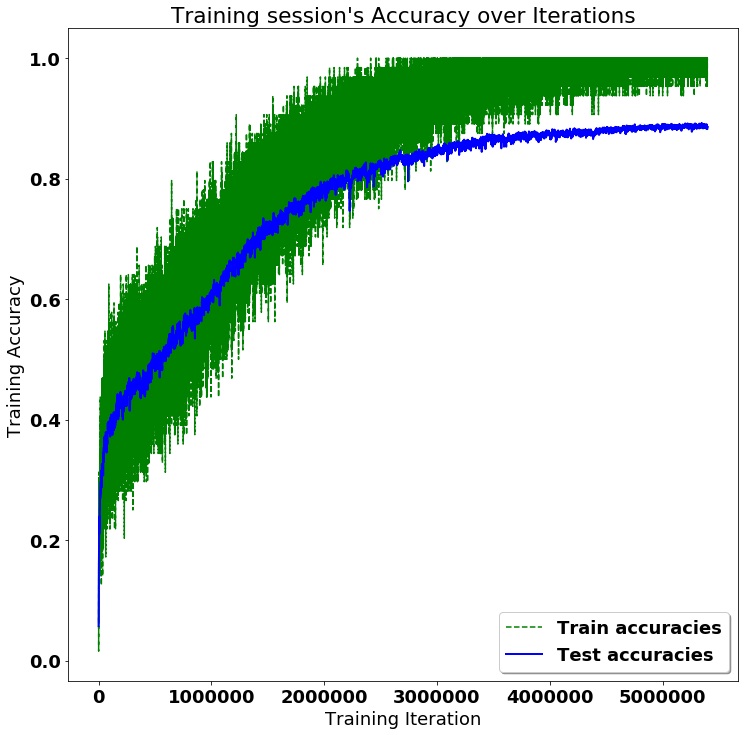

Testing Accuracy: 88.23529481887817%

Precision: 88.32439938854681%
Recall: 88.23529411764706%
f1_score: 88.19609996794611%

Confusion Matrix:
Created using test set of 5270 datapoints, normalised to % of each class in the test dataset


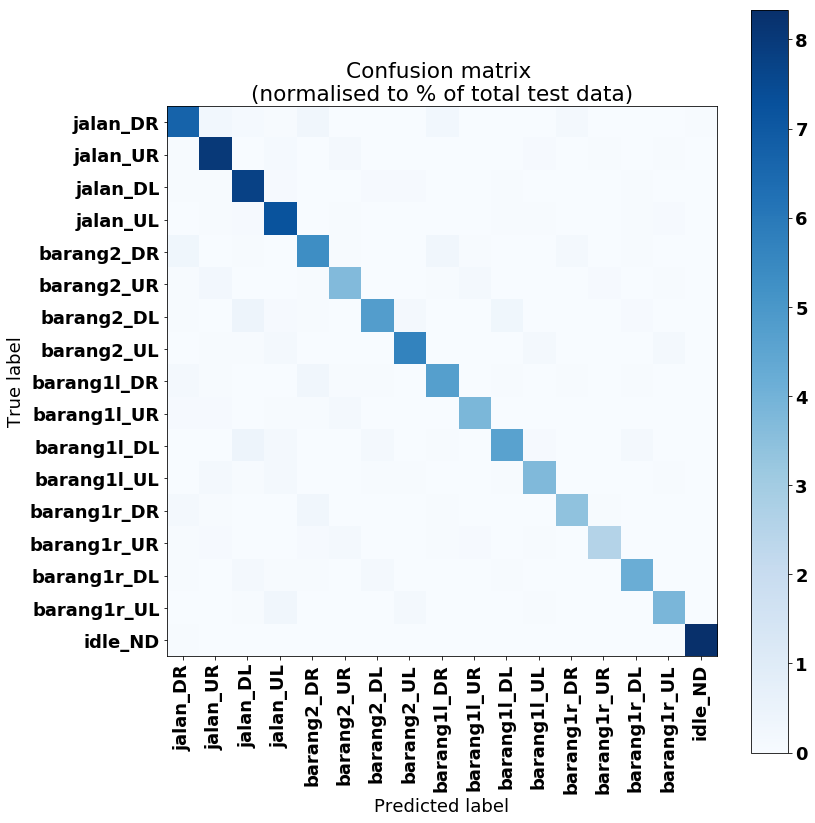

In [16]:
# (Inline plots: )
%matplotlib inline

font = {
    'family' : 'Bitstream Vera Sans',
    'weight' : 'bold',
    'size'   : 18
}
matplotlib.rc('font', **font)

width = 12
height = 12
plt.figure(figsize=(width, height))

indep_train_axis = np.array(range(batch_size, (len(train_losses)+1)*batch_size, batch_size))
#plt.plot(indep_train_axis, np.array(train_losses),     "b--", label="Train losses")
plt.plot(indep_train_axis, np.array(train_accuracies), "g--", label="Train accuracies")

indep_test_axis = np.append(
    np.array(range(batch_size, len(test_losses)*display_iter, display_iter)[:-1]),
    [training_iters]
)
#plt.plot(indep_test_axis, np.array(test_losses), "b-", linewidth=2.0, label="Test losses")
plt.plot(indep_test_axis, np.array(test_accuracies), "b-", linewidth=2.0, label="Test accuracies")
print(len(test_accuracies))
print(len(train_accuracies))

plt.title("Training session's Accuracy over Iterations")
plt.legend(loc='lower right', shadow=True)
plt.ylabel('Training Accuracy')
plt.xlabel('Training Iteration')

plt.show()

# Results

predictions = one_hot_predictions.argmax(1)

print("Testing Accuracy: {}%".format(100*accuracy_fin))

print("")
print("Precision: {}%".format(100*metrics.precision_score(y_test, predictions, average="weighted")))
print("Recall: {}%".format(100*metrics.recall_score(y_test, predictions, average="weighted")))
print("f1_score: {}%".format(100*metrics.f1_score(y_test, predictions, average="weighted")))

print("")
print("Confusion Matrix:")
print("Created using test set of {} datapoints, normalised to % of each class in the test dataset".format(len(y_test)))
confusion_matrix = metrics.confusion_matrix(y_test, predictions)


#print(confusion_matrix)
normalised_confusion_matrix = np.array(confusion_matrix, dtype=np.float32)/np.sum(confusion_matrix)*100


# Plot Results: 
width = 12
height = 12
plt.figure(figsize=(width, height))
plt.imshow(
    normalised_confusion_matrix, 
    interpolation='nearest', 
    cmap=plt.cm.Blues
)
plt.title("Confusion matrix \n(normalised to % of total test data)")
plt.colorbar()
tick_marks = np.arange(n_classes)
plt.xticks(tick_marks, LABELS, rotation=90)
plt.yticks(tick_marks, LABELS)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


In [17]:


#
#X_val_path = DATASET_PATH + "X_val.txt"
#X_val = load_X(X_val_path)
#print X_val
#
#preds = sess.run(
#    [pred],
#    feed_dict={
#        x: X_val
#   }
#)
#
#print preds

In [18]:
#sess.close()
print(test_accuracies)

[0.05711575, 0.09734345, 0.1377609, 0.13908918, 0.15199241, 0.16337761, 0.19278938, 0.1922201, 0.2056926, 0.20796964, 0.22163188, 0.21612903, 0.21062618, 0.21935484, 0.2366224, 0.23927894, 0.22409867, 0.22068311, 0.23225807, 0.23643264, 0.24686907, 0.25218216, 0.25218216, 0.26318786, 0.2626186, 0.2726755, 0.2747628, 0.28064516, 0.2698292, 0.27419356, 0.2793169, 0.28178367, 0.2825427, 0.28444022, 0.28956357, 0.29165086, 0.29677418, 0.28785577, 0.28064516, 0.2825427, 0.28216317, 0.27855787, 0.2971537, 0.30455408, 0.30075902, 0.30512333, 0.29848197, 0.29943073, 0.30891842, 0.31555977, 0.28728652, 0.29240987, 0.29259962, 0.30493358, 0.31954458, 0.32087287, 0.32466793, 0.32580644, 0.32068312, 0.31973433, 0.31726757, 0.31100568, 0.32106262, 0.32675523, 0.32447818, 0.30834913, 0.31461102, 0.32409868, 0.31897533, 0.32068312, 0.32390893, 0.32428843, 0.32485768, 0.32106262, 0.32352942, 0.32466793, 0.32656547, 0.32201138, 0.30721062, 0.31764707, 0.32637572, 0.33187857, 0.3451613, 0.33908918, 0.34

## Conclusion

Final accuracy of >90% is pretty good, considering that training takes about 7 minutes.

Noticeable confusion between activities of Clapping Hands and Boxing, and between Jumping Jacks and Waving Two Hands which is understandable.

In terms of the applicability of this to a wider dataset, I would imagine that it would be able to work for any activities in which the training included a views from all angles to be tested on. It would be interesting to see it's applicability to camera angles in between the 4 used in this dataset, without training on them specifically.

 Overall, this experiment validates the idea that 2D pose can be used for at least human activity recognition, and provides verification to continue onto use of 2D pose for behaviour estimation in both people and animals
 

 ### With regards to Using LSTM-RNNs
 - Batch sampling
     - It is neccessary to ensure you are not just sampling classes one at a time! (ie y_train is ordered by class and batch chosen in order)The use of random sampling of batches without replacement from the training data resolves this.    
 
 - Architecture
     - Testing has been run using a variety of hidden units per LSTM cell, with results showing that testing accuracy achieves a higher score when using a number of hidden cells approximately equal to that of the input, ie 34. The following figure displays the final accuracy achieved on the testing dataset for a variety of hidden units, all using a batch size of 4096 and 300 epochs (a total of 1657 iterations, with testing performed every 8th iteration).
   
 
 

## Future Works

Inclusion of :

 - A pipeline for qualitative results
 - A validation dataset
 - Momentum     
 - Normalise input data (each point with respect to distribution of itself only)
 - Dropout
 - Comparison of effect of changing batch size
 

Further research will be made into the use on more subtle activity classes, such as walking versus running, agitated movement versus calm movement, and perhaps normal versus abnormal behaviour, based on a baseline of normal motion.


## References

The dataset can be found at http://tele-immersion.citris-uc.org/berkeley_mhad released under the BSD-2 license
>Copyright (c) 2013, Regents of the University of California All rights reserved.

The network used in this experiment is based on the following, available under the [MIT License](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition/blob/master/LICENSE). :
> Guillaume Chevalier, LSTMs for Human Activity Recognition, 2016
> https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition



In [19]:
# Let's convert this notebook to a README for the GitHub project's title page:
# !jupyter nbconvert --to markdown LSTM.ipynb
# !mv LSTM.md README.md

## 

In [20]:
#### Camera

# import argparse
# import logging
# import time

# import cv2
# import numpy as np

# from tf_pose.estimator import TfPoseEstimator
# from tf_pose.networks import get_graph_path, model_wh

# logger = logging.getLogger('TfPoseEstimator-WebCam')
# logger.setLevel(logging.DEBUG)
# ch = logging.StreamHandler()
# ch.setLevel(logging.DEBUG)
# formatter = logging.Formatter('[%(asctime)s] [%(name)s] [%(levelname)s] %(message)s')
# ch.setFormatter(formatter)
# logger.addHandler(ch)

# class openpose:
#     def __init__(self, camera=0,resize='0x0',resize_out_ratio=4.0,model='mobilenet_thin',show_process=False):

#         logger.debug('initialization %s : %s' % (model, get_graph_path(model)))
#         w, h = model_wh(resize)
#         if w > 0 and h > 0:
#             e = TfPoseEstimator(get_graph_path(model), target_size=(w, h))
#         else:
#             e = TfPoseEstimator(get_graph_path(model), target_size=(432, 368))
#         logger.debug('cam read+')
#         cam = cv2.VideoCapture(camera)
#         ret_val, image = cam.read()
#         logger.info('cam image=%dx%d' % (image.shape[1], image.shape[0]))
        
#         fps_time = 0

#         while True:
#             ret_val, image = cam.read()

#             logger.debug('image process+')
#             humans = e.inference(image, resize_to_default=(w > 0 and h > 0), upsample_size=resize_out_ratio)

#             logger.debug('postprocess+')
#             image = TfPoseEstimator.draw_humans(image, humans, imgcopy=False)

#             logger.debug('show+')
#             cv2.putText(image,
#                         "FPS: %f" % (1.0 / (time.time() - fps_time)),
#                         (10, 10),  cv2.FONT_HERSHEY_SIMPLEX, 0.5,
#                         (0, 255, 0), 2)
#             cv2.imshow('tf-pose-estimation result', image)
#             fps_time = time.time()
#             if cv2.waitKey(1) == 27:
#                 break
#             logger.debug('finished+')

#         cv2.destroyAllWindows()

# if __name__ == '__main__':
#     openpose()
